In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import seaborn as sns   
from numpy import mean, sqrt, square, arange


# Read the data after preprocess

In [60]:
data = pd.read_csv('/media/bita/disco/Pesquisa/ACT_PS/act_pointing_correction_codes/organized_tests/act_boresight/pointing_corr_arr4_f150_snrT25_obs2_FullSeason_withEverything.csv')
data.keys() 

data.drop(['Freq','Offset X','Elevation 2 hr ago','Azimuth 2 hr ago','Error Offset X','Array','Modulus Offset','Azimuth','Elevation','T_Pan_R8_6','T_Pan_R8_3','T_Pan_R7_8','T_Pan_R7_5','T_Pan_R7_3','T_Pan_R6_6','T_Pan_R6_3','T_Pan_R5_5Lo','T_Pan_R5_5Hi','T_Pan_R4_6','T_Pan_R4_3','T_Pan_R3_7','T_Pan_R3_5','T_Pan_R1_2','T_Pan_R2_2','T_Pan_R2_6','T_Pan_R3_1','T_Pan_R5_9'], axis=1, inplace=True)


data['Ctime']= (data['Ctime']-1514764800)/(60*60*24) #Converting ctime in days
data_time_all = data['Ctime'] #Save the time for later
data.pop('Ctime')

dy_all_data = data['Error Offset Y'] #Save this variable for later
data.pop('Error Offset Y')

data.tail()


,Offset Y,APEX T,APEX T 2 hr ago,Angular Distance 2 hr ago,Azimuth Sun 2 hr ago,Elevation Sun 2 hr ago,Elevation Sun,Azimuth Sun,Angular Distance
1467,0.1211,-0.954545,-0.918182,1.923560,2.481119,-0.587254,-0.226373,2.131115,1.446979
1468,-0.0695,-0.890909,-0.781818,1.789974,2.363467,-0.498916,-0.110557,2.062898,1.318067
1469,1.2048,4.136364,-0.400000,1.211229,2.011777,-0.009253,0.442908,1.841349,0.847712
1470,0.6847,7.127273,5.254545,0.764476,1.807493,0.557289,1.031679,1.687267,1.344860
1471,0.6625,7.227273,5.618182,0.711483,1.785118,0.637678,1.113681,1.668580,1.267329


In [61]:
#looknig the data:
sns.pairplot(data[["APEX T","APEX T 2 hr ago", "Elevation 2 hr ago","Azimuth 2 hr ago","Azimuth Sun 2 hr ago","Offset Y","Angular Distance","Elevation Sun"]], diag_kind="kde")


KeyError: "['Elevation 2 hr ago', 'Azimuth 2 hr ago'] not in index"

# Split the data into training set and testing set:

In [62]:
train_dataset = data.sample(frac=0.75,random_state=1)
test_dataset = data.drop(train_dataset.index)

train_stats = train_dataset.describe() #statistics of the training set 
train_stats.pop("Offset Y") #remove the offset y of the train_dataset - I'll call offset y in the 'labels' variable
train_stats = train_stats.transpose()
train_stats

#Offset to compare:
 
train_labels = train_dataset.pop('Offset Y') #Used to train the machine learning
test_labels = test_dataset.pop('Offset Y') #Used to test the quality of the regression

#normalize the data - this is  very import to optimize the learning!
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [63]:
#Build the model - so far, this is the configutarion I found be the most useful for this dataset

#Sequential models: 
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.00001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model


In [64]:
#looking the details of the model 
model = build_model()
model.summary() 
example_batch = normed_train_data[:10] #example to check if it's working fine 
example_result = model.predict(example_batch)
example_result

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


array([[ 0.2913066 ],
       [ 0.10683686],
       [ 0.14813218],
       [ 0.14475483],
       [ 0.00929055],
       [-0.04056966],
       [ 0.30958906],
       [ 0.30265388],
       [ 0.30471775],
       [ 0.28459245]], dtype=float32)

In [65]:
EPOCHS = 10000 #number of iteractions for training the network

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, batch_size=32, validation_split = 0.2, verbose = True,callbacks=[tfdocs.modeling.EpochDots()] )
#Validation slip is to get e.g., 20% of the training set to cross-validate each learning step
#A callback is a set of functions to be applied at given stages of the training procedure
#You can use callbacks to get a view on internal states and statistics of the model during training

Train on 883 samples, validate on 221 samples
Epoch 1/10000
 32/883 [>.............................] - ETA: 9s - loss: 0.3937 - mae: 0.4604 - mse: 0.3937
Epoch: 0, loss:0.5896,  mae:0.5100,  mse:0.5896,  val_loss:0.6002,  val_mae:0.5198,  val_mse:0.6002,  
883/883 [==============================] - 0s 559us/sample - loss: 0.5896 - mae: 0.5100 - mse: 0.5896 - val_loss: 0.6002 - val_mae: 0.5198 - val_mse: 0.6002
Epoch 2/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.5703 - mae: 0.5024 - mse: 0.5703 - val_loss: 0.5828 - val_mae: 0.5137 - val_mse: 0.5828
Epoch 3/10000
883/883 [==============================] - 0s 86us/sample - loss: 0.5529 - mae: 0.4955 - mse: 0.5529 - val_loss: 0.5659 - val_mae: 0.5077 - val_mse: 0.5659
Epoch 4/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.5359 - mae: 0.4886 - mse: 0.5359 - val_loss: 0.5495 - val_mae: 0.5019 - val_mse: 0.5495
Epoch 5/10000
883/883 [==============================] - 0s 67us/sample - lo

883/883 [==============================] - 0s 60us/sample - loss: 0.1994 - mae: 0.3335 - mse: 0.1994 - val_loss: 0.2215 - val_mae: 0.3673 - val_mse: 0.2215
Epoch 48/10000
883/883 [==============================] - 0s 72us/sample - loss: 0.1974 - mae: 0.3319 - mse: 0.1974 - val_loss: 0.2195 - val_mae: 0.3658 - val_mse: 0.2195
Epoch 49/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.1956 - mae: 0.3305 - mse: 0.1956 - val_loss: 0.2175 - val_mae: 0.3643 - val_mse: 0.2175
Epoch 50/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.1939 - mae: 0.3291 - mse: 0.1939 - val_loss: 0.2156 - val_mae: 0.3629 - val_mse: 0.2156
Epoch 51/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.1922 - mae: 0.3274 - mse: 0.1922 - val_loss: 0.2139 - val_mae: 0.3614 - val_mse: 0.2139
Epoch 52/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1906 - mae: 0.3262 - mse: 0.1906 - val_loss: 0.2121 - val_mae: 0.3600 - val_m

Epoch 95/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.1585 - mae: 0.2924 - mse: 0.1585 - val_loss: 0.1750 - val_mae: 0.3252 - val_mse: 0.1750
Epoch 96/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1581 - mae: 0.2919 - mse: 0.1581 - val_loss: 0.1745 - val_mae: 0.3246 - val_mse: 0.1745
Epoch 97/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1577 - mae: 0.2914 - mse: 0.1577 - val_loss: 0.1740 - val_mae: 0.3241 - val_mse: 0.1740
Epoch 98/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.1573 - mae: 0.2909 - mse: 0.1573 - val_loss: 0.1735 - val_mae: 0.3236 - val_mse: 0.1735
Epoch 99/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.1570 - mae: 0.2905 - mse: 0.1570 - val_loss: 0.1731 - val_mae: 0.3231 - val_mse: 0.1731
Epoch 100/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.1566 - mae: 0.2900 - mse: 0.1566 - val_loss: 0.1726 - val_mae

883/883 [==============================] - 0s 53us/sample - loss: 0.1452 - mae: 0.2757 - mse: 0.1452 - val_loss: 0.1576 - val_mae: 0.3049 - val_mse: 0.1576
Epoch 142/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1450 - mae: 0.2753 - mse: 0.1450 - val_loss: 0.1573 - val_mae: 0.3046 - val_mse: 0.1573
Epoch 143/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1448 - mae: 0.2751 - mse: 0.1448 - val_loss: 0.1570 - val_mae: 0.3043 - val_mse: 0.1570
Epoch 144/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1446 - mae: 0.2747 - mse: 0.1446 - val_loss: 0.1568 - val_mae: 0.3039 - val_mse: 0.1568
Epoch 145/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1444 - mae: 0.2745 - mse: 0.1444 - val_loss: 0.1564 - val_mae: 0.3036 - val_mse: 0.1564
Epoch 146/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.1442 - mae: 0.2743 - mse: 0.1442 - val_loss: 0.1561 - val_mae: 0.3032 - 

Epoch 189/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1369 - mae: 0.2646 - mse: 0.1369 - val_loss: 0.1464 - val_mae: 0.2915 - val_mse: 0.1464
Epoch 190/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1368 - mae: 0.2646 - mse: 0.1368 - val_loss: 0.1462 - val_mae: 0.2912 - val_mse: 0.1462
Epoch 191/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1367 - mae: 0.2644 - mse: 0.1367 - val_loss: 0.1460 - val_mae: 0.2910 - val_mse: 0.1460
Epoch 192/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1365 - mae: 0.2642 - mse: 0.1365 - val_loss: 0.1458 - val_mae: 0.2907 - val_mse: 0.1458
Epoch 193/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.1364 - mae: 0.2639 - mse: 0.1364 - val_loss: 0.1457 - val_mae: 0.2905 - val_mse: 0.1457
Epoch 194/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.1362 - mae: 0.2638 - mse: 0.1362 - val_loss: 0.1455 - va

883/883 [==============================] - 0s 53us/sample - loss: 0.1314 - mae: 0.2568 - mse: 0.1314 - val_loss: 0.1388 - val_mae: 0.2815 - val_mse: 0.1388
Epoch 236/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.1313 - mae: 0.2567 - mse: 0.1313 - val_loss: 0.1387 - val_mae: 0.2813 - val_mse: 0.1387
Epoch 237/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1312 - mae: 0.2565 - mse: 0.1312 - val_loss: 0.1385 - val_mae: 0.2811 - val_mse: 0.1385
Epoch 238/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1311 - mae: 0.2564 - mse: 0.1311 - val_loss: 0.1384 - val_mae: 0.2809 - val_mse: 0.1384
Epoch 239/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.1309 - mae: 0.2562 - mse: 0.1309 - val_loss: 0.1382 - val_mae: 0.2807 - val_mse: 0.1382
Epoch 240/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1309 - mae: 0.2561 - mse: 0.1309 - val_loss: 0.1381 - val_mae: 0.2805 - 

Epoch 283/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.1268 - mae: 0.2501 - mse: 0.1268 - val_loss: 0.1330 - val_mae: 0.2731 - val_mse: 0.1330
Epoch 284/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1267 - mae: 0.2499 - mse: 0.1267 - val_loss: 0.1329 - val_mae: 0.2729 - val_mse: 0.1329
Epoch 285/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.1266 - mae: 0.2498 - mse: 0.1266 - val_loss: 0.1328 - val_mae: 0.2728 - val_mse: 0.1328
Epoch 286/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1265 - mae: 0.2497 - mse: 0.1265 - val_loss: 0.1327 - val_mae: 0.2727 - val_mse: 0.1327
Epoch 287/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.1265 - mae: 0.2497 - mse: 0.1265 - val_loss: 0.1326 - val_mae: 0.2725 - val_mse: 0.1326
Epoch 288/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1264 - mae: 0.2495 - mse: 0.1264 - val_loss: 0.1325 - va

883/883 [==============================] - 0s 60us/sample - loss: 0.1233 - mae: 0.2450 - mse: 0.1233 - val_loss: 0.1286 - val_mae: 0.2665 - val_mse: 0.1286
Epoch 330/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1233 - mae: 0.2449 - mse: 0.1233 - val_loss: 0.1286 - val_mae: 0.2664 - val_mse: 0.1286
Epoch 331/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.1232 - mae: 0.2449 - mse: 0.1232 - val_loss: 0.1284 - val_mae: 0.2662 - val_mse: 0.1284
Epoch 332/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1231 - mae: 0.2448 - mse: 0.1231 - val_loss: 0.1283 - val_mae: 0.2660 - val_mse: 0.1283
Epoch 333/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.1230 - mae: 0.2447 - mse: 0.1230 - val_loss: 0.1283 - val_mae: 0.2659 - val_mse: 0.1283
Epoch 334/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1230 - mae: 0.2446 - mse: 0.1230 - val_loss: 0.1282 - val_mae: 0.2658 - 

Epoch 377/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.1203 - mae: 0.2409 - mse: 0.1203 - val_loss: 0.1251 - val_mae: 0.2614 - val_mse: 0.1251
Epoch 378/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.1203 - mae: 0.2408 - mse: 0.1203 - val_loss: 0.1250 - val_mae: 0.2613 - val_mse: 0.1250
Epoch 379/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1202 - mae: 0.2407 - mse: 0.1202 - val_loss: 0.1249 - val_mae: 0.2612 - val_mse: 0.1249
Epoch 380/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1202 - mae: 0.2405 - mse: 0.1202 - val_loss: 0.1248 - val_mae: 0.2611 - val_mse: 0.1248
Epoch 381/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.1201 - mae: 0.2405 - mse: 0.1201 - val_loss: 0.1248 - val_mae: 0.2610 - val_mse: 0.1248
Epoch 382/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1201 - mae: 0.2404 - mse: 0.1201 - val_loss: 0.1247 - va

883/883 [==============================] - 0s 55us/sample - loss: 0.1178 - mae: 0.2374 - mse: 0.1178 - val_loss: 0.1220 - val_mae: 0.2571 - val_mse: 0.1220
Epoch 424/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1177 - mae: 0.2372 - mse: 0.1177 - val_loss: 0.1220 - val_mae: 0.2571 - val_mse: 0.1220
Epoch 425/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.1176 - mae: 0.2371 - mse: 0.1176 - val_loss: 0.1220 - val_mae: 0.2571 - val_mse: 0.1220
Epoch 426/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1176 - mae: 0.2372 - mse: 0.1176 - val_loss: 0.1219 - val_mae: 0.2570 - val_mse: 0.1219
Epoch 427/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1176 - mae: 0.2370 - mse: 0.1176 - val_loss: 0.1219 - val_mae: 0.2569 - val_mse: 0.1219
Epoch 428/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1175 - mae: 0.2369 - mse: 0.1175 - val_loss: 0.1218 - val_mae: 0.2568 - 

Epoch 471/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.1154 - mae: 0.2341 - mse: 0.1154 - val_loss: 0.1195 - val_mae: 0.2538 - val_mse: 0.1195
Epoch 472/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1154 - mae: 0.2341 - mse: 0.1154 - val_loss: 0.1195 - val_mae: 0.2538 - val_mse: 0.1195
Epoch 473/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1153 - mae: 0.2340 - mse: 0.1153 - val_loss: 0.1194 - val_mae: 0.2537 - val_mse: 0.1194
Epoch 474/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1152 - mae: 0.2340 - mse: 0.1152 - val_loss: 0.1194 - val_mae: 0.2537 - val_mse: 0.1194
Epoch 475/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.1152 - mae: 0.2339 - mse: 0.1152 - val_loss: 0.1194 - val_mae: 0.2537 - val_mse: 0.1194
Epoch 476/10000
883/883 [==============================] - 0s 50us/sample - loss: 0.1151 - mae: 0.2339 - mse: 0.1151 - val_loss: 0.1194 - va

883/883 [==============================] - 0s 56us/sample - loss: 0.1134 - mae: 0.2314 - mse: 0.1134 - val_loss: 0.1175 - val_mae: 0.2512 - val_mse: 0.1175
Epoch 518/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.1133 - mae: 0.2314 - mse: 0.1133 - val_loss: 0.1175 - val_mae: 0.2512 - val_mse: 0.1175
Epoch 519/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1133 - mae: 0.2314 - mse: 0.1133 - val_loss: 0.1175 - val_mae: 0.2512 - val_mse: 0.1175
Epoch 520/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1132 - mae: 0.2313 - mse: 0.1132 - val_loss: 0.1174 - val_mae: 0.2510 - val_mse: 0.1174
Epoch 521/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.1132 - mae: 0.2313 - mse: 0.1132 - val_loss: 0.1173 - val_mae: 0.2509 - val_mse: 0.1173
Epoch 522/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.1131 - mae: 0.2313 - mse: 0.1131 - val_loss: 0.1173 - val_mae: 0.2509 - 

Epoch 565/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1114 - mae: 0.2289 - mse: 0.1114 - val_loss: 0.1155 - val_mae: 0.2485 - val_mse: 0.1155
Epoch 566/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.1114 - mae: 0.2288 - mse: 0.1114 - val_loss: 0.1155 - val_mae: 0.2485 - val_mse: 0.1155
Epoch 567/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1113 - mae: 0.2287 - mse: 0.1113 - val_loss: 0.1155 - val_mae: 0.2485 - val_mse: 0.1155
Epoch 568/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1113 - mae: 0.2287 - mse: 0.1113 - val_loss: 0.1154 - val_mae: 0.2484 - val_mse: 0.1154
Epoch 569/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.1112 - mae: 0.2287 - mse: 0.1112 - val_loss: 0.1154 - val_mae: 0.2484 - val_mse: 0.1154
Epoch 570/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1112 - mae: 0.2286 - mse: 0.1112 - val_loss: 0.1155 - va

883/883 [==============================] - 0s 56us/sample - loss: 0.1096 - mae: 0.2265 - mse: 0.1096 - val_loss: 0.1138 - val_mae: 0.2463 - val_mse: 0.1138
Epoch 612/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1096 - mae: 0.2266 - mse: 0.1096 - val_loss: 0.1138 - val_mae: 0.2463 - val_mse: 0.1138
Epoch 613/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1095 - mae: 0.2264 - mse: 0.1095 - val_loss: 0.1138 - val_mae: 0.2463 - val_mse: 0.1138
Epoch 614/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1095 - mae: 0.2264 - mse: 0.1095 - val_loss: 0.1138 - val_mae: 0.2463 - val_mse: 0.1138
Epoch 615/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1094 - mae: 0.2263 - mse: 0.1094 - val_loss: 0.1138 - val_mae: 0.2462 - val_mse: 0.1138
Epoch 616/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1094 - mae: 0.2264 - mse: 0.1094 - val_loss: 0.1137 - val_mae: 0.2462 - 

Epoch 659/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1079 - mae: 0.2243 - mse: 0.1079 - val_loss: 0.1124 - val_mae: 0.2444 - val_mse: 0.1124
Epoch 660/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.1078 - mae: 0.2244 - mse: 0.1078 - val_loss: 0.1124 - val_mae: 0.2443 - val_mse: 0.1124
Epoch 661/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.1078 - mae: 0.2244 - mse: 0.1078 - val_loss: 0.1123 - val_mae: 0.2443 - val_mse: 0.1123
Epoch 662/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1078 - mae: 0.2242 - mse: 0.1078 - val_loss: 0.1123 - val_mae: 0.2442 - val_mse: 0.1123
Epoch 663/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.1078 - mae: 0.2242 - mse: 0.1078 - val_loss: 0.1122 - val_mae: 0.2441 - val_mse: 0.1122
Epoch 664/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1077 - mae: 0.2241 - mse: 0.1077 - val_loss: 0.1121 - va

883/883 [==============================] - 0s 54us/sample - loss: 0.1064 - mae: 0.2224 - mse: 0.1064 - val_loss: 0.1112 - val_mae: 0.2428 - val_mse: 0.1112
Epoch 706/10000
883/883 [==============================] - 0s 84us/sample - loss: 0.1063 - mae: 0.2224 - mse: 0.1063 - val_loss: 0.1111 - val_mae: 0.2427 - val_mse: 0.1111
Epoch 707/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.1063 - mae: 0.2224 - mse: 0.1063 - val_loss: 0.1110 - val_mae: 0.2426 - val_mse: 0.1110
Epoch 708/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1063 - mae: 0.2223 - mse: 0.1063 - val_loss: 0.1110 - val_mae: 0.2426 - val_mse: 0.1110
Epoch 709/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.1062 - mae: 0.2223 - mse: 0.1062 - val_loss: 0.1110 - val_mae: 0.2425 - val_mse: 0.1110
Epoch 710/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1062 - mae: 0.2222 - mse: 0.1062 - val_loss: 0.1110 - val_mae: 0.2425 - 

Epoch 753/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1048 - mae: 0.2207 - mse: 0.1048 - val_loss: 0.1099 - val_mae: 0.2410 - val_mse: 0.1099
Epoch 754/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1048 - mae: 0.2206 - mse: 0.1048 - val_loss: 0.1099 - val_mae: 0.2409 - val_mse: 0.1099
Epoch 755/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.1048 - mae: 0.2205 - mse: 0.1048 - val_loss: 0.1099 - val_mae: 0.2409 - val_mse: 0.1099
Epoch 756/10000
883/883 [==============================] - 0s 50us/sample - loss: 0.1047 - mae: 0.2203 - mse: 0.1047 - val_loss: 0.1099 - val_mae: 0.2409 - val_mse: 0.1099
Epoch 757/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.1047 - mae: 0.2205 - mse: 0.1047 - val_loss: 0.1099 - val_mae: 0.2409 - val_mse: 0.1099
Epoch 758/10000
883/883 [==============================] - ETA: 0s - loss: 0.1149 - mae: 0.2358 - mse: 0.1149 - 0s 63us/sample - loss: 0.104

Epoch 800/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.1034 - mae: 0.2188 - mse: 0.1034 - val_loss: 0.1088 - val_mae: 0.2394 - val_mse: 0.1088
Epoch 801/10000
 32/883 [>.............................] - ETA: 0s - loss: 0.0592 - mae: 0.1588 - mse: 0.0592
Epoch: 800, loss:0.1034,  mae:0.2188,  mse:0.1034,  val_loss:0.1088,  val_mae:0.2393,  val_mse:0.1088,  
883/883 [==============================] - 0s 55us/sample - loss: 0.1034 - mae: 0.2188 - mse: 0.1034 - val_loss: 0.1088 - val_mae: 0.2393 - val_mse: 0.1088
Epoch 802/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1033 - mae: 0.2187 - mse: 0.1033 - val_loss: 0.1087 - val_mae: 0.2393 - val_mse: 0.1087
Epoch 803/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1033 - mae: 0.2187 - mse: 0.1033 - val_loss: 0.1086 - val_mae: 0.2392 - val_mse: 0.1086
Epoch 804/10000
883/883 [==============================] - 0s 51us/sample - loss: 0.1033 - mae: 0.2188 - mse: 0.1

883/883 [==============================] - 0s 57us/sample - loss: 0.1020 - mae: 0.2172 - mse: 0.1020 - val_loss: 0.1075 - val_mae: 0.2375 - val_mse: 0.1075
Epoch 847/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1020 - mae: 0.2170 - mse: 0.1020 - val_loss: 0.1075 - val_mae: 0.2376 - val_mse: 0.1075
Epoch 848/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1020 - mae: 0.2171 - mse: 0.1020 - val_loss: 0.1075 - val_mae: 0.2375 - val_mse: 0.1075
Epoch 849/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.1019 - mae: 0.2171 - mse: 0.1019 - val_loss: 0.1075 - val_mae: 0.2375 - val_mse: 0.1075
Epoch 850/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1019 - mae: 0.2170 - mse: 0.1019 - val_loss: 0.1075 - val_mae: 0.2374 - val_mse: 0.1075
Epoch 851/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.1019 - mae: 0.2169 - mse: 0.1019 - val_loss: 0.1075 - val_mae: 0.2375 - 

Epoch 894/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1006 - mae: 0.2155 - mse: 0.1006 - val_loss: 0.1063 - val_mae: 0.2358 - val_mse: 0.1063
Epoch 895/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.1006 - mae: 0.2154 - mse: 0.1006 - val_loss: 0.1064 - val_mae: 0.2359 - val_mse: 0.1064
Epoch 896/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.1006 - mae: 0.2154 - mse: 0.1006 - val_loss: 0.1063 - val_mae: 0.2358 - val_mse: 0.1063
Epoch 897/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.1005 - mae: 0.2153 - mse: 0.1005 - val_loss: 0.1063 - val_mae: 0.2358 - val_mse: 0.1063
Epoch 898/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.1005 - mae: 0.2153 - mse: 0.1005 - val_loss: 0.1063 - val_mae: 0.2358 - val_mse: 0.1063
Epoch 899/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.1005 - mae: 0.2153 - mse: 0.1005 - val_loss: 0.1062 - va

883/883 [==============================] - 0s 55us/sample - loss: 0.0993 - mae: 0.2139 - mse: 0.0993 - val_loss: 0.1054 - val_mae: 0.2346 - val_mse: 0.1054
Epoch 941/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0993 - mae: 0.2139 - mse: 0.0993 - val_loss: 0.1053 - val_mae: 0.2346 - val_mse: 0.1053
Epoch 942/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0993 - mae: 0.2139 - mse: 0.0993 - val_loss: 0.1053 - val_mae: 0.2346 - val_mse: 0.1053
Epoch 943/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0992 - mae: 0.2139 - mse: 0.0992 - val_loss: 0.1053 - val_mae: 0.2346 - val_mse: 0.1053
Epoch 944/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0992 - mae: 0.2139 - mse: 0.0992 - val_loss: 0.1052 - val_mae: 0.2344 - val_mse: 0.1052
Epoch 945/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0992 - mae: 0.2139 - mse: 0.0992 - val_loss: 0.1052 - val_mae: 0.2344 - 

Epoch 988/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0980 - mae: 0.2124 - mse: 0.0980 - val_loss: 0.1041 - val_mae: 0.2330 - val_mse: 0.1041
Epoch 989/10000
883/883 [==============================] - 0s 88us/sample - loss: 0.0980 - mae: 0.2124 - mse: 0.0980 - val_loss: 0.1041 - val_mae: 0.2331 - val_mse: 0.1041
Epoch 990/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0980 - mae: 0.2124 - mse: 0.0980 - val_loss: 0.1041 - val_mae: 0.2331 - val_mse: 0.1041
Epoch 991/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0980 - mae: 0.2123 - mse: 0.0980 - val_loss: 0.1041 - val_mae: 0.2331 - val_mse: 0.1041
Epoch 992/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0979 - mae: 0.2124 - mse: 0.0979 - val_loss: 0.1041 - val_mae: 0.2331 - val_mse: 0.1041
Epoch 993/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0979 - mae: 0.2123 - mse: 0.0979 - val_loss: 0.1041 - va

883/883 [==============================] - 0s 55us/sample - loss: 0.0968 - mae: 0.2109 - mse: 0.0968 - val_loss: 0.1031 - val_mae: 0.2318 - val_mse: 0.1031
Epoch 1035/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0968 - mae: 0.2110 - mse: 0.0968 - val_loss: 0.1030 - val_mae: 0.2317 - val_mse: 0.1030
Epoch 1036/10000
883/883 [==============================] - 0s 77us/sample - loss: 0.0968 - mae: 0.2110 - mse: 0.0968 - val_loss: 0.1030 - val_mae: 0.2316 - val_mse: 0.1030
Epoch 1037/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0967 - mae: 0.2109 - mse: 0.0967 - val_loss: 0.1029 - val_mae: 0.2316 - val_mse: 0.1029
Epoch 1038/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0967 - mae: 0.2108 - mse: 0.0967 - val_loss: 0.1029 - val_mae: 0.2316 - val_mse: 0.1029
Epoch 1039/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0967 - mae: 0.2108 - mse: 0.0967 - val_loss: 0.1030 - val_mae: 0.2

883/883 [==============================] - 0s 58us/sample - loss: 0.0956 - mae: 0.2096 - mse: 0.0956 - val_loss: 0.1022 - val_mae: 0.2308 - val_mse: 0.1022
Epoch 1082/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0956 - mae: 0.2096 - mse: 0.0956 - val_loss: 0.1021 - val_mae: 0.2307 - val_mse: 0.1021
Epoch 1083/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0956 - mae: 0.2097 - mse: 0.0956 - val_loss: 0.1021 - val_mae: 0.2307 - val_mse: 0.1021
Epoch 1084/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0955 - mae: 0.2096 - mse: 0.0955 - val_loss: 0.1020 - val_mae: 0.2305 - val_mse: 0.1020
Epoch 1085/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0955 - mae: 0.2094 - mse: 0.0955 - val_loss: 0.1020 - val_mae: 0.2305 - val_mse: 0.1020
Epoch 1086/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0955 - mae: 0.2095 - mse: 0.0955 - val_loss: 0.1020 - val_mae: 0.23

883/883 [==============================] - 0s 61us/sample - loss: 0.0945 - mae: 0.2084 - mse: 0.0945 - val_loss: 0.1010 - val_mae: 0.2293 - val_mse: 0.1010
Epoch 1128/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0944 - mae: 0.2082 - mse: 0.0944 - val_loss: 0.1010 - val_mae: 0.2293 - val_mse: 0.1010
Epoch 1129/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0944 - mae: 0.2081 - mse: 0.0944 - val_loss: 0.1009 - val_mae: 0.2292 - val_mse: 0.1009
Epoch 1130/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0944 - mae: 0.2081 - mse: 0.0944 - val_loss: 0.1009 - val_mae: 0.2292 - val_mse: 0.1009
Epoch 1131/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0944 - mae: 0.2080 - mse: 0.0944 - val_loss: 0.1010 - val_mae: 0.2293 - val_mse: 0.1010
Epoch 1132/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0943 - mae: 0.2081 - mse: 0.0943 - val_loss: 0.1010 - val_mae: 0.22

883/883 [==============================] - 0s 58us/sample - loss: 0.0933 - mae: 0.2070 - mse: 0.0933 - val_loss: 0.1000 - val_mae: 0.2283 - val_mse: 0.1000
Epoch 1175/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0932 - mae: 0.2070 - mse: 0.0932 - val_loss: 0.1000 - val_mae: 0.2282 - val_mse: 0.1000
Epoch 1176/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0932 - mae: 0.2069 - mse: 0.0932 - val_loss: 0.1000 - val_mae: 0.2282 - val_mse: 0.1000
Epoch 1177/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0932 - mae: 0.2068 - mse: 0.0932 - val_loss: 0.1000 - val_mae: 0.2282 - val_mse: 0.1000
Epoch 1178/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0932 - mae: 0.2068 - mse: 0.0932 - val_loss: 0.0999 - val_mae: 0.2282 - val_mse: 0.0999
Epoch 1179/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0931 - mae: 0.2068 - mse: 0.0931 - val_loss: 0.0999 - val_mae: 0.22

883/883 [==============================] - 0s 70us/sample - loss: 0.0921 - mae: 0.2055 - mse: 0.0921 - val_loss: 0.0989 - val_mae: 0.2269 - val_mse: 0.0989
Epoch 1221/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0921 - mae: 0.2055 - mse: 0.0921 - val_loss: 0.0989 - val_mae: 0.2269 - val_mse: 0.0989
Epoch 1222/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0921 - mae: 0.2055 - mse: 0.0921 - val_loss: 0.0989 - val_mae: 0.2269 - val_mse: 0.0989
Epoch 1223/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0920 - mae: 0.2054 - mse: 0.0920 - val_loss: 0.0989 - val_mae: 0.2268 - val_mse: 0.0989
Epoch 1224/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0920 - mae: 0.2055 - mse: 0.0920 - val_loss: 0.0988 - val_mae: 0.2268 - val_mse: 0.0988
Epoch 1225/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0920 - mae: 0.2054 - mse: 0.0920 - val_loss: 0.0988 - val_mae: 0.22

883/883 [==============================] - 0s 61us/sample - loss: 0.0910 - mae: 0.2042 - mse: 0.0910 - val_loss: 0.0980 - val_mae: 0.2258 - val_mse: 0.0980
Epoch 1268/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0909 - mae: 0.2043 - mse: 0.0909 - val_loss: 0.0980 - val_mae: 0.2258 - val_mse: 0.0980
Epoch 1269/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0909 - mae: 0.2042 - mse: 0.0909 - val_loss: 0.0979 - val_mae: 0.2257 - val_mse: 0.0979
Epoch 1270/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0909 - mae: 0.2042 - mse: 0.0909 - val_loss: 0.0978 - val_mae: 0.2256 - val_mse: 0.0978
Epoch 1271/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.0909 - mae: 0.2042 - mse: 0.0909 - val_loss: 0.0978 - val_mae: 0.2256 - val_mse: 0.0978
Epoch 1272/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0908 - mae: 0.2041 - mse: 0.0908 - val_loss: 0.0979 - val_mae: 0.22

883/883 [==============================] - 0s 55us/sample - loss: 0.0898 - mae: 0.2031 - mse: 0.0898 - val_loss: 0.0969 - val_mae: 0.2246 - val_mse: 0.0969
Epoch 1314/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0898 - mae: 0.2029 - mse: 0.0898 - val_loss: 0.0969 - val_mae: 0.2246 - val_mse: 0.0969
Epoch 1315/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0898 - mae: 0.2030 - mse: 0.0898 - val_loss: 0.0969 - val_mae: 0.2245 - val_mse: 0.0969
Epoch 1316/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.0898 - mae: 0.2027 - mse: 0.0898 - val_loss: 0.0969 - val_mae: 0.2246 - val_mse: 0.0969
Epoch 1317/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0898 - mae: 0.2028 - mse: 0.0898 - val_loss: 0.0969 - val_mae: 0.2246 - val_mse: 0.0969
Epoch 1318/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0897 - mae: 0.2029 - mse: 0.0897 - val_loss: 0.0969 - val_mae: 0.22

883/883 [==============================] - 0s 59us/sample - loss: 0.0887 - mae: 0.2016 - mse: 0.0887 - val_loss: 0.0960 - val_mae: 0.2235 - val_mse: 0.0960
Epoch 1361/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0887 - mae: 0.2015 - mse: 0.0887 - val_loss: 0.0960 - val_mae: 0.2235 - val_mse: 0.0960
Epoch 1362/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0887 - mae: 0.2015 - mse: 0.0887 - val_loss: 0.0960 - val_mae: 0.2235 - val_mse: 0.0960
Epoch 1363/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0887 - mae: 0.2014 - mse: 0.0887 - val_loss: 0.0960 - val_mae: 0.2235 - val_mse: 0.0960
Epoch 1364/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0887 - mae: 0.2014 - mse: 0.0887 - val_loss: 0.0960 - val_mae: 0.2235 - val_mse: 0.0960
Epoch 1365/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0886 - mae: 0.2015 - mse: 0.0886 - val_loss: 0.0959 - val_mae: 0.22

883/883 [==============================] - 0s 56us/sample - loss: 0.0876 - mae: 0.2003 - mse: 0.0876 - val_loss: 0.0952 - val_mae: 0.2226 - val_mse: 0.0952
Epoch 1407/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0876 - mae: 0.2002 - mse: 0.0876 - val_loss: 0.0952 - val_mae: 0.2226 - val_mse: 0.0952
Epoch 1408/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0875 - mae: 0.2002 - mse: 0.0875 - val_loss: 0.0952 - val_mae: 0.2226 - val_mse: 0.0952
Epoch 1409/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0875 - mae: 0.2002 - mse: 0.0875 - val_loss: 0.0951 - val_mae: 0.2225 - val_mse: 0.0951
Epoch 1410/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0875 - mae: 0.2001 - mse: 0.0875 - val_loss: 0.0951 - val_mae: 0.2224 - val_mse: 0.0951
Epoch 1411/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0875 - mae: 0.2001 - mse: 0.0875 - val_loss: 0.0950 - val_mae: 0.22

883/883 [==============================] - 0s 53us/sample - loss: 0.0864 - mae: 0.1991 - mse: 0.0864 - val_loss: 0.0943 - val_mae: 0.2214 - val_mse: 0.0943
Epoch 1454/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0864 - mae: 0.1989 - mse: 0.0864 - val_loss: 0.0943 - val_mae: 0.2214 - val_mse: 0.0943
Epoch 1455/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0864 - mae: 0.1989 - mse: 0.0864 - val_loss: 0.0942 - val_mae: 0.2213 - val_mse: 0.0942
Epoch 1456/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0864 - mae: 0.1988 - mse: 0.0864 - val_loss: 0.0942 - val_mae: 0.2214 - val_mse: 0.0942
Epoch 1457/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0864 - mae: 0.1988 - mse: 0.0864 - val_loss: 0.0942 - val_mae: 0.2213 - val_mse: 0.0942
Epoch 1458/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0863 - mae: 0.1987 - mse: 0.0863 - val_loss: 0.0942 - val_mae: 0.22

883/883 [==============================] - 0s 64us/sample - loss: 0.0853 - mae: 0.1976 - mse: 0.0853 - val_loss: 0.0935 - val_mae: 0.2206 - val_mse: 0.0935
Epoch 1501/10000
 32/883 [>.............................] - ETA: 0s - loss: 0.0931 - mae: 0.2146 - mse: 0.0931
Epoch: 1500, loss:0.0853,  mae:0.1976,  mse:0.0853,  val_loss:0.0935,  val_mae:0.2206,  val_mse:0.0935,  
883/883 [==============================] - 0s 69us/sample - loss: 0.0853 - mae: 0.1976 - mse: 0.0853 - val_loss: 0.0935 - val_mae: 0.2206 - val_mse: 0.0935
Epoch 1502/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0853 - mae: 0.1976 - mse: 0.0853 - val_loss: 0.0935 - val_mae: 0.2206 - val_mse: 0.0935
Epoch 1503/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0853 - mae: 0.1976 - mse: 0.0853 - val_loss: 0.0935 - val_mae: 0.2205 - val_mse: 0.0935
Epoch 1504/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0852 - mae: 0.1974 - mse: 0.0852 - val_l

883/883 [==============================] - 0s 69us/sample - loss: 0.0842 - mae: 0.1963 - mse: 0.0842 - val_loss: 0.0928 - val_mae: 0.2197 - val_mse: 0.0928
Epoch 1547/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0842 - mae: 0.1964 - mse: 0.0842 - val_loss: 0.0927 - val_mae: 0.2196 - val_mse: 0.0927
Epoch 1548/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0842 - mae: 0.1963 - mse: 0.0842 - val_loss: 0.0927 - val_mae: 0.2195 - val_mse: 0.0927
Epoch 1549/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0842 - mae: 0.1963 - mse: 0.0842 - val_loss: 0.0927 - val_mae: 0.2195 - val_mse: 0.0927
Epoch 1550/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0842 - mae: 0.1962 - mse: 0.0842 - val_loss: 0.0927 - val_mae: 0.2195 - val_mse: 0.0927
Epoch 1551/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0841 - mae: 0.1964 - mse: 0.0841 - val_loss: 0.0926 - val_mae: 0.21

883/883 [==============================] - 0s 80us/sample - loss: 0.0832 - mae: 0.1951 - mse: 0.0832 - val_loss: 0.0919 - val_mae: 0.2186 - val_mse: 0.0919
Epoch 1594/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0832 - mae: 0.1950 - mse: 0.0832 - val_loss: 0.0918 - val_mae: 0.2186 - val_mse: 0.0918
Epoch 1595/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0832 - mae: 0.1951 - mse: 0.0832 - val_loss: 0.0918 - val_mae: 0.2185 - val_mse: 0.0918
Epoch 1596/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0832 - mae: 0.1949 - mse: 0.0832 - val_loss: 0.0918 - val_mae: 0.2186 - val_mse: 0.0918
Epoch 1597/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0831 - mae: 0.1949 - mse: 0.0831 - val_loss: 0.0918 - val_mae: 0.2186 - val_mse: 0.0918
Epoch 1598/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0831 - mae: 0.1949 - mse: 0.0831 - val_loss: 0.0918 - val_mae: 0.21

883/883 [==============================] - 0s 64us/sample - loss: 0.0822 - mae: 0.1940 - mse: 0.0822 - val_loss: 0.0909 - val_mae: 0.2176 - val_mse: 0.0909
Epoch 1640/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0822 - mae: 0.1938 - mse: 0.0822 - val_loss: 0.0909 - val_mae: 0.2176 - val_mse: 0.0909
Epoch 1641/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0822 - mae: 0.1939 - mse: 0.0822 - val_loss: 0.0909 - val_mae: 0.2176 - val_mse: 0.0909
Epoch 1642/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0822 - mae: 0.1938 - mse: 0.0822 - val_loss: 0.0909 - val_mae: 0.2175 - val_mse: 0.0909
Epoch 1643/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0822 - mae: 0.1938 - mse: 0.0822 - val_loss: 0.0909 - val_mae: 0.2175 - val_mse: 0.0909
Epoch 1644/10000
883/883 [==============================] - 0s 81us/sample - loss: 0.0821 - mae: 0.1937 - mse: 0.0821 - val_loss: 0.0908 - val_mae: 0.21

883/883 [==============================] - 0s 58us/sample - loss: 0.0812 - mae: 0.1927 - mse: 0.0812 - val_loss: 0.0901 - val_mae: 0.2167 - val_mse: 0.0901
Epoch 1687/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0812 - mae: 0.1926 - mse: 0.0812 - val_loss: 0.0901 - val_mae: 0.2168 - val_mse: 0.0901
Epoch 1688/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0812 - mae: 0.1927 - mse: 0.0812 - val_loss: 0.0901 - val_mae: 0.2167 - val_mse: 0.0901
Epoch 1689/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0812 - mae: 0.1926 - mse: 0.0812 - val_loss: 0.0901 - val_mae: 0.2166 - val_mse: 0.0901
Epoch 1690/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0811 - mae: 0.1926 - mse: 0.0811 - val_loss: 0.0900 - val_mae: 0.2166 - val_mse: 0.0900
Epoch 1691/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0811 - mae: 0.1926 - mse: 0.0811 - val_loss: 0.0900 - val_mae: 0.21

883/883 [==============================] - 0s 65us/sample - loss: 0.0803 - mae: 0.1915 - mse: 0.0803 - val_loss: 0.0892 - val_mae: 0.2155 - val_mse: 0.0892
Epoch 1733/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0802 - mae: 0.1914 - mse: 0.0802 - val_loss: 0.0891 - val_mae: 0.2155 - val_mse: 0.0891
Epoch 1734/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0802 - mae: 0.1914 - mse: 0.0802 - val_loss: 0.0891 - val_mae: 0.2155 - val_mse: 0.0891
Epoch 1735/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0802 - mae: 0.1913 - mse: 0.0802 - val_loss: 0.0892 - val_mae: 0.2156 - val_mse: 0.0892
Epoch 1736/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0802 - mae: 0.1913 - mse: 0.0802 - val_loss: 0.0892 - val_mae: 0.2156 - val_mse: 0.0892
Epoch 1737/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0801 - mae: 0.1914 - mse: 0.0801 - val_loss: 0.0892 - val_mae: 0.21

883/883 [==============================] - 0s 101us/sample - loss: 0.0793 - mae: 0.1901 - mse: 0.0793 - val_loss: 0.0885 - val_mae: 0.2148 - val_mse: 0.0885
Epoch 1780/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0792 - mae: 0.1902 - mse: 0.0792 - val_loss: 0.0885 - val_mae: 0.2148 - val_mse: 0.0885
Epoch 1781/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0792 - mae: 0.1901 - mse: 0.0792 - val_loss: 0.0885 - val_mae: 0.2149 - val_mse: 0.0885
Epoch 1782/10000
883/883 [==============================] - 0s 71us/sample - loss: 0.0792 - mae: 0.1901 - mse: 0.0792 - val_loss: 0.0884 - val_mae: 0.2149 - val_mse: 0.0884
Epoch 1783/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0792 - mae: 0.1902 - mse: 0.0792 - val_loss: 0.0884 - val_mae: 0.2149 - val_mse: 0.0884
Epoch 1784/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0792 - mae: 0.1900 - mse: 0.0792 - val_loss: 0.0884 - val_mae: 0.2

883/883 [==============================] - 0s 62us/sample - loss: 0.0783 - mae: 0.1890 - mse: 0.0783 - val_loss: 0.0877 - val_mae: 0.2141 - val_mse: 0.0877
Epoch 1826/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0783 - mae: 0.1890 - mse: 0.0783 - val_loss: 0.0876 - val_mae: 0.2140 - val_mse: 0.0876
Epoch 1827/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0783 - mae: 0.1889 - mse: 0.0783 - val_loss: 0.0876 - val_mae: 0.2139 - val_mse: 0.0876
Epoch 1828/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0782 - mae: 0.1889 - mse: 0.0782 - val_loss: 0.0876 - val_mae: 0.2138 - val_mse: 0.0876
Epoch 1829/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0782 - mae: 0.1888 - mse: 0.0782 - val_loss: 0.0876 - val_mae: 0.2140 - val_mse: 0.0876
Epoch 1830/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0782 - mae: 0.1889 - mse: 0.0782 - val_loss: 0.0876 - val_mae: 0.21

883/883 [==============================] - 0s 54us/sample - loss: 0.0773 - mae: 0.1879 - mse: 0.0773 - val_loss: 0.0869 - val_mae: 0.2133 - val_mse: 0.0869
Epoch 1873/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0773 - mae: 0.1877 - mse: 0.0773 - val_loss: 0.0869 - val_mae: 0.2132 - val_mse: 0.0869
Epoch 1874/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0773 - mae: 0.1877 - mse: 0.0773 - val_loss: 0.0870 - val_mae: 0.2133 - val_mse: 0.0870
Epoch 1875/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0773 - mae: 0.1877 - mse: 0.0773 - val_loss: 0.0869 - val_mae: 0.2132 - val_mse: 0.0869
Epoch 1876/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0772 - mae: 0.1876 - mse: 0.0772 - val_loss: 0.0869 - val_mae: 0.2132 - val_mse: 0.0869
Epoch 1877/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.0772 - mae: 0.1876 - mse: 0.0772 - val_loss: 0.0869 - val_mae: 0.21

883/883 [==============================] - 0s 58us/sample - loss: 0.0764 - mae: 0.1866 - mse: 0.0764 - val_loss: 0.0863 - val_mae: 0.2127 - val_mse: 0.0863
Epoch 1919/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.0764 - mae: 0.1866 - mse: 0.0764 - val_loss: 0.0862 - val_mae: 0.2125 - val_mse: 0.0862
Epoch 1920/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0764 - mae: 0.1865 - mse: 0.0764 - val_loss: 0.0862 - val_mae: 0.2125 - val_mse: 0.0862
Epoch 1921/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0763 - mae: 0.1865 - mse: 0.0763 - val_loss: 0.0862 - val_mae: 0.2126 - val_mse: 0.0862
Epoch 1922/10000
883/883 [==============================] - 0s 77us/sample - loss: 0.0764 - mae: 0.1865 - mse: 0.0764 - val_loss: 0.0862 - val_mae: 0.2125 - val_mse: 0.0862
Epoch 1923/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0763 - mae: 0.1863 - mse: 0.0763 - val_loss: 0.0862 - val_mae: 0.21

883/883 [==============================] - 0s 61us/sample - loss: 0.0755 - mae: 0.1854 - mse: 0.0755 - val_loss: 0.0855 - val_mae: 0.2121 - val_mse: 0.0855
Epoch 1966/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0754 - mae: 0.1854 - mse: 0.0754 - val_loss: 0.0854 - val_mae: 0.2120 - val_mse: 0.0854
Epoch 1967/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0754 - mae: 0.1853 - mse: 0.0754 - val_loss: 0.0854 - val_mae: 0.2120 - val_mse: 0.0854
Epoch 1968/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.0754 - mae: 0.1853 - mse: 0.0754 - val_loss: 0.0854 - val_mae: 0.2120 - val_mse: 0.0854
Epoch 1969/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0754 - mae: 0.1852 - mse: 0.0754 - val_loss: 0.0854 - val_mae: 0.2120 - val_mse: 0.0854
Epoch 1970/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0754 - mae: 0.1852 - mse: 0.0754 - val_loss: 0.0854 - val_mae: 0.21

883/883 [==============================] - 0s 62us/sample - loss: 0.0746 - mae: 0.1841 - mse: 0.0746 - val_loss: 0.0848 - val_mae: 0.2115 - val_mse: 0.0848
Epoch 2012/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0745 - mae: 0.1841 - mse: 0.0745 - val_loss: 0.0847 - val_mae: 0.2114 - val_mse: 0.0847
Epoch 2013/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0745 - mae: 0.1842 - mse: 0.0745 - val_loss: 0.0847 - val_mae: 0.2113 - val_mse: 0.0847
Epoch 2014/10000
883/883 [==============================] - 0s 73us/sample - loss: 0.0745 - mae: 0.1841 - mse: 0.0745 - val_loss: 0.0847 - val_mae: 0.2113 - val_mse: 0.0847
Epoch 2015/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0745 - mae: 0.1841 - mse: 0.0745 - val_loss: 0.0847 - val_mae: 0.2113 - val_mse: 0.0847
Epoch 2016/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0745 - mae: 0.1839 - mse: 0.0745 - val_loss: 0.0847 - val_mae: 0.21

883/883 [==============================] - 0s 61us/sample - loss: 0.0736 - mae: 0.1829 - mse: 0.0736 - val_loss: 0.0841 - val_mae: 0.2109 - val_mse: 0.0841
Epoch 2059/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0736 - mae: 0.1829 - mse: 0.0736 - val_loss: 0.0841 - val_mae: 0.2110 - val_mse: 0.0841
Epoch 2060/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0736 - mae: 0.1829 - mse: 0.0736 - val_loss: 0.0841 - val_mae: 0.2110 - val_mse: 0.0841
Epoch 2061/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0736 - mae: 0.1829 - mse: 0.0736 - val_loss: 0.0841 - val_mae: 0.2110 - val_mse: 0.0841
Epoch 2062/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0736 - mae: 0.1828 - mse: 0.0736 - val_loss: 0.0841 - val_mae: 0.2111 - val_mse: 0.0841
Epoch 2063/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0735 - mae: 0.1829 - mse: 0.0735 - val_loss: 0.0841 - val_mae: 0.21

883/883 [==============================] - 0s 79us/sample - loss: 0.0727 - mae: 0.1817 - mse: 0.0727 - val_loss: 0.0835 - val_mae: 0.2106 - val_mse: 0.0835
Epoch 2105/10000
883/883 [==============================] - 0s 72us/sample - loss: 0.0727 - mae: 0.1817 - mse: 0.0727 - val_loss: 0.0834 - val_mae: 0.2104 - val_mse: 0.0834
Epoch 2106/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0727 - mae: 0.1817 - mse: 0.0727 - val_loss: 0.0833 - val_mae: 0.2102 - val_mse: 0.0833
Epoch 2107/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0727 - mae: 0.1816 - mse: 0.0727 - val_loss: 0.0833 - val_mae: 0.2103 - val_mse: 0.0833
Epoch 2108/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0727 - mae: 0.1815 - mse: 0.0727 - val_loss: 0.0834 - val_mae: 0.2104 - val_mse: 0.0834
Epoch 2109/10000
883/883 [==============================] - 0s 76us/sample - loss: 0.0726 - mae: 0.1815 - mse: 0.0726 - val_loss: 0.0833 - val_mae: 0.21

883/883 [==============================] - 0s 84us/sample - loss: 0.0718 - mae: 0.1804 - mse: 0.0718 - val_loss: 0.0828 - val_mae: 0.2099 - val_mse: 0.0828
Epoch 2152/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0718 - mae: 0.1805 - mse: 0.0718 - val_loss: 0.0827 - val_mae: 0.2098 - val_mse: 0.0827
Epoch 2153/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0718 - mae: 0.1805 - mse: 0.0718 - val_loss: 0.0828 - val_mae: 0.2098 - val_mse: 0.0828
Epoch 2154/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0718 - mae: 0.1804 - mse: 0.0718 - val_loss: 0.0828 - val_mae: 0.2099 - val_mse: 0.0828
Epoch 2155/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0718 - mae: 0.1804 - mse: 0.0718 - val_loss: 0.0827 - val_mae: 0.2097 - val_mse: 0.0827
Epoch 2156/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0718 - mae: 0.1803 - mse: 0.0718 - val_loss: 0.0827 - val_mae: 0.20

883/883 [==============================] - 0s 70us/sample - loss: 0.0710 - mae: 0.1793 - mse: 0.0710 - val_loss: 0.0822 - val_mae: 0.2093 - val_mse: 0.0822
Epoch 2199/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0709 - mae: 0.1793 - mse: 0.0709 - val_loss: 0.0822 - val_mae: 0.2094 - val_mse: 0.0822
Epoch 2200/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0709 - mae: 0.1792 - mse: 0.0709 - val_loss: 0.0822 - val_mae: 0.2093 - val_mse: 0.0822
Epoch 2201/10000
 32/883 [>.............................] - ETA: 0s - loss: 0.0650 - mae: 0.1879 - mse: 0.0650
Epoch: 2200, loss:0.0709,  mae:0.1792,  mse:0.0709,  val_loss:0.0822,  val_mae:0.2093,  val_mse:0.0822,  
883/883 [==============================] - 0s 74us/sample - loss: 0.0709 - mae: 0.1792 - mse: 0.0709 - val_loss: 0.0822 - val_mae: 0.2093 - val_mse: 0.0822
Epoch 2202/10000
883/883 [==============================] - 0s 77us/sample - loss: 0.0709 - mae: 0.1792 - mse: 0.0709 - val_l

883/883 [==============================] - 0s 64us/sample - loss: 0.0702 - mae: 0.1782 - mse: 0.0702 - val_loss: 0.0815 - val_mae: 0.2087 - val_mse: 0.0815
Epoch 2245/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0701 - mae: 0.1781 - mse: 0.0701 - val_loss: 0.0815 - val_mae: 0.2087 - val_mse: 0.0815
Epoch 2246/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0701 - mae: 0.1781 - mse: 0.0701 - val_loss: 0.0815 - val_mae: 0.2088 - val_mse: 0.0815
Epoch 2247/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0701 - mae: 0.1781 - mse: 0.0701 - val_loss: 0.0815 - val_mae: 0.2088 - val_mse: 0.0815
Epoch 2248/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0701 - mae: 0.1780 - mse: 0.0701 - val_loss: 0.0814 - val_mae: 0.2087 - val_mse: 0.0814
Epoch 2249/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0701 - mae: 0.1780 - mse: 0.0701 - val_loss: 0.0814 - val_mae: 0.20

883/883 [==============================] - 0s 62us/sample - loss: 0.0693 - mae: 0.1771 - mse: 0.0693 - val_loss: 0.0810 - val_mae: 0.2083 - val_mse: 0.0810
Epoch 2292/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0693 - mae: 0.1771 - mse: 0.0693 - val_loss: 0.0810 - val_mae: 0.2084 - val_mse: 0.0810
Epoch 2293/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0693 - mae: 0.1770 - mse: 0.0693 - val_loss: 0.0810 - val_mae: 0.2083 - val_mse: 0.0810
Epoch 2294/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0693 - mae: 0.1770 - mse: 0.0693 - val_loss: 0.0810 - val_mae: 0.2082 - val_mse: 0.0810
Epoch 2295/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.0693 - mae: 0.1769 - mse: 0.0693 - val_loss: 0.0810 - val_mae: 0.2084 - val_mse: 0.0810
Epoch 2296/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0693 - mae: 0.1769 - mse: 0.0693 - val_loss: 0.0810 - val_mae: 0.20

883/883 [==============================] - 0s 65us/sample - loss: 0.0685 - mae: 0.1759 - mse: 0.0685 - val_loss: 0.0805 - val_mae: 0.2079 - val_mse: 0.0805
Epoch 2338/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0685 - mae: 0.1759 - mse: 0.0685 - val_loss: 0.0805 - val_mae: 0.2079 - val_mse: 0.0805
Epoch 2339/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0685 - mae: 0.1759 - mse: 0.0685 - val_loss: 0.0805 - val_mae: 0.2080 - val_mse: 0.0805
Epoch 2340/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0685 - mae: 0.1759 - mse: 0.0685 - val_loss: 0.0805 - val_mae: 0.2079 - val_mse: 0.0805
Epoch 2341/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0685 - mae: 0.1758 - mse: 0.0685 - val_loss: 0.0805 - val_mae: 0.2080 - val_mse: 0.0805
Epoch 2342/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0684 - mae: 0.1758 - mse: 0.0684 - val_loss: 0.0804 - val_mae: 0.20

883/883 [==============================] - 0s 61us/sample - loss: 0.0677 - mae: 0.1749 - mse: 0.0677 - val_loss: 0.0800 - val_mae: 0.2076 - val_mse: 0.0800
Epoch 2385/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0677 - mae: 0.1749 - mse: 0.0677 - val_loss: 0.0799 - val_mae: 0.2075 - val_mse: 0.0799
Epoch 2386/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.0677 - mae: 0.1748 - mse: 0.0677 - val_loss: 0.0799 - val_mae: 0.2075 - val_mse: 0.0799
Epoch 2387/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0677 - mae: 0.1747 - mse: 0.0677 - val_loss: 0.0800 - val_mae: 0.2077 - val_mse: 0.0800
Epoch 2388/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0677 - mae: 0.1748 - mse: 0.0677 - val_loss: 0.0799 - val_mae: 0.2076 - val_mse: 0.0799
Epoch 2389/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0677 - mae: 0.1747 - mse: 0.0677 - val_loss: 0.0799 - val_mae: 0.20

883/883 [==============================] - 0s 62us/sample - loss: 0.0670 - mae: 0.1738 - mse: 0.0670 - val_loss: 0.0794 - val_mae: 0.2071 - val_mse: 0.0794
Epoch 2431/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0670 - mae: 0.1738 - mse: 0.0670 - val_loss: 0.0794 - val_mae: 0.2071 - val_mse: 0.0794
Epoch 2432/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0669 - mae: 0.1737 - mse: 0.0669 - val_loss: 0.0794 - val_mae: 0.2070 - val_mse: 0.0794
Epoch 2433/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0669 - mae: 0.1736 - mse: 0.0669 - val_loss: 0.0795 - val_mae: 0.2072 - val_mse: 0.0795
Epoch 2434/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0669 - mae: 0.1737 - mse: 0.0669 - val_loss: 0.0794 - val_mae: 0.2072 - val_mse: 0.0794
Epoch 2435/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0669 - mae: 0.1737 - mse: 0.0669 - val_loss: 0.0794 - val_mae: 0.20

883/883 [==============================] - 0s 58us/sample - loss: 0.0662 - mae: 0.1727 - mse: 0.0662 - val_loss: 0.0789 - val_mae: 0.2066 - val_mse: 0.0789
Epoch 2478/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0662 - mae: 0.1726 - mse: 0.0662 - val_loss: 0.0789 - val_mae: 0.2067 - val_mse: 0.0789
Epoch 2479/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0662 - mae: 0.1726 - mse: 0.0662 - val_loss: 0.0789 - val_mae: 0.2067 - val_mse: 0.0789
Epoch 2480/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0661 - mae: 0.1726 - mse: 0.0661 - val_loss: 0.0788 - val_mae: 0.2067 - val_mse: 0.0788
Epoch 2481/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0661 - mae: 0.1726 - mse: 0.0661 - val_loss: 0.0789 - val_mae: 0.2067 - val_mse: 0.0789
Epoch 2482/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0661 - mae: 0.1726 - mse: 0.0661 - val_loss: 0.0788 - val_mae: 0.20

883/883 [==============================] - 0s 67us/sample - loss: 0.0654 - mae: 0.1716 - mse: 0.0654 - val_loss: 0.0783 - val_mae: 0.2062 - val_mse: 0.0783
Epoch 2524/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0654 - mae: 0.1716 - mse: 0.0654 - val_loss: 0.0783 - val_mae: 0.2063 - val_mse: 0.0783
Epoch 2525/10000
883/883 [==============================] - 0s 71us/sample - loss: 0.0655 - mae: 0.1716 - mse: 0.0655 - val_loss: 0.0783 - val_mae: 0.2062 - val_mse: 0.0783
Epoch 2526/10000
883/883 [==============================] - 0s 76us/sample - loss: 0.0654 - mae: 0.1715 - mse: 0.0654 - val_loss: 0.0783 - val_mae: 0.2062 - val_mse: 0.0783
Epoch 2527/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0654 - mae: 0.1715 - mse: 0.0654 - val_loss: 0.0783 - val_mae: 0.2062 - val_mse: 0.0783
Epoch 2528/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0653 - mae: 0.1715 - mse: 0.0653 - val_loss: 0.0782 - val_mae: 0.20

883/883 [==============================] - 0s 61us/sample - loss: 0.0647 - mae: 0.1706 - mse: 0.0647 - val_loss: 0.0778 - val_mae: 0.2057 - val_mse: 0.0778
Epoch 2571/10000
883/883 [==============================] - 0s 73us/sample - loss: 0.0647 - mae: 0.1706 - mse: 0.0647 - val_loss: 0.0778 - val_mae: 0.2058 - val_mse: 0.0778
Epoch 2572/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0646 - mae: 0.1704 - mse: 0.0646 - val_loss: 0.0778 - val_mae: 0.2057 - val_mse: 0.0778
Epoch 2573/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0646 - mae: 0.1704 - mse: 0.0646 - val_loss: 0.0778 - val_mae: 0.2058 - val_mse: 0.0778
Epoch 2574/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0646 - mae: 0.1704 - mse: 0.0646 - val_loss: 0.0778 - val_mae: 0.2058 - val_mse: 0.0778
Epoch 2575/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0646 - mae: 0.1704 - mse: 0.0646 - val_loss: 0.0777 - val_mae: 0.20

883/883 [==============================] - 0s 58us/sample - loss: 0.0639 - mae: 0.1694 - mse: 0.0639 - val_loss: 0.0773 - val_mae: 0.2053 - val_mse: 0.0773
Epoch 2617/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0639 - mae: 0.1694 - mse: 0.0639 - val_loss: 0.0772 - val_mae: 0.2052 - val_mse: 0.0772
Epoch 2618/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0639 - mae: 0.1694 - mse: 0.0639 - val_loss: 0.0772 - val_mae: 0.2052 - val_mse: 0.0772
Epoch 2619/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0639 - mae: 0.1693 - mse: 0.0639 - val_loss: 0.0772 - val_mae: 0.2051 - val_mse: 0.0772
Epoch 2620/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0639 - mae: 0.1694 - mse: 0.0639 - val_loss: 0.0772 - val_mae: 0.2052 - val_mse: 0.0772
Epoch 2621/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0638 - mae: 0.1693 - mse: 0.0638 - val_loss: 0.0772 - val_mae: 0.20

883/883 [==============================] - 0s 69us/sample - loss: 0.0632 - mae: 0.1684 - mse: 0.0632 - val_loss: 0.0767 - val_mae: 0.2046 - val_mse: 0.0767
Epoch 2664/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0632 - mae: 0.1683 - mse: 0.0632 - val_loss: 0.0766 - val_mae: 0.2046 - val_mse: 0.0766
Epoch 2665/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0631 - mae: 0.1682 - mse: 0.0631 - val_loss: 0.0766 - val_mae: 0.2046 - val_mse: 0.0766
Epoch 2666/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0631 - mae: 0.1683 - mse: 0.0631 - val_loss: 0.0766 - val_mae: 0.2045 - val_mse: 0.0766
Epoch 2667/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0631 - mae: 0.1682 - mse: 0.0631 - val_loss: 0.0766 - val_mae: 0.2045 - val_mse: 0.0766
Epoch 2668/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0631 - mae: 0.1681 - mse: 0.0631 - val_loss: 0.0766 - val_mae: 0.20

883/883 [==============================] - 0s 59us/sample - loss: 0.0624 - mae: 0.1673 - mse: 0.0624 - val_loss: 0.0760 - val_mae: 0.2040 - val_mse: 0.0760
Epoch 2710/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0624 - mae: 0.1673 - mse: 0.0624 - val_loss: 0.0760 - val_mae: 0.2039 - val_mse: 0.0760
Epoch 2711/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0624 - mae: 0.1673 - mse: 0.0624 - val_loss: 0.0760 - val_mae: 0.2039 - val_mse: 0.0760
Epoch 2712/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0624 - mae: 0.1673 - mse: 0.0624 - val_loss: 0.0759 - val_mae: 0.2039 - val_mse: 0.0759
Epoch 2713/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0623 - mae: 0.1672 - mse: 0.0623 - val_loss: 0.0760 - val_mae: 0.2039 - val_mse: 0.0760
Epoch 2714/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0623 - mae: 0.1671 - mse: 0.0623 - val_loss: 0.0760 - val_mae: 0.20

883/883 [==============================] - 0s 70us/sample - loss: 0.0617 - mae: 0.1663 - mse: 0.0617 - val_loss: 0.0755 - val_mae: 0.2035 - val_mse: 0.0755
Epoch 2757/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0617 - mae: 0.1663 - mse: 0.0617 - val_loss: 0.0755 - val_mae: 0.2034 - val_mse: 0.0755
Epoch 2758/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0617 - mae: 0.1662 - mse: 0.0617 - val_loss: 0.0754 - val_mae: 0.2034 - val_mse: 0.0754
Epoch 2759/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0616 - mae: 0.1662 - mse: 0.0616 - val_loss: 0.0753 - val_mae: 0.2032 - val_mse: 0.0753
Epoch 2760/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0616 - mae: 0.1663 - mse: 0.0616 - val_loss: 0.0753 - val_mae: 0.2032 - val_mse: 0.0753
Epoch 2761/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0616 - mae: 0.1660 - mse: 0.0616 - val_loss: 0.0754 - val_mae: 0.20

883/883 [==============================] - 0s 57us/sample - loss: 0.0610 - mae: 0.1652 - mse: 0.0610 - val_loss: 0.0750 - val_mae: 0.2029 - val_mse: 0.0750
Epoch 2803/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0610 - mae: 0.1652 - mse: 0.0610 - val_loss: 0.0749 - val_mae: 0.2028 - val_mse: 0.0749
Epoch 2804/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0610 - mae: 0.1652 - mse: 0.0610 - val_loss: 0.0749 - val_mae: 0.2028 - val_mse: 0.0749
Epoch 2805/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0610 - mae: 0.1652 - mse: 0.0610 - val_loss: 0.0749 - val_mae: 0.2029 - val_mse: 0.0749
Epoch 2806/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0609 - mae: 0.1652 - mse: 0.0609 - val_loss: 0.0748 - val_mae: 0.2027 - val_mse: 0.0748
Epoch 2807/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0609 - mae: 0.1652 - mse: 0.0609 - val_loss: 0.0748 - val_mae: 0.20

883/883 [==============================] - 0s 68us/sample - loss: 0.0603 - mae: 0.1642 - mse: 0.0603 - val_loss: 0.0743 - val_mae: 0.2022 - val_mse: 0.0743
Epoch 2850/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0603 - mae: 0.1643 - mse: 0.0603 - val_loss: 0.0742 - val_mae: 0.2020 - val_mse: 0.0742
Epoch 2851/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0602 - mae: 0.1641 - mse: 0.0602 - val_loss: 0.0742 - val_mae: 0.2021 - val_mse: 0.0742
Epoch 2852/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0602 - mae: 0.1643 - mse: 0.0602 - val_loss: 0.0742 - val_mae: 0.2021 - val_mse: 0.0742
Epoch 2853/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0603 - mae: 0.1642 - mse: 0.0603 - val_loss: 0.0742 - val_mae: 0.2020 - val_mse: 0.0742
Epoch 2854/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0602 - mae: 0.1641 - mse: 0.0602 - val_loss: 0.0741 - val_mae: 0.20

883/883 [==============================] - 0s 79us/sample - loss: 0.0596 - mae: 0.1633 - mse: 0.0596 - val_loss: 0.0738 - val_mae: 0.2017 - val_mse: 0.0738
Epoch 2897/10000
883/883 [==============================] - 0s 71us/sample - loss: 0.0596 - mae: 0.1632 - mse: 0.0596 - val_loss: 0.0737 - val_mae: 0.2016 - val_mse: 0.0737
Epoch 2898/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0596 - mae: 0.1632 - mse: 0.0596 - val_loss: 0.0737 - val_mae: 0.2016 - val_mse: 0.0737
Epoch 2899/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0595 - mae: 0.1632 - mse: 0.0595 - val_loss: 0.0736 - val_mae: 0.2014 - val_mse: 0.0736
Epoch 2900/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0595 - mae: 0.1631 - mse: 0.0595 - val_loss: 0.0737 - val_mae: 0.2015 - val_mse: 0.0737
Epoch 2901/10000
 32/883 [>.............................] - ETA: 0s - loss: 0.0443 - mae: 0.1506 - mse: 0.0443
Epoch: 2900, loss:0.0595,  mae:0.1631,  m

883/883 [==============================] - 0s 56us/sample - loss: 0.0589 - mae: 0.1622 - mse: 0.0589 - val_loss: 0.0732 - val_mae: 0.2011 - val_mse: 0.0732
Epoch 2943/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0589 - mae: 0.1622 - mse: 0.0589 - val_loss: 0.0732 - val_mae: 0.2011 - val_mse: 0.0732
Epoch 2944/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0589 - mae: 0.1622 - mse: 0.0589 - val_loss: 0.0732 - val_mae: 0.2011 - val_mse: 0.0732
Epoch 2945/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0588 - mae: 0.1621 - mse: 0.0588 - val_loss: 0.0732 - val_mae: 0.2011 - val_mse: 0.0732
Epoch 2946/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0588 - mae: 0.1622 - mse: 0.0588 - val_loss: 0.0731 - val_mae: 0.2010 - val_mse: 0.0731
Epoch 2947/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0588 - mae: 0.1621 - mse: 0.0588 - val_loss: 0.0732 - val_mae: 0.20

883/883 [==============================] - 0s 62us/sample - loss: 0.0582 - mae: 0.1612 - mse: 0.0582 - val_loss: 0.0727 - val_mae: 0.2005 - val_mse: 0.0727
Epoch 2990/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0582 - mae: 0.1612 - mse: 0.0582 - val_loss: 0.0726 - val_mae: 0.2004 - val_mse: 0.0726
Epoch 2991/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0582 - mae: 0.1611 - mse: 0.0582 - val_loss: 0.0726 - val_mae: 0.2004 - val_mse: 0.0726
Epoch 2992/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0582 - mae: 0.1611 - mse: 0.0582 - val_loss: 0.0726 - val_mae: 0.2005 - val_mse: 0.0726
Epoch 2993/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0581 - mae: 0.1612 - mse: 0.0581 - val_loss: 0.0725 - val_mae: 0.2003 - val_mse: 0.0725
Epoch 2994/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0582 - mae: 0.1610 - mse: 0.0582 - val_loss: 0.0725 - val_mae: 0.20

883/883 [==============================] - 0s 65us/sample - loss: 0.0575 - mae: 0.1602 - mse: 0.0575 - val_loss: 0.0722 - val_mae: 0.2002 - val_mse: 0.0722
Epoch 3036/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0575 - mae: 0.1603 - mse: 0.0575 - val_loss: 0.0722 - val_mae: 0.2001 - val_mse: 0.0722
Epoch 3037/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0575 - mae: 0.1602 - mse: 0.0575 - val_loss: 0.0721 - val_mae: 0.2000 - val_mse: 0.0721
Epoch 3038/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0575 - mae: 0.1602 - mse: 0.0575 - val_loss: 0.0721 - val_mae: 0.1999 - val_mse: 0.0721
Epoch 3039/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0575 - mae: 0.1602 - mse: 0.0575 - val_loss: 0.0720 - val_mae: 0.1999 - val_mse: 0.0720
Epoch 3040/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0575 - mae: 0.1601 - mse: 0.0575 - val_loss: 0.0720 - val_mae: 0.19

883/883 [==============================] - 0s 75us/sample - loss: 0.0569 - mae: 0.1593 - mse: 0.0569 - val_loss: 0.0716 - val_mae: 0.1996 - val_mse: 0.0716
Epoch 3083/10000
883/883 [==============================] - 0s 84us/sample - loss: 0.0569 - mae: 0.1592 - mse: 0.0569 - val_loss: 0.0716 - val_mae: 0.1995 - val_mse: 0.0716
Epoch 3084/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0569 - mae: 0.1592 - mse: 0.0569 - val_loss: 0.0717 - val_mae: 0.1996 - val_mse: 0.0717
Epoch 3085/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0569 - mae: 0.1592 - mse: 0.0569 - val_loss: 0.0716 - val_mae: 0.1996 - val_mse: 0.0716
Epoch 3086/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0569 - mae: 0.1592 - mse: 0.0569 - val_loss: 0.0716 - val_mae: 0.1995 - val_mse: 0.0716
Epoch 3087/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0568 - mae: 0.1591 - mse: 0.0568 - val_loss: 0.0716 - val_mae: 0.19

883/883 [==============================] - 0s 66us/sample - loss: 0.0563 - mae: 0.1583 - mse: 0.0563 - val_loss: 0.0710 - val_mae: 0.1989 - val_mse: 0.0710
Epoch 3129/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0562 - mae: 0.1583 - mse: 0.0562 - val_loss: 0.0710 - val_mae: 0.1990 - val_mse: 0.0710
Epoch 3130/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0563 - mae: 0.1582 - mse: 0.0563 - val_loss: 0.0711 - val_mae: 0.1990 - val_mse: 0.0711
Epoch 3131/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0562 - mae: 0.1582 - mse: 0.0562 - val_loss: 0.0710 - val_mae: 0.1990 - val_mse: 0.0710
Epoch 3132/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0563 - mae: 0.1583 - mse: 0.0563 - val_loss: 0.0710 - val_mae: 0.1990 - val_mse: 0.0710
Epoch 3133/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0562 - mae: 0.1582 - mse: 0.0562 - val_loss: 0.0710 - val_mae: 0.19

883/883 [==============================] - 0s 66us/sample - loss: 0.0557 - mae: 0.1574 - mse: 0.0557 - val_loss: 0.0704 - val_mae: 0.1982 - val_mse: 0.0704
Epoch 3176/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0557 - mae: 0.1573 - mse: 0.0557 - val_loss: 0.0704 - val_mae: 0.1982 - val_mse: 0.0704
Epoch 3177/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0556 - mae: 0.1573 - mse: 0.0556 - val_loss: 0.0704 - val_mae: 0.1981 - val_mse: 0.0704
Epoch 3178/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0556 - mae: 0.1574 - mse: 0.0556 - val_loss: 0.0704 - val_mae: 0.1982 - val_mse: 0.0704
Epoch 3179/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0557 - mae: 0.1572 - mse: 0.0557 - val_loss: 0.0704 - val_mae: 0.1983 - val_mse: 0.0704
Epoch 3180/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0556 - mae: 0.1573 - mse: 0.0556 - val_loss: 0.0704 - val_mae: 0.19

883/883 [==============================] - 0s 70us/sample - loss: 0.0551 - mae: 0.1564 - mse: 0.0551 - val_loss: 0.0701 - val_mae: 0.1979 - val_mse: 0.0701
Epoch 3222/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0551 - mae: 0.1565 - mse: 0.0551 - val_loss: 0.0700 - val_mae: 0.1979 - val_mse: 0.0700
Epoch 3223/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0550 - mae: 0.1564 - mse: 0.0550 - val_loss: 0.0700 - val_mae: 0.1978 - val_mse: 0.0700
Epoch 3224/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0550 - mae: 0.1564 - mse: 0.0550 - val_loss: 0.0700 - val_mae: 0.1977 - val_mse: 0.0700
Epoch 3225/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0551 - mae: 0.1564 - mse: 0.0551 - val_loss: 0.0699 - val_mae: 0.1977 - val_mse: 0.0699
Epoch 3226/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0550 - mae: 0.1564 - mse: 0.0550 - val_loss: 0.0699 - val_mae: 0.19

883/883 [==============================] - 0s 66us/sample - loss: 0.0545 - mae: 0.1557 - mse: 0.0545 - val_loss: 0.0695 - val_mae: 0.1973 - val_mse: 0.0695
Epoch 3269/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0545 - mae: 0.1555 - mse: 0.0545 - val_loss: 0.0694 - val_mae: 0.1972 - val_mse: 0.0694
Epoch 3270/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0545 - mae: 0.1556 - mse: 0.0545 - val_loss: 0.0694 - val_mae: 0.1972 - val_mse: 0.0694
Epoch 3271/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0544 - mae: 0.1555 - mse: 0.0544 - val_loss: 0.0695 - val_mae: 0.1973 - val_mse: 0.0695
Epoch 3272/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0545 - mae: 0.1554 - mse: 0.0545 - val_loss: 0.0695 - val_mae: 0.1973 - val_mse: 0.0695
Epoch 3273/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0544 - mae: 0.1555 - mse: 0.0544 - val_loss: 0.0696 - val_mae: 0.19

883/883 [==============================] - 0s 56us/sample - loss: 0.0539 - mae: 0.1548 - mse: 0.0539 - val_loss: 0.0691 - val_mae: 0.1969 - val_mse: 0.0691
Epoch 3315/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0539 - mae: 0.1546 - mse: 0.0539 - val_loss: 0.0691 - val_mae: 0.1969 - val_mse: 0.0691
Epoch 3316/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0539 - mae: 0.1547 - mse: 0.0539 - val_loss: 0.0690 - val_mae: 0.1968 - val_mse: 0.0690
Epoch 3317/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0539 - mae: 0.1546 - mse: 0.0539 - val_loss: 0.0690 - val_mae: 0.1968 - val_mse: 0.0690
Epoch 3318/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0539 - mae: 0.1546 - mse: 0.0539 - val_loss: 0.0691 - val_mae: 0.1968 - val_mse: 0.0691
Epoch 3319/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0539 - mae: 0.1546 - mse: 0.0539 - val_loss: 0.0691 - val_mae: 0.19

883/883 [==============================] - 0s 63us/sample - loss: 0.0533 - mae: 0.1538 - mse: 0.0533 - val_loss: 0.0686 - val_mae: 0.1964 - val_mse: 0.0686
Epoch 3362/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0534 - mae: 0.1538 - mse: 0.0534 - val_loss: 0.0686 - val_mae: 0.1964 - val_mse: 0.0686
Epoch 3363/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0533 - mae: 0.1536 - mse: 0.0533 - val_loss: 0.0686 - val_mae: 0.1964 - val_mse: 0.0686
Epoch 3364/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0533 - mae: 0.1537 - mse: 0.0533 - val_loss: 0.0685 - val_mae: 0.1962 - val_mse: 0.0685
Epoch 3365/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0533 - mae: 0.1536 - mse: 0.0533 - val_loss: 0.0684 - val_mae: 0.1962 - val_mse: 0.0684
Epoch 3366/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0533 - mae: 0.1537 - mse: 0.0533 - val_loss: 0.0684 - val_mae: 0.19

883/883 [==============================] - 0s 60us/sample - loss: 0.0528 - mae: 0.1529 - mse: 0.0528 - val_loss: 0.0681 - val_mae: 0.1958 - val_mse: 0.0681
Epoch 3408/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0527 - mae: 0.1528 - mse: 0.0527 - val_loss: 0.0681 - val_mae: 0.1958 - val_mse: 0.0681
Epoch 3409/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0527 - mae: 0.1528 - mse: 0.0527 - val_loss: 0.0681 - val_mae: 0.1958 - val_mse: 0.0681
Epoch 3410/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0527 - mae: 0.1529 - mse: 0.0527 - val_loss: 0.0681 - val_mae: 0.1958 - val_mse: 0.0681
Epoch 3411/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0527 - mae: 0.1528 - mse: 0.0527 - val_loss: 0.0680 - val_mae: 0.1958 - val_mse: 0.0680
Epoch 3412/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0527 - mae: 0.1528 - mse: 0.0527 - val_loss: 0.0680 - val_mae: 0.19

883/883 [==============================] - 0s 60us/sample - loss: 0.0522 - mae: 0.1520 - mse: 0.0522 - val_loss: 0.0677 - val_mae: 0.1955 - val_mse: 0.0677
Epoch 3455/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0522 - mae: 0.1521 - mse: 0.0522 - val_loss: 0.0677 - val_mae: 0.1955 - val_mse: 0.0677
Epoch 3456/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0522 - mae: 0.1521 - mse: 0.0522 - val_loss: 0.0677 - val_mae: 0.1954 - val_mse: 0.0677
Epoch 3457/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0522 - mae: 0.1520 - mse: 0.0522 - val_loss: 0.0677 - val_mae: 0.1955 - val_mse: 0.0677
Epoch 3458/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0522 - mae: 0.1520 - mse: 0.0522 - val_loss: 0.0677 - val_mae: 0.1954 - val_mse: 0.0677
Epoch 3459/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0522 - mae: 0.1520 - mse: 0.0522 - val_loss: 0.0676 - val_mae: 0.19

 32/883 [>.............................] - ETA: 0s - loss: 0.0738 - mae: 0.1722 - mse: 0.0738
Epoch: 3500, loss:0.0516,  mae:0.1511,  mse:0.0516,  val_loss:0.0672,  val_mae:0.1949,  val_mse:0.0672,  
883/883 [==============================] - 0s 62us/sample - loss: 0.0516 - mae: 0.1511 - mse: 0.0516 - val_loss: 0.0672 - val_mae: 0.1949 - val_mse: 0.0672
Epoch 3502/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0516 - mae: 0.1511 - mse: 0.0516 - val_loss: 0.0672 - val_mae: 0.1950 - val_mse: 0.0672
Epoch 3503/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0516 - mae: 0.1511 - mse: 0.0516 - val_loss: 0.0672 - val_mae: 0.1949 - val_mse: 0.0672
Epoch 3504/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0516 - mae: 0.1510 - mse: 0.0516 - val_loss: 0.0673 - val_mae: 0.1950 - val_mse: 0.0673
Epoch 3505/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0516 - mae: 0.1511 - mse: 0.0516 - val_l

883/883 [==============================] - 0s 57us/sample - loss: 0.0511 - mae: 0.1503 - mse: 0.0511 - val_loss: 0.0668 - val_mae: 0.1946 - val_mse: 0.0668
Epoch 3548/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.0511 - mae: 0.1502 - mse: 0.0511 - val_loss: 0.0669 - val_mae: 0.1947 - val_mse: 0.0669
Epoch 3549/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0511 - mae: 0.1503 - mse: 0.0511 - val_loss: 0.0669 - val_mae: 0.1947 - val_mse: 0.0669
Epoch 3550/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0511 - mae: 0.1502 - mse: 0.0511 - val_loss: 0.0670 - val_mae: 0.1948 - val_mse: 0.0670
Epoch 3551/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0511 - mae: 0.1502 - mse: 0.0511 - val_loss: 0.0669 - val_mae: 0.1947 - val_mse: 0.0669
Epoch 3552/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0510 - mae: 0.1503 - mse: 0.0510 - val_loss: 0.0668 - val_mae: 0.19

883/883 [==============================] - 0s 51us/sample - loss: 0.0506 - mae: 0.1495 - mse: 0.0506 - val_loss: 0.0664 - val_mae: 0.1941 - val_mse: 0.0664
Epoch 3595/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0506 - mae: 0.1495 - mse: 0.0506 - val_loss: 0.0664 - val_mae: 0.1941 - val_mse: 0.0664
Epoch 3596/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0505 - mae: 0.1495 - mse: 0.0505 - val_loss: 0.0665 - val_mae: 0.1943 - val_mse: 0.0665
Epoch 3597/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0505 - mae: 0.1494 - mse: 0.0505 - val_loss: 0.0663 - val_mae: 0.1941 - val_mse: 0.0663
Epoch 3598/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0505 - mae: 0.1493 - mse: 0.0505 - val_loss: 0.0664 - val_mae: 0.1942 - val_mse: 0.0664
Epoch 3599/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0505 - mae: 0.1495 - mse: 0.0505 - val_loss: 0.0662 - val_mae: 0.19

883/883 [==============================] - 0s 72us/sample - loss: 0.0501 - mae: 0.1488 - mse: 0.0501 - val_loss: 0.0659 - val_mae: 0.1937 - val_mse: 0.0659
Epoch 3641/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0500 - mae: 0.1487 - mse: 0.0500 - val_loss: 0.0660 - val_mae: 0.1937 - val_mse: 0.0660
Epoch 3642/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0500 - mae: 0.1486 - mse: 0.0500 - val_loss: 0.0660 - val_mae: 0.1937 - val_mse: 0.0660
Epoch 3643/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0500 - mae: 0.1487 - mse: 0.0500 - val_loss: 0.0659 - val_mae: 0.1936 - val_mse: 0.0659
Epoch 3644/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0500 - mae: 0.1486 - mse: 0.0500 - val_loss: 0.0660 - val_mae: 0.1938 - val_mse: 0.0660
Epoch 3645/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0500 - mae: 0.1486 - mse: 0.0500 - val_loss: 0.0660 - val_mae: 0.19

883/883 [==============================] - 0s 72us/sample - loss: 0.0495 - mae: 0.1478 - mse: 0.0495 - val_loss: 0.0656 - val_mae: 0.1932 - val_mse: 0.0656
Epoch 3688/10000
883/883 [==============================] - 0s 88us/sample - loss: 0.0495 - mae: 0.1479 - mse: 0.0495 - val_loss: 0.0656 - val_mae: 0.1933 - val_mse: 0.0656
Epoch 3689/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0495 - mae: 0.1479 - mse: 0.0495 - val_loss: 0.0656 - val_mae: 0.1932 - val_mse: 0.0656
Epoch 3690/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0495 - mae: 0.1479 - mse: 0.0495 - val_loss: 0.0655 - val_mae: 0.1931 - val_mse: 0.0655
Epoch 3691/10000
883/883 [==============================] - 0s 81us/sample - loss: 0.0495 - mae: 0.1479 - mse: 0.0495 - val_loss: 0.0655 - val_mae: 0.1932 - val_mse: 0.0655
Epoch 3692/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0495 - mae: 0.1479 - mse: 0.0495 - val_loss: 0.0655 - val_mae: 0.1

883/883 [==============================] - 0s 65us/sample - loss: 0.0490 - mae: 0.1472 - mse: 0.0490 - val_loss: 0.0653 - val_mae: 0.1929 - val_mse: 0.0653
Epoch 3734/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0490 - mae: 0.1473 - mse: 0.0490 - val_loss: 0.0653 - val_mae: 0.1930 - val_mse: 0.0653
Epoch 3735/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0490 - mae: 0.1472 - mse: 0.0490 - val_loss: 0.0652 - val_mae: 0.1928 - val_mse: 0.0652
Epoch 3736/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0490 - mae: 0.1472 - mse: 0.0490 - val_loss: 0.0652 - val_mae: 0.1928 - val_mse: 0.0652
Epoch 3737/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0490 - mae: 0.1472 - mse: 0.0490 - val_loss: 0.0651 - val_mae: 0.1927 - val_mse: 0.0651
Epoch 3738/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0490 - mae: 0.1470 - mse: 0.0490 - val_loss: 0.0653 - val_mae: 0.19

883/883 [==============================] - 0s 60us/sample - loss: 0.0485 - mae: 0.1465 - mse: 0.0485 - val_loss: 0.0648 - val_mae: 0.1924 - val_mse: 0.0648
Epoch 3781/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0485 - mae: 0.1466 - mse: 0.0485 - val_loss: 0.0647 - val_mae: 0.1923 - val_mse: 0.0647
Epoch 3782/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0485 - mae: 0.1464 - mse: 0.0485 - val_loss: 0.0648 - val_mae: 0.1923 - val_mse: 0.0648
Epoch 3783/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0485 - mae: 0.1464 - mse: 0.0485 - val_loss: 0.0648 - val_mae: 0.1923 - val_mse: 0.0648
Epoch 3784/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0485 - mae: 0.1464 - mse: 0.0485 - val_loss: 0.0647 - val_mae: 0.1923 - val_mse: 0.0647
Epoch 3785/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0485 - mae: 0.1463 - mse: 0.0485 - val_loss: 0.0647 - val_mae: 0.19

883/883 [==============================] - 0s 58us/sample - loss: 0.0480 - mae: 0.1457 - mse: 0.0480 - val_loss: 0.0644 - val_mae: 0.1919 - val_mse: 0.0644
Epoch 3827/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0481 - mae: 0.1457 - mse: 0.0481 - val_loss: 0.0644 - val_mae: 0.1919 - val_mse: 0.0644
Epoch 3828/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0480 - mae: 0.1457 - mse: 0.0480 - val_loss: 0.0643 - val_mae: 0.1917 - val_mse: 0.0643
Epoch 3829/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0480 - mae: 0.1457 - mse: 0.0480 - val_loss: 0.0642 - val_mae: 0.1916 - val_mse: 0.0642
Epoch 3830/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0480 - mae: 0.1457 - mse: 0.0480 - val_loss: 0.0643 - val_mae: 0.1918 - val_mse: 0.0643
Epoch 3831/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0480 - mae: 0.1456 - mse: 0.0480 - val_loss: 0.0643 - val_mae: 0.19

883/883 [==============================] - 0s 61us/sample - loss: 0.0476 - mae: 0.1450 - mse: 0.0476 - val_loss: 0.0640 - val_mae: 0.1913 - val_mse: 0.0640
Epoch 3874/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0475 - mae: 0.1450 - mse: 0.0475 - val_loss: 0.0640 - val_mae: 0.1914 - val_mse: 0.0640
Epoch 3875/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0475 - mae: 0.1449 - mse: 0.0475 - val_loss: 0.0639 - val_mae: 0.1913 - val_mse: 0.0639
Epoch 3876/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0475 - mae: 0.1449 - mse: 0.0475 - val_loss: 0.0641 - val_mae: 0.1915 - val_mse: 0.0641
Epoch 3877/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0475 - mae: 0.1449 - mse: 0.0475 - val_loss: 0.0641 - val_mae: 0.1915 - val_mse: 0.0641
Epoch 3878/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0475 - mae: 0.1448 - mse: 0.0475 - val_loss: 0.0640 - val_mae: 0.19

883/883 [==============================] - 0s 93us/sample - loss: 0.0471 - mae: 0.1442 - mse: 0.0471 - val_loss: 0.0636 - val_mae: 0.1909 - val_mse: 0.0636
Epoch 3920/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0471 - mae: 0.1443 - mse: 0.0471 - val_loss: 0.0636 - val_mae: 0.1909 - val_mse: 0.0636
Epoch 3921/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0471 - mae: 0.1443 - mse: 0.0471 - val_loss: 0.0636 - val_mae: 0.1908 - val_mse: 0.0636
Epoch 3922/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0471 - mae: 0.1442 - mse: 0.0471 - val_loss: 0.0636 - val_mae: 0.1909 - val_mse: 0.0636
Epoch 3923/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0471 - mae: 0.1442 - mse: 0.0471 - val_loss: 0.0636 - val_mae: 0.1909 - val_mse: 0.0636
Epoch 3924/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0470 - mae: 0.1442 - mse: 0.0470 - val_loss: 0.0635 - val_mae: 0.19

883/883 [==============================] - 0s 71us/sample - loss: 0.0466 - mae: 0.1436 - mse: 0.0466 - val_loss: 0.0633 - val_mae: 0.1905 - val_mse: 0.0633
Epoch 3967/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0466 - mae: 0.1435 - mse: 0.0466 - val_loss: 0.0633 - val_mae: 0.1905 - val_mse: 0.0633
Epoch 3968/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0466 - mae: 0.1435 - mse: 0.0466 - val_loss: 0.0633 - val_mae: 0.1905 - val_mse: 0.0633
Epoch 3969/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0466 - mae: 0.1436 - mse: 0.0466 - val_loss: 0.0633 - val_mae: 0.1905 - val_mse: 0.0633
Epoch 3970/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0465 - mae: 0.1436 - mse: 0.0465 - val_loss: 0.0632 - val_mae: 0.1904 - val_mse: 0.0632
Epoch 3971/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0466 - mae: 0.1434 - mse: 0.0466 - val_loss: 0.0633 - val_mae: 0.19

883/883 [==============================] - 0s 64us/sample - loss: 0.0462 - mae: 0.1429 - mse: 0.0462 - val_loss: 0.0630 - val_mae: 0.1900 - val_mse: 0.0630
Epoch 4013/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0462 - mae: 0.1429 - mse: 0.0462 - val_loss: 0.0628 - val_mae: 0.1899 - val_mse: 0.0628
Epoch 4014/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0461 - mae: 0.1429 - mse: 0.0461 - val_loss: 0.0628 - val_mae: 0.1898 - val_mse: 0.0628
Epoch 4015/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0461 - mae: 0.1428 - mse: 0.0461 - val_loss: 0.0628 - val_mae: 0.1899 - val_mse: 0.0628
Epoch 4016/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0461 - mae: 0.1428 - mse: 0.0461 - val_loss: 0.0628 - val_mae: 0.1899 - val_mse: 0.0628
Epoch 4017/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0461 - mae: 0.1428 - mse: 0.0461 - val_loss: 0.0628 - val_mae: 0.18

883/883 [==============================] - 0s 63us/sample - loss: 0.0457 - mae: 0.1423 - mse: 0.0457 - val_loss: 0.0626 - val_mae: 0.1895 - val_mse: 0.0626
Epoch 4060/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0457 - mae: 0.1422 - mse: 0.0457 - val_loss: 0.0625 - val_mae: 0.1895 - val_mse: 0.0625
Epoch 4061/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0457 - mae: 0.1421 - mse: 0.0457 - val_loss: 0.0625 - val_mae: 0.1895 - val_mse: 0.0625
Epoch 4062/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0456 - mae: 0.1421 - mse: 0.0456 - val_loss: 0.0625 - val_mae: 0.1894 - val_mse: 0.0625
Epoch 4063/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0457 - mae: 0.1421 - mse: 0.0457 - val_loss: 0.0625 - val_mae: 0.1894 - val_mse: 0.0625
Epoch 4064/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0457 - mae: 0.1421 - mse: 0.0457 - val_loss: 0.0626 - val_mae: 0.18

883/883 [==============================] - 0s 61us/sample - loss: 0.0453 - mae: 0.1415 - mse: 0.0453 - val_loss: 0.0620 - val_mae: 0.1888 - val_mse: 0.0620
Epoch 4106/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0453 - mae: 0.1415 - mse: 0.0453 - val_loss: 0.0620 - val_mae: 0.1888 - val_mse: 0.0620
Epoch 4107/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0452 - mae: 0.1414 - mse: 0.0452 - val_loss: 0.0620 - val_mae: 0.1888 - val_mse: 0.0620
Epoch 4108/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0452 - mae: 0.1414 - mse: 0.0452 - val_loss: 0.0621 - val_mae: 0.1889 - val_mse: 0.0621
Epoch 4109/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0452 - mae: 0.1414 - mse: 0.0452 - val_loss: 0.0620 - val_mae: 0.1888 - val_mse: 0.0620
Epoch 4110/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0452 - mae: 0.1413 - mse: 0.0452 - val_loss: 0.0620 - val_mae: 0.18

883/883 [==============================] - 0s 57us/sample - loss: 0.0448 - mae: 0.1408 - mse: 0.0448 - val_loss: 0.0617 - val_mae: 0.1885 - val_mse: 0.0617
Epoch 4153/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0448 - mae: 0.1408 - mse: 0.0448 - val_loss: 0.0617 - val_mae: 0.1884 - val_mse: 0.0617
Epoch 4154/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0448 - mae: 0.1407 - mse: 0.0448 - val_loss: 0.0618 - val_mae: 0.1885 - val_mse: 0.0618
Epoch 4155/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0448 - mae: 0.1407 - mse: 0.0448 - val_loss: 0.0617 - val_mae: 0.1885 - val_mse: 0.0617
Epoch 4156/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0448 - mae: 0.1407 - mse: 0.0448 - val_loss: 0.0617 - val_mae: 0.1884 - val_mse: 0.0617
Epoch 4157/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0448 - mae: 0.1407 - mse: 0.0448 - val_loss: 0.0617 - val_mae: 0.18

883/883 [==============================] - 0s 98us/sample - loss: 0.0443 - mae: 0.1400 - mse: 0.0443 - val_loss: 0.0613 - val_mae: 0.1880 - val_mse: 0.0613
Epoch 4200/10000
883/883 [==============================] - 0s 100us/sample - loss: 0.0444 - mae: 0.1401 - mse: 0.0444 - val_loss: 0.0613 - val_mae: 0.1879 - val_mse: 0.0613
Epoch 4201/10000
 32/883 [>.............................] - ETA: 0s - loss: 0.0426 - mae: 0.1391 - mse: 0.0426
Epoch: 4200, loss:0.0444,  mae:0.1401,  mse:0.0444,  val_loss:0.0613,  val_mae:0.1879,  val_mse:0.0613,  
883/883 [==============================] - 0s 77us/sample - loss: 0.0444 - mae: 0.1401 - mse: 0.0444 - val_loss: 0.0613 - val_mae: 0.1879 - val_mse: 0.0613
Epoch 4202/10000
883/883 [==============================] - 0s 76us/sample - loss: 0.0443 - mae: 0.1400 - mse: 0.0443 - val_loss: 0.0611 - val_mae: 0.1877 - val_mse: 0.0611
Epoch 4203/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0443 - mae: 0.1400 - mse: 0.0443 - val_

883/883 [==============================] - 0s 68us/sample - loss: 0.0439 - mae: 0.1393 - mse: 0.0439 - val_loss: 0.0609 - val_mae: 0.1874 - val_mse: 0.0609
Epoch 4246/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0440 - mae: 0.1394 - mse: 0.0440 - val_loss: 0.0609 - val_mae: 0.1874 - val_mse: 0.0609
Epoch 4247/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0439 - mae: 0.1394 - mse: 0.0439 - val_loss: 0.0609 - val_mae: 0.1874 - val_mse: 0.0609
Epoch 4248/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0439 - mae: 0.1394 - mse: 0.0439 - val_loss: 0.0609 - val_mae: 0.1875 - val_mse: 0.0609
Epoch 4249/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0439 - mae: 0.1394 - mse: 0.0439 - val_loss: 0.0609 - val_mae: 0.1874 - val_mse: 0.0609
Epoch 4250/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0439 - mae: 0.1393 - mse: 0.0439 - val_loss: 0.0609 - val_mae: 0.18

883/883 [==============================] - 0s 52us/sample - loss: 0.0435 - mae: 0.1387 - mse: 0.0435 - val_loss: 0.0606 - val_mae: 0.1871 - val_mse: 0.0606
Epoch 4293/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0435 - mae: 0.1388 - mse: 0.0435 - val_loss: 0.0605 - val_mae: 0.1870 - val_mse: 0.0605
Epoch 4294/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0435 - mae: 0.1387 - mse: 0.0435 - val_loss: 0.0606 - val_mae: 0.1870 - val_mse: 0.0606
Epoch 4295/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0435 - mae: 0.1387 - mse: 0.0435 - val_loss: 0.0606 - val_mae: 0.1870 - val_mse: 0.0606
Epoch 4296/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0435 - mae: 0.1387 - mse: 0.0435 - val_loss: 0.0605 - val_mae: 0.1869 - val_mse: 0.0605
Epoch 4297/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0435 - mae: 0.1387 - mse: 0.0435 - val_loss: 0.0605 - val_mae: 0.18

883/883 [==============================] - 0s 58us/sample - loss: 0.0431 - mae: 0.1380 - mse: 0.0431 - val_loss: 0.0602 - val_mae: 0.1865 - val_mse: 0.0602
Epoch 4339/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0431 - mae: 0.1380 - mse: 0.0431 - val_loss: 0.0602 - val_mae: 0.1865 - val_mse: 0.0602
Epoch 4340/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0431 - mae: 0.1382 - mse: 0.0431 - val_loss: 0.0601 - val_mae: 0.1864 - val_mse: 0.0601
Epoch 4341/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0431 - mae: 0.1382 - mse: 0.0431 - val_loss: 0.0601 - val_mae: 0.1864 - val_mse: 0.0601
Epoch 4342/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0431 - mae: 0.1381 - mse: 0.0431 - val_loss: 0.0601 - val_mae: 0.1864 - val_mse: 0.0601
Epoch 4343/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0431 - mae: 0.1381 - mse: 0.0431 - val_loss: 0.0600 - val_mae: 0.18

883/883 [==============================] - 0s 64us/sample - loss: 0.0427 - mae: 0.1376 - mse: 0.0427 - val_loss: 0.0598 - val_mae: 0.1860 - val_mse: 0.0598
Epoch 4386/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0427 - mae: 0.1375 - mse: 0.0427 - val_loss: 0.0597 - val_mae: 0.1859 - val_mse: 0.0597
Epoch 4387/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0427 - mae: 0.1375 - mse: 0.0427 - val_loss: 0.0598 - val_mae: 0.1859 - val_mse: 0.0598
Epoch 4388/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0427 - mae: 0.1375 - mse: 0.0427 - val_loss: 0.0597 - val_mae: 0.1859 - val_mse: 0.0597
Epoch 4389/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0427 - mae: 0.1375 - mse: 0.0427 - val_loss: 0.0597 - val_mae: 0.1859 - val_mse: 0.0597
Epoch 4390/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0427 - mae: 0.1374 - mse: 0.0427 - val_loss: 0.0597 - val_mae: 0.18

883/883 [==============================] - 0s 60us/sample - loss: 0.0423 - mae: 0.1369 - mse: 0.0423 - val_loss: 0.0595 - val_mae: 0.1856 - val_mse: 0.0595
Epoch 4432/10000
883/883 [==============================] - 0s 70us/sample - loss: 0.0423 - mae: 0.1369 - mse: 0.0423 - val_loss: 0.0595 - val_mae: 0.1856 - val_mse: 0.0595
Epoch 4433/10000
883/883 [==============================] - 0s 80us/sample - loss: 0.0423 - mae: 0.1368 - mse: 0.0423 - val_loss: 0.0594 - val_mae: 0.1855 - val_mse: 0.0594
Epoch 4434/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0423 - mae: 0.1368 - mse: 0.0423 - val_loss: 0.0596 - val_mae: 0.1857 - val_mse: 0.0596
Epoch 4435/10000
883/883 [==============================] - 0s 81us/sample - loss: 0.0423 - mae: 0.1368 - mse: 0.0423 - val_loss: 0.0595 - val_mae: 0.1856 - val_mse: 0.0595
Epoch 4436/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0423 - mae: 0.1367 - mse: 0.0423 - val_loss: 0.0595 - val_mae: 0.18

883/883 [==============================] - 0s 116us/sample - loss: 0.0419 - mae: 0.1362 - mse: 0.0419 - val_loss: 0.0592 - val_mae: 0.1852 - val_mse: 0.0592
Epoch 4479/10000
883/883 [==============================] - 0s 107us/sample - loss: 0.0419 - mae: 0.1363 - mse: 0.0419 - val_loss: 0.0591 - val_mae: 0.1851 - val_mse: 0.0591
Epoch 4480/10000
883/883 [==============================] - 0s 116us/sample - loss: 0.0419 - mae: 0.1362 - mse: 0.0419 - val_loss: 0.0591 - val_mae: 0.1851 - val_mse: 0.0591
Epoch 4481/10000
883/883 [==============================] - 0s 95us/sample - loss: 0.0419 - mae: 0.1362 - mse: 0.0419 - val_loss: 0.0591 - val_mae: 0.1851 - val_mse: 0.0591
Epoch 4482/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0419 - mae: 0.1361 - mse: 0.0419 - val_loss: 0.0591 - val_mae: 0.1851 - val_mse: 0.0591
Epoch 4483/10000
883/883 [==============================] - 0s 94us/sample - loss: 0.0419 - mae: 0.1362 - mse: 0.0419 - val_loss: 0.0591 - val_mae: 0

883/883 [==============================] - 0s 72us/sample - loss: 0.0415 - mae: 0.1357 - mse: 0.0415 - val_loss: 0.0588 - val_mae: 0.1847 - val_mse: 0.0588
Epoch 4525/10000
883/883 [==============================] - 0s 71us/sample - loss: 0.0415 - mae: 0.1357 - mse: 0.0415 - val_loss: 0.0588 - val_mae: 0.1847 - val_mse: 0.0588
Epoch 4526/10000
883/883 [==============================] - 0s 67us/sample - loss: 0.0415 - mae: 0.1356 - mse: 0.0415 - val_loss: 0.0588 - val_mae: 0.1847 - val_mse: 0.0588
Epoch 4527/10000
883/883 [==============================] - 0s 93us/sample - loss: 0.0415 - mae: 0.1356 - mse: 0.0415 - val_loss: 0.0588 - val_mae: 0.1847 - val_mse: 0.0588
Epoch 4528/10000
883/883 [==============================] - 0s 72us/sample - loss: 0.0415 - mae: 0.1356 - mse: 0.0415 - val_loss: 0.0588 - val_mae: 0.1846 - val_mse: 0.0588
Epoch 4529/10000
883/883 [==============================] - 0s 62us/sample - loss: 0.0415 - mae: 0.1355 - mse: 0.0415 - val_loss: 0.0588 - val_mae: 0.18

883/883 [==============================] - 0s 64us/sample - loss: 0.0412 - mae: 0.1350 - mse: 0.0412 - val_loss: 0.0584 - val_mae: 0.1842 - val_mse: 0.0584
Epoch 4572/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0411 - mae: 0.1349 - mse: 0.0411 - val_loss: 0.0584 - val_mae: 0.1841 - val_mse: 0.0584
Epoch 4573/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0411 - mae: 0.1348 - mse: 0.0411 - val_loss: 0.0584 - val_mae: 0.1840 - val_mse: 0.0584
Epoch 4574/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0412 - mae: 0.1350 - mse: 0.0412 - val_loss: 0.0584 - val_mae: 0.1841 - val_mse: 0.0584
Epoch 4575/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0411 - mae: 0.1350 - mse: 0.0411 - val_loss: 0.0584 - val_mae: 0.1841 - val_mse: 0.0584
Epoch 4576/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0411 - mae: 0.1350 - mse: 0.0411 - val_loss: 0.0585 - val_mae: 0.18

883/883 [==============================] - 0s 66us/sample - loss: 0.0408 - mae: 0.1343 - mse: 0.0408 - val_loss: 0.0581 - val_mae: 0.1837 - val_mse: 0.0581
Epoch 4618/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0408 - mae: 0.1344 - mse: 0.0408 - val_loss: 0.0581 - val_mae: 0.1837 - val_mse: 0.0581
Epoch 4619/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0408 - mae: 0.1344 - mse: 0.0408 - val_loss: 0.0581 - val_mae: 0.1837 - val_mse: 0.0581
Epoch 4620/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0408 - mae: 0.1343 - mse: 0.0408 - val_loss: 0.0581 - val_mae: 0.1837 - val_mse: 0.0581
Epoch 4621/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0407 - mae: 0.1343 - mse: 0.0407 - val_loss: 0.0582 - val_mae: 0.1837 - val_mse: 0.0582
Epoch 4622/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0407 - mae: 0.1343 - mse: 0.0407 - val_loss: 0.0581 - val_mae: 0.18

883/883 [==============================] - 0s 59us/sample - loss: 0.0404 - mae: 0.1338 - mse: 0.0404 - val_loss: 0.0578 - val_mae: 0.1832 - val_mse: 0.0578
Epoch 4665/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0404 - mae: 0.1338 - mse: 0.0404 - val_loss: 0.0578 - val_mae: 0.1831 - val_mse: 0.0578
Epoch 4666/10000
883/883 [==============================] - 0s 73us/sample - loss: 0.0404 - mae: 0.1337 - mse: 0.0404 - val_loss: 0.0578 - val_mae: 0.1831 - val_mse: 0.0578
Epoch 4667/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0404 - mae: 0.1338 - mse: 0.0404 - val_loss: 0.0578 - val_mae: 0.1831 - val_mse: 0.0578
Epoch 4668/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0404 - mae: 0.1337 - mse: 0.0404 - val_loss: 0.0577 - val_mae: 0.1831 - val_mse: 0.0577
Epoch 4669/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0404 - mae: 0.1337 - mse: 0.0404 - val_loss: 0.0578 - val_mae: 0.18

883/883 [==============================] - 0s 59us/sample - loss: 0.0401 - mae: 0.1331 - mse: 0.0401 - val_loss: 0.0574 - val_mae: 0.1826 - val_mse: 0.0574
Epoch 4711/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0400 - mae: 0.1331 - mse: 0.0400 - val_loss: 0.0574 - val_mae: 0.1826 - val_mse: 0.0574
Epoch 4712/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0400 - mae: 0.1331 - mse: 0.0400 - val_loss: 0.0574 - val_mae: 0.1826 - val_mse: 0.0574
Epoch 4713/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0400 - mae: 0.1331 - mse: 0.0400 - val_loss: 0.0574 - val_mae: 0.1826 - val_mse: 0.0574
Epoch 4714/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0400 - mae: 0.1331 - mse: 0.0400 - val_loss: 0.0575 - val_mae: 0.1827 - val_mse: 0.0575
Epoch 4715/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0400 - mae: 0.1330 - mse: 0.0400 - val_loss: 0.0574 - val_mae: 0.18

883/883 [==============================] - 0s 54us/sample - loss: 0.0397 - mae: 0.1326 - mse: 0.0397 - val_loss: 0.0572 - val_mae: 0.1824 - val_mse: 0.0572
Epoch 4758/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0397 - mae: 0.1326 - mse: 0.0397 - val_loss: 0.0573 - val_mae: 0.1824 - val_mse: 0.0573
Epoch 4759/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0396 - mae: 0.1325 - mse: 0.0396 - val_loss: 0.0572 - val_mae: 0.1824 - val_mse: 0.0572
Epoch 4760/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0396 - mae: 0.1324 - mse: 0.0396 - val_loss: 0.0572 - val_mae: 0.1823 - val_mse: 0.0572
Epoch 4761/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.0396 - mae: 0.1325 - mse: 0.0396 - val_loss: 0.0572 - val_mae: 0.1824 - val_mse: 0.0572
Epoch 4762/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0396 - mae: 0.1324 - mse: 0.0396 - val_loss: 0.0571 - val_mae: 0.18

883/883 [==============================] - 0s 70us/sample - loss: 0.0393 - mae: 0.1318 - mse: 0.0393 - val_loss: 0.0569 - val_mae: 0.1820 - val_mse: 0.0569
Epoch 4804/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0393 - mae: 0.1319 - mse: 0.0393 - val_loss: 0.0568 - val_mae: 0.1820 - val_mse: 0.0568
Epoch 4805/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0393 - mae: 0.1318 - mse: 0.0393 - val_loss: 0.0569 - val_mae: 0.1820 - val_mse: 0.0569
Epoch 4806/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0393 - mae: 0.1319 - mse: 0.0393 - val_loss: 0.0569 - val_mae: 0.1819 - val_mse: 0.0569
Epoch 4807/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0393 - mae: 0.1318 - mse: 0.0393 - val_loss: 0.0569 - val_mae: 0.1819 - val_mse: 0.0569
Epoch 4808/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0393 - mae: 0.1319 - mse: 0.0393 - val_loss: 0.0569 - val_mae: 0.18

883/883 [==============================] - 0s 113us/sample - loss: 0.0389 - mae: 0.1312 - mse: 0.0389 - val_loss: 0.0565 - val_mae: 0.1816 - val_mse: 0.0565
Epoch 4851/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0389 - mae: 0.1312 - mse: 0.0389 - val_loss: 0.0566 - val_mae: 0.1817 - val_mse: 0.0566
Epoch 4852/10000
883/883 [==============================] - 0s 101us/sample - loss: 0.0389 - mae: 0.1312 - mse: 0.0389 - val_loss: 0.0566 - val_mae: 0.1817 - val_mse: 0.0566
Epoch 4853/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0389 - mae: 0.1313 - mse: 0.0389 - val_loss: 0.0566 - val_mae: 0.1816 - val_mse: 0.0566
Epoch 4854/10000
883/883 [==============================] - 0s 85us/sample - loss: 0.0389 - mae: 0.1312 - mse: 0.0389 - val_loss: 0.0566 - val_mae: 0.1815 - val_mse: 0.0566
Epoch 4855/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0389 - mae: 0.1312 - mse: 0.0389 - val_loss: 0.0565 - val_mae: 

883/883 [==============================] - 0s 63us/sample - loss: 0.0386 - mae: 0.1306 - mse: 0.0386 - val_loss: 0.0563 - val_mae: 0.1811 - val_mse: 0.0563
Epoch 4898/10000
883/883 [==============================] - 0s 71us/sample - loss: 0.0385 - mae: 0.1306 - mse: 0.0385 - val_loss: 0.0564 - val_mae: 0.1813 - val_mse: 0.0564
Epoch 4899/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0385 - mae: 0.1306 - mse: 0.0385 - val_loss: 0.0563 - val_mae: 0.1812 - val_mse: 0.0563
Epoch 4900/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0385 - mae: 0.1307 - mse: 0.0385 - val_loss: 0.0563 - val_mae: 0.1812 - val_mse: 0.0563
Epoch 4901/10000
 32/883 [>.............................] - ETA: 0s - loss: 0.0642 - mae: 0.1395 - mse: 0.0642
Epoch: 4900, loss:0.0385,  mae:0.1307,  mse:0.0385,  val_loss:0.0562,  val_mae:0.1812,  val_mse:0.0562,  
883/883 [==============================] - 0s 59us/sample - loss: 0.0385 - mae: 0.1307 - mse: 0.0385 - val_l

883/883 [==============================] - 0s 55us/sample - loss: 0.0382 - mae: 0.1300 - mse: 0.0382 - val_loss: 0.0560 - val_mae: 0.1806 - val_mse: 0.0560
Epoch 4944/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0382 - mae: 0.1300 - mse: 0.0382 - val_loss: 0.0561 - val_mae: 0.1806 - val_mse: 0.0561
Epoch 4945/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0382 - mae: 0.1300 - mse: 0.0382 - val_loss: 0.0560 - val_mae: 0.1806 - val_mse: 0.0560
Epoch 4946/10000
883/883 [==============================] - 0s 55us/sample - loss: 0.0382 - mae: 0.1301 - mse: 0.0382 - val_loss: 0.0560 - val_mae: 0.1806 - val_mse: 0.0560
Epoch 4947/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0382 - mae: 0.1300 - mse: 0.0382 - val_loss: 0.0561 - val_mae: 0.1807 - val_mse: 0.0561
Epoch 4948/10000
883/883 [==============================] - 0s 53us/sample - loss: 0.0382 - mae: 0.1300 - mse: 0.0382 - val_loss: 0.0561 - val_mae: 0.18

883/883 [==============================] - 0s 55us/sample - loss: 0.0378 - mae: 0.1294 - mse: 0.0378 - val_loss: 0.0558 - val_mae: 0.1804 - val_mse: 0.0558
Epoch 4991/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0378 - mae: 0.1294 - mse: 0.0378 - val_loss: 0.0557 - val_mae: 0.1802 - val_mse: 0.0557
Epoch 4992/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0379 - mae: 0.1294 - mse: 0.0379 - val_loss: 0.0557 - val_mae: 0.1802 - val_mse: 0.0557
Epoch 4993/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0379 - mae: 0.1294 - mse: 0.0379 - val_loss: 0.0557 - val_mae: 0.1802 - val_mse: 0.0557
Epoch 4994/10000
883/883 [==============================] - 0s 59us/sample - loss: 0.0378 - mae: 0.1294 - mse: 0.0378 - val_loss: 0.0557 - val_mae: 0.1802 - val_mse: 0.0557
Epoch 4995/10000
883/883 [==============================] - 0s 58us/sample - loss: 0.0379 - mae: 0.1295 - mse: 0.0379 - val_loss: 0.0557 - val_mae: 0.18

883/883 [==============================] - 0s 61us/sample - loss: 0.0375 - mae: 0.1288 - mse: 0.0375 - val_loss: 0.0555 - val_mae: 0.1800 - val_mse: 0.0555
Epoch 5037/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0375 - mae: 0.1288 - mse: 0.0375 - val_loss: 0.0556 - val_mae: 0.1801 - val_mse: 0.0556
Epoch 5038/10000
883/883 [==============================] - 0s 57us/sample - loss: 0.0375 - mae: 0.1288 - mse: 0.0375 - val_loss: 0.0555 - val_mae: 0.1800 - val_mse: 0.0555
Epoch 5039/10000
883/883 [==============================] - 0s 60us/sample - loss: 0.0375 - mae: 0.1288 - mse: 0.0375 - val_loss: 0.0555 - val_mae: 0.1801 - val_mse: 0.0555
Epoch 5040/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0375 - mae: 0.1287 - mse: 0.0375 - val_loss: 0.0555 - val_mae: 0.1801 - val_mse: 0.0555
Epoch 5041/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.0375 - mae: 0.1288 - mse: 0.0375 - val_loss: 0.0555 - val_mae: 0.18

883/883 [==============================] - 0s 66us/sample - loss: 0.0372 - mae: 0.1283 - mse: 0.0372 - val_loss: 0.0554 - val_mae: 0.1797 - val_mse: 0.0554
Epoch 5084/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.0372 - mae: 0.1282 - mse: 0.0372 - val_loss: 0.0553 - val_mae: 0.1796 - val_mse: 0.0553
Epoch 5085/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.0372 - mae: 0.1283 - mse: 0.0372 - val_loss: 0.0553 - val_mae: 0.1796 - val_mse: 0.0553
Epoch 5086/10000
883/883 [==============================] - 0s 56us/sample - loss: 0.0372 - mae: 0.1283 - mse: 0.0372 - val_loss: 0.0553 - val_mae: 0.1795 - val_mse: 0.0553
Epoch 5087/10000
883/883 [==============================] - 0s 52us/sample - loss: 0.0372 - mae: 0.1283 - mse: 0.0372 - val_loss: 0.0553 - val_mae: 0.1795 - val_mse: 0.0553
Epoch 5088/10000
883/883 [==============================] - 0s 50us/sample - loss: 0.0372 - mae: 0.1282 - mse: 0.0372 - val_loss: 0.0553 - val_mae: 0.17

883/883 [==============================] - 0s 66us/sample - loss: 0.0369 - mae: 0.1277 - mse: 0.0369 - val_loss: 0.0550 - val_mae: 0.1792 - val_mse: 0.0550
Epoch 5130/10000
883/883 [==============================] - 0s 54us/sample - loss: 0.0369 - mae: 0.1276 - mse: 0.0369 - val_loss: 0.0550 - val_mae: 0.1792 - val_mse: 0.0550
Epoch 5131/10000
883/883 [==============================] - 0s 68us/sample - loss: 0.0369 - mae: 0.1278 - mse: 0.0369 - val_loss: 0.0551 - val_mae: 0.1792 - val_mse: 0.0551
Epoch 5132/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0368 - mae: 0.1276 - mse: 0.0368 - val_loss: 0.0550 - val_mae: 0.1791 - val_mse: 0.0550
Epoch 5133/10000
883/883 [==============================] - 0s 87us/sample - loss: 0.0368 - mae: 0.1276 - mse: 0.0368 - val_loss: 0.0550 - val_mae: 0.1792 - val_mse: 0.0550
Epoch 5134/10000
883/883 [==============================] - 0s 153us/sample - loss: 0.0368 - mae: 0.1277 - mse: 0.0368 - val_loss: 0.0550 - val_mae: 0.

883/883 [==============================] - 0s 61us/sample - loss: 0.0366 - mae: 0.1271 - mse: 0.0366 - val_loss: 0.0548 - val_mae: 0.1788 - val_mse: 0.0548
Epoch 5177/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0365 - mae: 0.1272 - mse: 0.0365 - val_loss: 0.0548 - val_mae: 0.1787 - val_mse: 0.0548
Epoch 5178/10000
883/883 [==============================] - 0s 175us/sample - loss: 0.0365 - mae: 0.1271 - mse: 0.0365 - val_loss: 0.0547 - val_mae: 0.1787 - val_mse: 0.0547
Epoch 5179/10000
883/883 [==============================] - 0s 104us/sample - loss: 0.0365 - mae: 0.1271 - mse: 0.0365 - val_loss: 0.0547 - val_mae: 0.1787 - val_mse: 0.0547
Epoch 5180/10000
883/883 [==============================] - 0s 63us/sample - loss: 0.0365 - mae: 0.1270 - mse: 0.0365 - val_loss: 0.0547 - val_mae: 0.1787 - val_mse: 0.0547
Epoch 5181/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0365 - mae: 0.1271 - mse: 0.0365 - val_loss: 0.0548 - val_mae: 0

883/883 [==============================] - 0s 111us/sample - loss: 0.0362 - mae: 0.1266 - mse: 0.0362 - val_loss: 0.0545 - val_mae: 0.1784 - val_mse: 0.0545
Epoch 5223/10000
883/883 [==============================] - 0s 64us/sample - loss: 0.0362 - mae: 0.1266 - mse: 0.0362 - val_loss: 0.0545 - val_mae: 0.1784 - val_mse: 0.0545
Epoch 5224/10000
883/883 [==============================] - 0s 65us/sample - loss: 0.0362 - mae: 0.1266 - mse: 0.0362 - val_loss: 0.0545 - val_mae: 0.1784 - val_mse: 0.0545
Epoch 5225/10000
883/883 [==============================] - 0s 66us/sample - loss: 0.0362 - mae: 0.1266 - mse: 0.0362 - val_loss: 0.0546 - val_mae: 0.1784 - val_mse: 0.0546
Epoch 5226/10000
883/883 [==============================] - 0s 61us/sample - loss: 0.0362 - mae: 0.1266 - mse: 0.0362 - val_loss: 0.0546 - val_mae: 0.1783 - val_mse: 0.0546
Epoch 5227/10000
883/883 [==============================] - 0s 69us/sample - loss: 0.0362 - mae: 0.1264 - mse: 0.0362 - val_loss: 0.0546 - val_mae: 0.1

883/883 [==============================] - 0s 116us/sample - loss: 0.0359 - mae: 0.1260 - mse: 0.0359 - val_loss: 0.0543 - val_mae: 0.1779 - val_mse: 0.0543
Epoch 5270/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0359 - mae: 0.1260 - mse: 0.0359 - val_loss: 0.0544 - val_mae: 0.1780 - val_mse: 0.0544
Epoch 5271/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0359 - mae: 0.1260 - mse: 0.0359 - val_loss: 0.0544 - val_mae: 0.1780 - val_mse: 0.0544
Epoch 5272/10000
883/883 [==============================] - 0s 110us/sample - loss: 0.0359 - mae: 0.1261 - mse: 0.0359 - val_loss: 0.0545 - val_mae: 0.1781 - val_mse: 0.0545
Epoch 5273/10000
883/883 [==============================] - 0s 107us/sample - loss: 0.0359 - mae: 0.1260 - mse: 0.0359 - val_loss: 0.0545 - val_mae: 0.1781 - val_mse: 0.0545
Epoch 5274/10000
883/883 [==============================] - 0s 130us/sample - loss: 0.0359 - mae: 0.1259 - mse: 0.0359 - val_loss: 0.0545 - val_mae

883/883 [==============================] - 0s 102us/sample - loss: 0.0356 - mae: 0.1254 - mse: 0.0356 - val_loss: 0.0542 - val_mae: 0.1776 - val_mse: 0.0542
Epoch 5316/10000
883/883 [==============================] - 0s 111us/sample - loss: 0.0356 - mae: 0.1254 - mse: 0.0356 - val_loss: 0.0542 - val_mae: 0.1776 - val_mse: 0.0542
Epoch 5317/10000
883/883 [==============================] - 0s 98us/sample - loss: 0.0356 - mae: 0.1254 - mse: 0.0356 - val_loss: 0.0543 - val_mae: 0.1777 - val_mse: 0.0543
Epoch 5318/10000
883/883 [==============================] - 0s 113us/sample - loss: 0.0356 - mae: 0.1254 - mse: 0.0356 - val_loss: 0.0543 - val_mae: 0.1777 - val_mse: 0.0543
Epoch 5319/10000
883/883 [==============================] - 0s 105us/sample - loss: 0.0355 - mae: 0.1254 - mse: 0.0355 - val_loss: 0.0543 - val_mae: 0.1777 - val_mse: 0.0543
Epoch 5320/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0356 - mae: 0.1253 - mse: 0.0356 - val_loss: 0.0543 - val_mae:

883/883 [==============================] - 0s 140us/sample - loss: 0.0353 - mae: 0.1250 - mse: 0.0353 - val_loss: 0.0540 - val_mae: 0.1772 - val_mse: 0.0540
Epoch 5363/10000
883/883 [==============================] - 0s 129us/sample - loss: 0.0353 - mae: 0.1248 - mse: 0.0353 - val_loss: 0.0540 - val_mae: 0.1773 - val_mse: 0.0540
Epoch 5364/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0353 - mae: 0.1249 - mse: 0.0353 - val_loss: 0.0541 - val_mae: 0.1774 - val_mse: 0.0541
Epoch 5365/10000
883/883 [==============================] - 0s 93us/sample - loss: 0.0353 - mae: 0.1247 - mse: 0.0353 - val_loss: 0.0540 - val_mae: 0.1773 - val_mse: 0.0540
Epoch 5366/10000
883/883 [==============================] - 0s 98us/sample - loss: 0.0353 - mae: 0.1249 - mse: 0.0353 - val_loss: 0.0540 - val_mae: 0.1773 - val_mse: 0.0540
Epoch 5367/10000
883/883 [==============================] - 0s 88us/sample - loss: 0.0352 - mae: 0.1248 - mse: 0.0352 - val_loss: 0.0539 - val_mae: 0

883/883 [==============================] - 0s 110us/sample - loss: 0.0350 - mae: 0.1242 - mse: 0.0350 - val_loss: 0.0537 - val_mae: 0.1769 - val_mse: 0.0537
Epoch 5409/10000
883/883 [==============================] - 0s 102us/sample - loss: 0.0350 - mae: 0.1243 - mse: 0.0350 - val_loss: 0.0537 - val_mae: 0.1769 - val_mse: 0.0537
Epoch 5410/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0350 - mae: 0.1244 - mse: 0.0350 - val_loss: 0.0538 - val_mae: 0.1768 - val_mse: 0.0538
Epoch 5411/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0350 - mae: 0.1244 - mse: 0.0350 - val_loss: 0.0537 - val_mae: 0.1768 - val_mse: 0.0537
Epoch 5412/10000
883/883 [==============================] - 0s 144us/sample - loss: 0.0350 - mae: 0.1242 - mse: 0.0350 - val_loss: 0.0538 - val_mae: 0.1768 - val_mse: 0.0538
Epoch 5413/10000
883/883 [==============================] - 0s 143us/sample - loss: 0.0350 - mae: 0.1242 - mse: 0.0350 - val_loss: 0.0537 - val_mae

883/883 [==============================] - 0s 130us/sample - loss: 0.0347 - mae: 0.1237 - mse: 0.0347 - val_loss: 0.0537 - val_mae: 0.1765 - val_mse: 0.0537
Epoch 5456/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0347 - mae: 0.1236 - mse: 0.0347 - val_loss: 0.0537 - val_mae: 0.1766 - val_mse: 0.0537
Epoch 5457/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0347 - mae: 0.1237 - mse: 0.0347 - val_loss: 0.0536 - val_mae: 0.1765 - val_mse: 0.0536
Epoch 5458/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0347 - mae: 0.1237 - mse: 0.0347 - val_loss: 0.0536 - val_mae: 0.1765 - val_mse: 0.0536
Epoch 5459/10000
883/883 [==============================] - 0s 119us/sample - loss: 0.0347 - mae: 0.1237 - mse: 0.0347 - val_loss: 0.0536 - val_mae: 0.1764 - val_mse: 0.0536
Epoch 5460/10000
883/883 [==============================] - 0s 91us/sample - loss: 0.0346 - mae: 0.1236 - mse: 0.0346 - val_loss: 0.0537 - val_mae:

Epoch 5502/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0344 - mae: 0.1231 - mse: 0.0344 - val_loss: 0.0535 - val_mae: 0.1761 - val_mse: 0.0535
Epoch 5503/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0343 - mae: 0.1232 - mse: 0.0343 - val_loss: 0.0536 - val_mae: 0.1761 - val_mse: 0.0536
Epoch 5504/10000
883/883 [==============================] - 0s 123us/sample - loss: 0.0343 - mae: 0.1230 - mse: 0.0343 - val_loss: 0.0536 - val_mae: 0.1761 - val_mse: 0.0536
Epoch 5505/10000
883/883 [==============================] - 0s 95us/sample - loss: 0.0344 - mae: 0.1230 - mse: 0.0344 - val_loss: 0.0535 - val_mae: 0.1761 - val_mse: 0.0535
Epoch 5506/10000
883/883 [==============================] - 0s 98us/sample - loss: 0.0344 - mae: 0.1230 - mse: 0.0344 - val_loss: 0.0535 - val_mae: 0.1761 - val_mse: 0.0535
Epoch 5507/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0343 - mae: 0.1229 - mse: 0.0343 - val_loss: 0

883/883 [==============================] - 0s 122us/sample - loss: 0.0341 - mae: 0.1225 - mse: 0.0341 - val_loss: 0.0533 - val_mae: 0.1758 - val_mse: 0.0533
Epoch 5550/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0341 - mae: 0.1224 - mse: 0.0341 - val_loss: 0.0533 - val_mae: 0.1758 - val_mse: 0.0533
Epoch 5551/10000
883/883 [==============================] - 0s 89us/sample - loss: 0.0341 - mae: 0.1224 - mse: 0.0341 - val_loss: 0.0534 - val_mae: 0.1758 - val_mse: 0.0534
Epoch 5552/10000
883/883 [==============================] - 0s 97us/sample - loss: 0.0341 - mae: 0.1225 - mse: 0.0341 - val_loss: 0.0534 - val_mae: 0.1758 - val_mse: 0.0534
Epoch 5553/10000
883/883 [==============================] - 0s 91us/sample - loss: 0.0341 - mae: 0.1225 - mse: 0.0341 - val_loss: 0.0533 - val_mae: 0.1757 - val_mse: 0.0533
Epoch 5554/10000
883/883 [==============================] - 0s 95us/sample - loss: 0.0340 - mae: 0.1224 - mse: 0.0340 - val_loss: 0.0534 - val_mae: 0.

883/883 [==============================] - 0s 75us/sample - loss: 0.0338 - mae: 0.1219 - mse: 0.0338 - val_loss: 0.0532 - val_mae: 0.1755 - val_mse: 0.0532
Epoch 5597/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0338 - mae: 0.1219 - mse: 0.0338 - val_loss: 0.0532 - val_mae: 0.1755 - val_mse: 0.0532
Epoch 5598/10000
883/883 [==============================] - 0s 76us/sample - loss: 0.0338 - mae: 0.1219 - mse: 0.0338 - val_loss: 0.0531 - val_mae: 0.1754 - val_mse: 0.0531
Epoch 5599/10000
883/883 [==============================] - 0s 101us/sample - loss: 0.0338 - mae: 0.1220 - mse: 0.0338 - val_loss: 0.0531 - val_mae: 0.1754 - val_mse: 0.0531
Epoch 5600/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0338 - mae: 0.1218 - mse: 0.0338 - val_loss: 0.0531 - val_mae: 0.1755 - val_mse: 0.0531
Epoch 5601/10000
768/883 [=========================>....] - ETA: 0s - loss: 0.0320 - mae: 0.1205 - mse: 0.0320
Epoch: 5600, loss:0.0337,  mae:0.1219, 

883/883 [==============================] - 0s 110us/sample - loss: 0.0335 - mae: 0.1215 - mse: 0.0335 - val_loss: 0.0530 - val_mae: 0.1752 - val_mse: 0.0530
Epoch 5643/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0335 - mae: 0.1215 - mse: 0.0335 - val_loss: 0.0530 - val_mae: 0.1751 - val_mse: 0.0530
Epoch 5644/10000
883/883 [==============================] - 0s 96us/sample - loss: 0.0335 - mae: 0.1214 - mse: 0.0335 - val_loss: 0.0530 - val_mae: 0.1750 - val_mse: 0.0530
Epoch 5645/10000
883/883 [==============================] - 0s 97us/sample - loss: 0.0335 - mae: 0.1215 - mse: 0.0335 - val_loss: 0.0531 - val_mae: 0.1751 - val_mse: 0.0531
Epoch 5646/10000
883/883 [==============================] - 0s 116us/sample - loss: 0.0335 - mae: 0.1213 - mse: 0.0335 - val_loss: 0.0530 - val_mae: 0.1751 - val_mse: 0.0530
Epoch 5647/10000
883/883 [==============================] - 0s 85us/sample - loss: 0.0335 - mae: 0.1214 - mse: 0.0335 - val_loss: 0.0530 - val_mae: 0

883/883 [==============================] - 0s 99us/sample - loss: 0.0332 - mae: 0.1209 - mse: 0.0332 - val_loss: 0.0528 - val_mae: 0.1746 - val_mse: 0.0528
Epoch 5690/10000
883/883 [==============================] - 0s 111us/sample - loss: 0.0332 - mae: 0.1210 - mse: 0.0332 - val_loss: 0.0529 - val_mae: 0.1747 - val_mse: 0.0529
Epoch 5691/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0332 - mae: 0.1209 - mse: 0.0332 - val_loss: 0.0528 - val_mae: 0.1747 - val_mse: 0.0528
Epoch 5692/10000
883/883 [==============================] - 0s 116us/sample - loss: 0.0332 - mae: 0.1209 - mse: 0.0332 - val_loss: 0.0528 - val_mae: 0.1747 - val_mse: 0.0528
Epoch 5693/10000
883/883 [==============================] - 0s 102us/sample - loss: 0.0332 - mae: 0.1209 - mse: 0.0332 - val_loss: 0.0528 - val_mae: 0.1747 - val_mse: 0.0528
Epoch 5694/10000
883/883 [==============================] - 0s 123us/sample - loss: 0.0332 - mae: 0.1208 - mse: 0.0332 - val_loss: 0.0528 - val_mae:

883/883 [==============================] - 0s 143us/sample - loss: 0.0329 - mae: 0.1204 - mse: 0.0329 - val_loss: 0.0526 - val_mae: 0.1743 - val_mse: 0.0526
Epoch 5736/10000
883/883 [==============================] - 0s 139us/sample - loss: 0.0329 - mae: 0.1204 - mse: 0.0329 - val_loss: 0.0527 - val_mae: 0.1744 - val_mse: 0.0527
Epoch 5737/10000
883/883 [==============================] - 0s 132us/sample - loss: 0.0329 - mae: 0.1204 - mse: 0.0329 - val_loss: 0.0527 - val_mae: 0.1744 - val_mse: 0.0527
Epoch 5738/10000
883/883 [==============================] - 0s 96us/sample - loss: 0.0329 - mae: 0.1203 - mse: 0.0329 - val_loss: 0.0527 - val_mae: 0.1744 - val_mse: 0.0527
Epoch 5739/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0329 - mae: 0.1204 - mse: 0.0329 - val_loss: 0.0527 - val_mae: 0.1744 - val_mse: 0.0527
Epoch 5740/10000
883/883 [==============================] - 0s 162us/sample - loss: 0.0329 - mae: 0.1203 - mse: 0.0329 - val_loss: 0.0527 - val_mae:

883/883 [==============================] - 0s 94us/sample - loss: 0.0327 - mae: 0.1198 - mse: 0.0327 - val_loss: 0.0525 - val_mae: 0.1741 - val_mse: 0.0525
Epoch 5783/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0326 - mae: 0.1198 - mse: 0.0326 - val_loss: 0.0525 - val_mae: 0.1740 - val_mse: 0.0525
Epoch 5784/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0326 - mae: 0.1198 - mse: 0.0326 - val_loss: 0.0525 - val_mae: 0.1741 - val_mse: 0.0525
Epoch 5785/10000
883/883 [==============================] - 0s 110us/sample - loss: 0.0326 - mae: 0.1199 - mse: 0.0326 - val_loss: 0.0526 - val_mae: 0.1741 - val_mse: 0.0526
Epoch 5786/10000
883/883 [==============================] - 0s 94us/sample - loss: 0.0326 - mae: 0.1198 - mse: 0.0326 - val_loss: 0.0525 - val_mae: 0.1741 - val_mse: 0.0525
Epoch 5787/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0326 - mae: 0.1198 - mse: 0.0326 - val_loss: 0.0525 - val_mae: 

883/883 [==============================] - 0s 109us/sample - loss: 0.0324 - mae: 0.1193 - mse: 0.0324 - val_loss: 0.0524 - val_mae: 0.1739 - val_mse: 0.0524
Epoch 5829/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0324 - mae: 0.1192 - mse: 0.0324 - val_loss: 0.0524 - val_mae: 0.1738 - val_mse: 0.0524
Epoch 5830/10000
883/883 [==============================] - 0s 85us/sample - loss: 0.0324 - mae: 0.1192 - mse: 0.0324 - val_loss: 0.0524 - val_mae: 0.1738 - val_mse: 0.0524
Epoch 5831/10000
883/883 [==============================] - 0s 87us/sample - loss: 0.0323 - mae: 0.1192 - mse: 0.0323 - val_loss: 0.0523 - val_mae: 0.1738 - val_mse: 0.0523
Epoch 5832/10000
883/883 [==============================] - 0s 77us/sample - loss: 0.0324 - mae: 0.1194 - mse: 0.0324 - val_loss: 0.0524 - val_mae: 0.1738 - val_mse: 0.0524
Epoch 5833/10000
883/883 [==============================] - 0s 103us/sample - loss: 0.0323 - mae: 0.1192 - mse: 0.0323 - val_loss: 0.0524 - val_mae: 0

883/883 [==============================] - 0s 101us/sample - loss: 0.0321 - mae: 0.1189 - mse: 0.0321 - val_loss: 0.0521 - val_mae: 0.1733 - val_mse: 0.0521
Epoch 5876/10000
883/883 [==============================] - 0s 102us/sample - loss: 0.0321 - mae: 0.1188 - mse: 0.0321 - val_loss: 0.0522 - val_mae: 0.1735 - val_mse: 0.0522
Epoch 5877/10000
883/883 [==============================] - 0s 102us/sample - loss: 0.0321 - mae: 0.1188 - mse: 0.0321 - val_loss: 0.0522 - val_mae: 0.1735 - val_mse: 0.0522
Epoch 5878/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0321 - mae: 0.1187 - mse: 0.0321 - val_loss: 0.0522 - val_mae: 0.1735 - val_mse: 0.0522
Epoch 5879/10000
883/883 [==============================] - 0s 110us/sample - loss: 0.0321 - mae: 0.1188 - mse: 0.0321 - val_loss: 0.0523 - val_mae: 0.1735 - val_mse: 0.0523
Epoch 5880/10000
883/883 [==============================] - 0s 130us/sample - loss: 0.0321 - mae: 0.1187 - mse: 0.0321 - val_loss: 0.0521 - val_mae

883/883 [==============================] - 0s 111us/sample - loss: 0.0318 - mae: 0.1183 - mse: 0.0318 - val_loss: 0.0520 - val_mae: 0.1730 - val_mse: 0.0520
Epoch 5922/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0318 - mae: 0.1183 - mse: 0.0318 - val_loss: 0.0520 - val_mae: 0.1730 - val_mse: 0.0520
Epoch 5923/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0318 - mae: 0.1181 - mse: 0.0318 - val_loss: 0.0519 - val_mae: 0.1730 - val_mse: 0.0519
Epoch 5924/10000
883/883 [==============================] - 0s 98us/sample - loss: 0.0318 - mae: 0.1183 - mse: 0.0318 - val_loss: 0.0520 - val_mae: 0.1730 - val_mse: 0.0520
Epoch 5925/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0318 - mae: 0.1183 - mse: 0.0318 - val_loss: 0.0519 - val_mae: 0.1729 - val_mse: 0.0519
Epoch 5926/10000
883/883 [==============================] - 0s 110us/sample - loss: 0.0318 - mae: 0.1182 - mse: 0.0318 - val_loss: 0.0520 - val_mae:

883/883 [==============================] - 0s 127us/sample - loss: 0.0316 - mae: 0.1177 - mse: 0.0316 - val_loss: 0.0518 - val_mae: 0.1727 - val_mse: 0.0518
Epoch 5969/10000
883/883 [==============================] - 0s 111us/sample - loss: 0.0316 - mae: 0.1177 - mse: 0.0316 - val_loss: 0.0518 - val_mae: 0.1727 - val_mse: 0.0518
Epoch 5970/10000
883/883 [==============================] - 0s 183us/sample - loss: 0.0316 - mae: 0.1178 - mse: 0.0316 - val_loss: 0.0517 - val_mae: 0.1726 - val_mse: 0.0517
Epoch 5971/10000
883/883 [==============================] - 0s 197us/sample - loss: 0.0315 - mae: 0.1178 - mse: 0.0315 - val_loss: 0.0517 - val_mae: 0.1725 - val_mse: 0.0517
Epoch 5972/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0315 - mae: 0.1177 - mse: 0.0315 - val_loss: 0.0518 - val_mae: 0.1727 - val_mse: 0.0518
Epoch 5973/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0315 - mae: 0.1177 - mse: 0.0315 - val_loss: 0.0517 - val_mae

883/883 [==============================] - 0s 125us/sample - loss: 0.0313 - mae: 0.1174 - mse: 0.0313 - val_loss: 0.0516 - val_mae: 0.1724 - val_mse: 0.0516
Epoch 6015/10000
883/883 [==============================] - 0s 150us/sample - loss: 0.0313 - mae: 0.1172 - mse: 0.0313 - val_loss: 0.0516 - val_mae: 0.1723 - val_mse: 0.0516
Epoch 6016/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0313 - mae: 0.1171 - mse: 0.0313 - val_loss: 0.0515 - val_mae: 0.1722 - val_mse: 0.0515
Epoch 6017/10000
883/883 [==============================] - 0s 152us/sample - loss: 0.0313 - mae: 0.1173 - mse: 0.0313 - val_loss: 0.0515 - val_mae: 0.1722 - val_mse: 0.0515
Epoch 6018/10000
883/883 [==============================] - 0s 180us/sample - loss: 0.0313 - mae: 0.1173 - mse: 0.0313 - val_loss: 0.0516 - val_mae: 0.1723 - val_mse: 0.0516
Epoch 6019/10000
883/883 [==============================] - 0s 172us/sample - loss: 0.0313 - mae: 0.1173 - mse: 0.0313 - val_loss: 0.0516 - val_mae

883/883 [==============================] - 0s 199us/sample - loss: 0.0310 - mae: 0.1169 - mse: 0.0310 - val_loss: 0.0515 - val_mae: 0.1721 - val_mse: 0.0515
Epoch 6062/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0311 - mae: 0.1169 - mse: 0.0311 - val_loss: 0.0515 - val_mae: 0.1721 - val_mse: 0.0515
Epoch 6063/10000
883/883 [==============================] - 0s 133us/sample - loss: 0.0310 - mae: 0.1168 - mse: 0.0310 - val_loss: 0.0515 - val_mae: 0.1721 - val_mse: 0.0515
Epoch 6064/10000
883/883 [==============================] - 0s 200us/sample - loss: 0.0310 - mae: 0.1168 - mse: 0.0310 - val_loss: 0.0514 - val_mae: 0.1720 - val_mse: 0.0514
Epoch 6065/10000
883/883 [==============================] - 0s 189us/sample - loss: 0.0310 - mae: 0.1168 - mse: 0.0310 - val_loss: 0.0515 - val_mae: 0.1720 - val_mse: 0.0515
Epoch 6066/10000
883/883 [==============================] - 0s 139us/sample - loss: 0.0310 - mae: 0.1168 - mse: 0.0310 - val_loss: 0.0515 - val_mae

883/883 [==============================] - 0s 153us/sample - loss: 0.0308 - mae: 0.1164 - mse: 0.0308 - val_loss: 0.0515 - val_mae: 0.1720 - val_mse: 0.0515
Epoch 6108/10000
883/883 [==============================] - 0s 205us/sample - loss: 0.0308 - mae: 0.1163 - mse: 0.0308 - val_loss: 0.0514 - val_mae: 0.1720 - val_mse: 0.0514
Epoch 6109/10000
883/883 [==============================] - 0s 165us/sample - loss: 0.0308 - mae: 0.1163 - mse: 0.0308 - val_loss: 0.0515 - val_mae: 0.1720 - val_mse: 0.0515
Epoch 6110/10000
883/883 [==============================] - 0s 182us/sample - loss: 0.0308 - mae: 0.1163 - mse: 0.0308 - val_loss: 0.0514 - val_mae: 0.1718 - val_mse: 0.0514
Epoch 6111/10000
883/883 [==============================] - 0s 184us/sample - loss: 0.0308 - mae: 0.1163 - mse: 0.0308 - val_loss: 0.0513 - val_mae: 0.1718 - val_mse: 0.0513
Epoch 6112/10000
883/883 [==============================] - 0s 167us/sample - loss: 0.0308 - mae: 0.1163 - mse: 0.0308 - val_loss: 0.0514 - val_mae

883/883 [==============================] - 0s 174us/sample - loss: 0.0305 - mae: 0.1159 - mse: 0.0305 - val_loss: 0.0513 - val_mae: 0.1717 - val_mse: 0.0513
Epoch 6155/10000
883/883 [==============================] - 0s 89us/sample - loss: 0.0305 - mae: 0.1159 - mse: 0.0305 - val_loss: 0.0513 - val_mae: 0.1717 - val_mse: 0.0513
Epoch 6156/10000
883/883 [==============================] - 0s 123us/sample - loss: 0.0305 - mae: 0.1158 - mse: 0.0305 - val_loss: 0.0513 - val_mae: 0.1717 - val_mse: 0.0513
Epoch 6157/10000
883/883 [==============================] - 0s 169us/sample - loss: 0.0305 - mae: 0.1159 - mse: 0.0305 - val_loss: 0.0512 - val_mae: 0.1716 - val_mse: 0.0512
Epoch 6158/10000
883/883 [==============================] - 0s 133us/sample - loss: 0.0305 - mae: 0.1158 - mse: 0.0305 - val_loss: 0.0512 - val_mae: 0.1716 - val_mse: 0.0512
Epoch 6159/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0305 - mae: 0.1158 - mse: 0.0305 - val_loss: 0.0512 - val_mae:

544/883 [=================>............] - ETA: 0s - loss: 0.0312 - mae: 0.1158 - mse: 0.0312
Epoch: 6200, loss:0.0303,  mae:0.1155,  mse:0.0303,  val_loss:0.0512,  val_mae:0.1714,  val_mse:0.0512,  
883/883 [==============================] - 0s 155us/sample - loss: 0.0303 - mae: 0.1155 - mse: 0.0303 - val_loss: 0.0512 - val_mae: 0.1714 - val_mse: 0.0512
Epoch 6202/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0303 - mae: 0.1154 - mse: 0.0303 - val_loss: 0.0511 - val_mae: 0.1713 - val_mse: 0.0511
Epoch 6203/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0303 - mae: 0.1155 - mse: 0.0303 - val_loss: 0.0511 - val_mae: 0.1713 - val_mse: 0.0511
Epoch 6204/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0303 - mae: 0.1154 - mse: 0.0303 - val_loss: 0.0511 - val_mae: 0.1712 - val_mse: 0.0511
Epoch 6205/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0303 - mae: 0.1154 - mse: 0.0303 - 

883/883 [==============================] - 0s 113us/sample - loss: 0.0301 - mae: 0.1150 - mse: 0.0301 - val_loss: 0.0510 - val_mae: 0.1710 - val_mse: 0.0510
Epoch 6248/10000
883/883 [==============================] - 0s 165us/sample - loss: 0.0300 - mae: 0.1149 - mse: 0.0300 - val_loss: 0.0510 - val_mae: 0.1710 - val_mse: 0.0510
Epoch 6249/10000
883/883 [==============================] - 0s 159us/sample - loss: 0.0300 - mae: 0.1150 - mse: 0.0300 - val_loss: 0.0509 - val_mae: 0.1709 - val_mse: 0.0509
Epoch 6250/10000
883/883 [==============================] - 0s 100us/sample - loss: 0.0301 - mae: 0.1149 - mse: 0.0301 - val_loss: 0.0510 - val_mae: 0.1710 - val_mse: 0.0510
Epoch 6251/10000
883/883 [==============================] - 0s 153us/sample - loss: 0.0300 - mae: 0.1149 - mse: 0.0300 - val_loss: 0.0510 - val_mae: 0.1709 - val_mse: 0.0510
Epoch 6252/10000
883/883 [==============================] - 0s 119us/sample - loss: 0.0301 - mae: 0.1150 - mse: 0.0301 - val_loss: 0.0510 - val_mae

883/883 [==============================] - 0s 145us/sample - loss: 0.0298 - mae: 0.1146 - mse: 0.0298 - val_loss: 0.0508 - val_mae: 0.1705 - val_mse: 0.0508
Epoch 6295/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0298 - mae: 0.1145 - mse: 0.0298 - val_loss: 0.0507 - val_mae: 0.1705 - val_mse: 0.0507
Epoch 6296/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0298 - mae: 0.1145 - mse: 0.0298 - val_loss: 0.0507 - val_mae: 0.1705 - val_mse: 0.0507
Epoch 6297/10000
883/883 [==============================] - 0s 163us/sample - loss: 0.0298 - mae: 0.1146 - mse: 0.0298 - val_loss: 0.0508 - val_mae: 0.1707 - val_mse: 0.0508
Epoch 6298/10000
883/883 [==============================] - 0s 182us/sample - loss: 0.0298 - mae: 0.1145 - mse: 0.0298 - val_loss: 0.0508 - val_mae: 0.1707 - val_mse: 0.0508
Epoch 6299/10000
883/883 [==============================] - 0s 178us/sample - loss: 0.0298 - mae: 0.1145 - mse: 0.0298 - val_loss: 0.0508 - val_mae

883/883 [==============================] - 0s 163us/sample - loss: 0.0296 - mae: 0.1140 - mse: 0.0296 - val_loss: 0.0508 - val_mae: 0.1705 - val_mse: 0.0508
Epoch 6341/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0296 - mae: 0.1141 - mse: 0.0296 - val_loss: 0.0508 - val_mae: 0.1706 - val_mse: 0.0508
Epoch 6342/10000
883/883 [==============================] - 0s 95us/sample - loss: 0.0296 - mae: 0.1140 - mse: 0.0296 - val_loss: 0.0507 - val_mae: 0.1705 - val_mse: 0.0507
Epoch 6343/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0296 - mae: 0.1139 - mse: 0.0296 - val_loss: 0.0506 - val_mae: 0.1704 - val_mse: 0.0506
Epoch 6344/10000
883/883 [==============================] - 0s 115us/sample - loss: 0.0296 - mae: 0.1140 - mse: 0.0296 - val_loss: 0.0508 - val_mae: 0.1706 - val_mse: 0.0508
Epoch 6345/10000
883/883 [==============================] - 0s 190us/sample - loss: 0.0295 - mae: 0.1139 - mse: 0.0295 - val_loss: 0.0506 - val_mae:

883/883 [==============================] - 0s 119us/sample - loss: 0.0294 - mae: 0.1135 - mse: 0.0294 - val_loss: 0.0506 - val_mae: 0.1703 - val_mse: 0.0506
Epoch 6388/10000
883/883 [==============================] - 0s 111us/sample - loss: 0.0293 - mae: 0.1135 - mse: 0.0293 - val_loss: 0.0505 - val_mae: 0.1701 - val_mse: 0.0505
Epoch 6389/10000
883/883 [==============================] - 0s 123us/sample - loss: 0.0293 - mae: 0.1136 - mse: 0.0293 - val_loss: 0.0506 - val_mae: 0.1701 - val_mse: 0.0506
Epoch 6390/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0293 - mae: 0.1135 - mse: 0.0293 - val_loss: 0.0505 - val_mae: 0.1701 - val_mse: 0.0505
Epoch 6391/10000
883/883 [==============================] - 0s 86us/sample - loss: 0.0293 - mae: 0.1136 - mse: 0.0293 - val_loss: 0.0506 - val_mae: 0.1702 - val_mse: 0.0506
Epoch 6392/10000
883/883 [==============================] - 0s 78us/sample - loss: 0.0293 - mae: 0.1136 - mse: 0.0293 - val_loss: 0.0506 - val_mae: 

883/883 [==============================] - 0s 108us/sample - loss: 0.0291 - mae: 0.1132 - mse: 0.0291 - val_loss: 0.0505 - val_mae: 0.1700 - val_mse: 0.0505
Epoch 6434/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0291 - mae: 0.1132 - mse: 0.0291 - val_loss: 0.0505 - val_mae: 0.1700 - val_mse: 0.0505
Epoch 6435/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0291 - mae: 0.1131 - mse: 0.0291 - val_loss: 0.0504 - val_mae: 0.1698 - val_mse: 0.0504
Epoch 6436/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0291 - mae: 0.1131 - mse: 0.0291 - val_loss: 0.0505 - val_mae: 0.1700 - val_mse: 0.0505
Epoch 6437/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0291 - mae: 0.1132 - mse: 0.0291 - val_loss: 0.0505 - val_mae: 0.1701 - val_mse: 0.0505
Epoch 6438/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0291 - mae: 0.1131 - mse: 0.0291 - val_loss: 0.0505 - val_mae

883/883 [==============================] - 0s 125us/sample - loss: 0.0289 - mae: 0.1126 - mse: 0.0289 - val_loss: 0.0503 - val_mae: 0.1697 - val_mse: 0.0503
Epoch 6481/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0289 - mae: 0.1127 - mse: 0.0289 - val_loss: 0.0503 - val_mae: 0.1697 - val_mse: 0.0503
Epoch 6482/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0289 - mae: 0.1127 - mse: 0.0289 - val_loss: 0.0503 - val_mae: 0.1697 - val_mse: 0.0503
Epoch 6483/10000
883/883 [==============================] - 0s 128us/sample - loss: 0.0289 - mae: 0.1126 - mse: 0.0289 - val_loss: 0.0503 - val_mae: 0.1698 - val_mse: 0.0503
Epoch 6484/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0289 - mae: 0.1126 - mse: 0.0289 - val_loss: 0.0503 - val_mae: 0.1697 - val_mse: 0.0503
Epoch 6485/10000
883/883 [==============================] - 0s 161us/sample - loss: 0.0288 - mae: 0.1126 - mse: 0.0288 - val_loss: 0.0504 - val_mae

883/883 [==============================] - 0s 106us/sample - loss: 0.0287 - mae: 0.1123 - mse: 0.0287 - val_loss: 0.0503 - val_mae: 0.1696 - val_mse: 0.0503
Epoch 6527/10000
883/883 [==============================] - 0s 169us/sample - loss: 0.0287 - mae: 0.1122 - mse: 0.0287 - val_loss: 0.0502 - val_mae: 0.1696 - val_mse: 0.0502
Epoch 6528/10000
883/883 [==============================] - 0s 99us/sample - loss: 0.0287 - mae: 0.1122 - mse: 0.0287 - val_loss: 0.0503 - val_mae: 0.1697 - val_mse: 0.0503
Epoch 6529/10000
883/883 [==============================] - 0s 108us/sample - loss: 0.0286 - mae: 0.1121 - mse: 0.0286 - val_loss: 0.0502 - val_mae: 0.1696 - val_mse: 0.0502
Epoch 6530/10000
883/883 [==============================] - 0s 140us/sample - loss: 0.0287 - mae: 0.1123 - mse: 0.0287 - val_loss: 0.0502 - val_mae: 0.1695 - val_mse: 0.0502
Epoch 6531/10000
883/883 [==============================] - 0s 114us/sample - loss: 0.0286 - mae: 0.1122 - mse: 0.0286 - val_loss: 0.0502 - val_mae:

883/883 [==============================] - 0s 144us/sample - loss: 0.0284 - mae: 0.1118 - mse: 0.0284 - val_loss: 0.0502 - val_mae: 0.1694 - val_mse: 0.0502
Epoch 6574/10000
883/883 [==============================] - 0s 92us/sample - loss: 0.0284 - mae: 0.1116 - mse: 0.0284 - val_loss: 0.0501 - val_mae: 0.1693 - val_mse: 0.0501
Epoch 6575/10000
883/883 [==============================] - 0s 128us/sample - loss: 0.0285 - mae: 0.1119 - mse: 0.0285 - val_loss: 0.0501 - val_mae: 0.1694 - val_mse: 0.0501
Epoch 6576/10000
883/883 [==============================] - 0s 91us/sample - loss: 0.0284 - mae: 0.1118 - mse: 0.0284 - val_loss: 0.0501 - val_mae: 0.1692 - val_mse: 0.0501
Epoch 6577/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0284 - mae: 0.1118 - mse: 0.0284 - val_loss: 0.0501 - val_mae: 0.1692 - val_mse: 0.0501
Epoch 6578/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0284 - mae: 0.1118 - mse: 0.0284 - val_loss: 0.0501 - val_mae: 

883/883 [==============================] - 0s 107us/sample - loss: 0.0282 - mae: 0.1114 - mse: 0.0282 - val_loss: 0.0501 - val_mae: 0.1691 - val_mse: 0.0501
Epoch 6620/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0283 - mae: 0.1113 - mse: 0.0283 - val_loss: 0.0500 - val_mae: 0.1691 - val_mse: 0.0500
Epoch 6621/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0282 - mae: 0.1114 - mse: 0.0282 - val_loss: 0.0501 - val_mae: 0.1692 - val_mse: 0.0501
Epoch 6622/10000
883/883 [==============================] - 0s 87us/sample - loss: 0.0282 - mae: 0.1112 - mse: 0.0282 - val_loss: 0.0499 - val_mae: 0.1689 - val_mse: 0.0499
Epoch 6623/10000
883/883 [==============================] - 0s 97us/sample - loss: 0.0283 - mae: 0.1115 - mse: 0.0283 - val_loss: 0.0500 - val_mae: 0.1690 - val_mse: 0.0500
Epoch 6624/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0282 - mae: 0.1114 - mse: 0.0282 - val_loss: 0.0500 - val_mae: 

883/883 [==============================] - 0s 111us/sample - loss: 0.0280 - mae: 0.1110 - mse: 0.0280 - val_loss: 0.0498 - val_mae: 0.1687 - val_mse: 0.0498
Epoch 6667/10000
883/883 [==============================] - 0s 138us/sample - loss: 0.0281 - mae: 0.1110 - mse: 0.0281 - val_loss: 0.0498 - val_mae: 0.1687 - val_mse: 0.0498
Epoch 6668/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0280 - mae: 0.1109 - mse: 0.0280 - val_loss: 0.0499 - val_mae: 0.1688 - val_mse: 0.0499
Epoch 6669/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0280 - mae: 0.1108 - mse: 0.0280 - val_loss: 0.0498 - val_mae: 0.1687 - val_mse: 0.0498
Epoch 6670/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0280 - mae: 0.1109 - mse: 0.0280 - val_loss: 0.0498 - val_mae: 0.1687 - val_mse: 0.0498
Epoch 6671/10000
883/883 [==============================] - 0s 98us/sample - loss: 0.0280 - mae: 0.1109 - mse: 0.0280 - val_loss: 0.0499 - val_mae:

883/883 [==============================] - 0s 76us/sample - loss: 0.0278 - mae: 0.1106 - mse: 0.0278 - val_loss: 0.0498 - val_mae: 0.1685 - val_mse: 0.0498
Epoch 6713/10000
883/883 [==============================] - 0s 78us/sample - loss: 0.0278 - mae: 0.1105 - mse: 0.0278 - val_loss: 0.0498 - val_mae: 0.1686 - val_mse: 0.0498
Epoch 6714/10000
883/883 [==============================] - 0s 104us/sample - loss: 0.0278 - mae: 0.1106 - mse: 0.0278 - val_loss: 0.0498 - val_mae: 0.1685 - val_mse: 0.0498
Epoch 6715/10000
883/883 [==============================] - 0s 99us/sample - loss: 0.0278 - mae: 0.1105 - mse: 0.0278 - val_loss: 0.0498 - val_mae: 0.1685 - val_mse: 0.0498
Epoch 6716/10000
883/883 [==============================] - 0s 114us/sample - loss: 0.0278 - mae: 0.1106 - mse: 0.0278 - val_loss: 0.0499 - val_mae: 0.1686 - val_mse: 0.0499
Epoch 6717/10000
883/883 [==============================] - 0s 129us/sample - loss: 0.0278 - mae: 0.1105 - mse: 0.0278 - val_loss: 0.0498 - val_mae: 0

883/883 [==============================] - 0s 96us/sample - loss: 0.0277 - mae: 0.1103 - mse: 0.0277 - val_loss: 0.0497 - val_mae: 0.1684 - val_mse: 0.0497
Epoch 6760/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0276 - mae: 0.1101 - mse: 0.0276 - val_loss: 0.0498 - val_mae: 0.1685 - val_mse: 0.0498
Epoch 6761/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0276 - mae: 0.1101 - mse: 0.0276 - val_loss: 0.0498 - val_mae: 0.1684 - val_mse: 0.0498
Epoch 6762/10000
883/883 [==============================] - 0s 87us/sample - loss: 0.0276 - mae: 0.1101 - mse: 0.0276 - val_loss: 0.0497 - val_mae: 0.1684 - val_mse: 0.0497
Epoch 6763/10000
883/883 [==============================] - 0s 107us/sample - loss: 0.0276 - mae: 0.1101 - mse: 0.0276 - val_loss: 0.0497 - val_mae: 0.1683 - val_mse: 0.0497
Epoch 6764/10000
883/883 [==============================] - 0s 114us/sample - loss: 0.0276 - mae: 0.1102 - mse: 0.0276 - val_loss: 0.0497 - val_mae: 

883/883 [==============================] - 0s 109us/sample - loss: 0.0274 - mae: 0.1099 - mse: 0.0274 - val_loss: 0.0497 - val_mae: 0.1682 - val_mse: 0.0497
Epoch 6806/10000
883/883 [==============================] - 0s 111us/sample - loss: 0.0274 - mae: 0.1097 - mse: 0.0274 - val_loss: 0.0496 - val_mae: 0.1681 - val_mse: 0.0496
Epoch 6807/10000
883/883 [==============================] - 0s 102us/sample - loss: 0.0274 - mae: 0.1098 - mse: 0.0274 - val_loss: 0.0497 - val_mae: 0.1681 - val_mse: 0.0497
Epoch 6808/10000
883/883 [==============================] - 0s 97us/sample - loss: 0.0274 - mae: 0.1097 - mse: 0.0274 - val_loss: 0.0496 - val_mae: 0.1681 - val_mse: 0.0496
Epoch 6809/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0274 - mae: 0.1097 - mse: 0.0274 - val_loss: 0.0496 - val_mae: 0.1679 - val_mse: 0.0496
Epoch 6810/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0274 - mae: 0.1099 - mse: 0.0274 - val_loss: 0.0496 - val_mae:

883/883 [==============================] - 0s 125us/sample - loss: 0.0273 - mae: 0.1093 - mse: 0.0273 - val_loss: 0.0495 - val_mae: 0.1679 - val_mse: 0.0495
Epoch 6853/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0273 - mae: 0.1095 - mse: 0.0273 - val_loss: 0.0496 - val_mae: 0.1679 - val_mse: 0.0496
Epoch 6854/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0272 - mae: 0.1094 - mse: 0.0272 - val_loss: 0.0496 - val_mae: 0.1679 - val_mse: 0.0496
Epoch 6855/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0272 - mae: 0.1093 - mse: 0.0272 - val_loss: 0.0496 - val_mae: 0.1680 - val_mse: 0.0496
Epoch 6856/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0272 - mae: 0.1093 - mse: 0.0272 - val_loss: 0.0495 - val_mae: 0.1679 - val_mse: 0.0495
Epoch 6857/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0272 - mae: 0.1093 - mse: 0.0272 - val_loss: 0.0495 - val_mae

883/883 [==============================] - 0s 111us/sample - loss: 0.0270 - mae: 0.1090 - mse: 0.0270 - val_loss: 0.0495 - val_mae: 0.1677 - val_mse: 0.0495
Epoch 6900/10000
883/883 [==============================] - 0s 132us/sample - loss: 0.0270 - mae: 0.1089 - mse: 0.0270 - val_loss: 0.0495 - val_mae: 0.1677 - val_mse: 0.0495
Epoch 6901/10000
576/883 [==================>...........] - ETA: 0s - loss: 0.0262 - mae: 0.1048 - mse: 0.0262
Epoch: 6900, loss:0.0270,  mae:0.1089,  mse:0.0270,  val_loss:0.0494,  val_mae:0.1676,  val_mse:0.0494,  
883/883 [==============================] - 0s 118us/sample - loss: 0.0270 - mae: 0.1089 - mse: 0.0270 - val_loss: 0.0494 - val_mae: 0.1676 - val_mse: 0.0494
Epoch 6902/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0271 - mae: 0.1091 - mse: 0.0271 - val_loss: 0.0494 - val_mae: 0.1676 - val_mse: 0.0494
Epoch 6903/10000
883/883 [==============================] - 0s 95us/sample - loss: 0.0270 - mae: 0.1090 - mse: 0.0270 - v

883/883 [==============================] - 0s 103us/sample - loss: 0.0269 - mae: 0.1087 - mse: 0.0269 - val_loss: 0.0494 - val_mae: 0.1674 - val_mse: 0.0494
Epoch 6946/10000
883/883 [==============================] - 0s 99us/sample - loss: 0.0268 - mae: 0.1085 - mse: 0.0268 - val_loss: 0.0493 - val_mae: 0.1672 - val_mse: 0.0493
Epoch 6947/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0268 - mae: 0.1087 - mse: 0.0268 - val_loss: 0.0493 - val_mae: 0.1673 - val_mse: 0.0493
Epoch 6948/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0268 - mae: 0.1088 - mse: 0.0268 - val_loss: 0.0494 - val_mae: 0.1674 - val_mse: 0.0494
Epoch 6949/10000
883/883 [==============================] - 0s 119us/sample - loss: 0.0268 - mae: 0.1086 - mse: 0.0268 - val_loss: 0.0494 - val_mae: 0.1673 - val_mse: 0.0494
Epoch 6950/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0269 - mae: 0.1087 - mse: 0.0269 - val_loss: 0.0494 - val_mae:

883/883 [==============================] - 0s 118us/sample - loss: 0.0267 - mae: 0.1083 - mse: 0.0267 - val_loss: 0.0493 - val_mae: 0.1671 - val_mse: 0.0493
Epoch 6993/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0267 - mae: 0.1082 - mse: 0.0267 - val_loss: 0.0494 - val_mae: 0.1673 - val_mse: 0.0494
Epoch 6994/10000
883/883 [==============================] - 0s 113us/sample - loss: 0.0267 - mae: 0.1082 - mse: 0.0267 - val_loss: 0.0493 - val_mae: 0.1671 - val_mse: 0.0493
Epoch 6995/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0267 - mae: 0.1082 - mse: 0.0267 - val_loss: 0.0494 - val_mae: 0.1672 - val_mse: 0.0494
Epoch 6996/10000
883/883 [==============================] - 0s 146us/sample - loss: 0.0266 - mae: 0.1083 - mse: 0.0266 - val_loss: 0.0494 - val_mae: 0.1673 - val_mse: 0.0494
Epoch 6997/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0267 - mae: 0.1081 - mse: 0.0267 - val_loss: 0.0493 - val_mae

883/883 [==============================] - 0s 76us/sample - loss: 0.0265 - mae: 0.1079 - mse: 0.0265 - val_loss: 0.0492 - val_mae: 0.1669 - val_mse: 0.0492
Epoch 7039/10000
883/883 [==============================] - 0s 75us/sample - loss: 0.0265 - mae: 0.1078 - mse: 0.0265 - val_loss: 0.0493 - val_mae: 0.1670 - val_mse: 0.0493
Epoch 7040/10000
883/883 [==============================] - 0s 78us/sample - loss: 0.0265 - mae: 0.1078 - mse: 0.0265 - val_loss: 0.0492 - val_mae: 0.1668 - val_mse: 0.0492
Epoch 7041/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0265 - mae: 0.1078 - mse: 0.0265 - val_loss: 0.0491 - val_mae: 0.1667 - val_mse: 0.0491
Epoch 7042/10000
883/883 [==============================] - 0s 148us/sample - loss: 0.0265 - mae: 0.1079 - mse: 0.0265 - val_loss: 0.0492 - val_mae: 0.1668 - val_mse: 0.0492
Epoch 7043/10000
883/883 [==============================] - 0s 169us/sample - loss: 0.0265 - mae: 0.1078 - mse: 0.0265 - val_loss: 0.0491 - val_mae: 0

883/883 [==============================] - 0s 103us/sample - loss: 0.0263 - mae: 0.1075 - mse: 0.0263 - val_loss: 0.0491 - val_mae: 0.1667 - val_mse: 0.0491
Epoch 7086/10000
883/883 [==============================] - 0s 111us/sample - loss: 0.0263 - mae: 0.1074 - mse: 0.0263 - val_loss: 0.0491 - val_mae: 0.1666 - val_mse: 0.0491
Epoch 7087/10000
883/883 [==============================] - 0s 149us/sample - loss: 0.0263 - mae: 0.1075 - mse: 0.0263 - val_loss: 0.0492 - val_mae: 0.1668 - val_mse: 0.0492
Epoch 7088/10000
883/883 [==============================] - 0s 106us/sample - loss: 0.0263 - mae: 0.1074 - mse: 0.0263 - val_loss: 0.0492 - val_mae: 0.1668 - val_mse: 0.0492
Epoch 7089/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0263 - mae: 0.1074 - mse: 0.0263 - val_loss: 0.0491 - val_mae: 0.1666 - val_mse: 0.0491
Epoch 7090/10000
883/883 [==============================] - 0s 114us/sample - loss: 0.0263 - mae: 0.1073 - mse: 0.0263 - val_loss: 0.0490 - val_mae

883/883 [==============================] - 0s 94us/sample - loss: 0.0261 - mae: 0.1072 - mse: 0.0261 - val_loss: 0.0491 - val_mae: 0.1666 - val_mse: 0.0491
Epoch 7132/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0261 - mae: 0.1071 - mse: 0.0261 - val_loss: 0.0491 - val_mae: 0.1666 - val_mse: 0.0491
Epoch 7133/10000
883/883 [==============================] - 0s 94us/sample - loss: 0.0261 - mae: 0.1071 - mse: 0.0261 - val_loss: 0.0491 - val_mae: 0.1665 - val_mse: 0.0491
Epoch 7134/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0261 - mae: 0.1070 - mse: 0.0261 - val_loss: 0.0491 - val_mae: 0.1667 - val_mse: 0.0491
Epoch 7135/10000
883/883 [==============================] - 0s 140us/sample - loss: 0.0261 - mae: 0.1071 - mse: 0.0261 - val_loss: 0.0491 - val_mae: 0.1667 - val_mse: 0.0491
Epoch 7136/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0261 - mae: 0.1072 - mse: 0.0261 - val_loss: 0.0493 - val_mae: 

883/883 [==============================] - 0s 154us/sample - loss: 0.0260 - mae: 0.1066 - mse: 0.0260 - val_loss: 0.0489 - val_mae: 0.1662 - val_mse: 0.0489
Epoch 7179/10000
883/883 [==============================] - 0s 144us/sample - loss: 0.0259 - mae: 0.1067 - mse: 0.0259 - val_loss: 0.0490 - val_mae: 0.1662 - val_mse: 0.0490
Epoch 7180/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0259 - mae: 0.1067 - mse: 0.0259 - val_loss: 0.0489 - val_mae: 0.1662 - val_mse: 0.0489
Epoch 7181/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0259 - mae: 0.1066 - mse: 0.0259 - val_loss: 0.0489 - val_mae: 0.1661 - val_mse: 0.0489
Epoch 7182/10000
883/883 [==============================] - 0s 98us/sample - loss: 0.0259 - mae: 0.1066 - mse: 0.0259 - val_loss: 0.0489 - val_mae: 0.1661 - val_mse: 0.0489
Epoch 7183/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0259 - mae: 0.1069 - mse: 0.0259 - val_loss: 0.0490 - val_mae:

883/883 [==============================] - 0s 116us/sample - loss: 0.0258 - mae: 0.1063 - mse: 0.0258 - val_loss: 0.0488 - val_mae: 0.1659 - val_mse: 0.0488
Epoch 7225/10000
883/883 [==============================] - 0s 149us/sample - loss: 0.0257 - mae: 0.1065 - mse: 0.0257 - val_loss: 0.0489 - val_mae: 0.1660 - val_mse: 0.0489
Epoch 7226/10000
883/883 [==============================] - 0s 106us/sample - loss: 0.0257 - mae: 0.1064 - mse: 0.0257 - val_loss: 0.0491 - val_mae: 0.1663 - val_mse: 0.0491
Epoch 7227/10000
883/883 [==============================] - 0s 151us/sample - loss: 0.0257 - mae: 0.1062 - mse: 0.0257 - val_loss: 0.0490 - val_mae: 0.1661 - val_mse: 0.0490
Epoch 7228/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0258 - mae: 0.1064 - mse: 0.0258 - val_loss: 0.0489 - val_mae: 0.1660 - val_mse: 0.0489
Epoch 7229/10000
883/883 [==============================] - 0s 102us/sample - loss: 0.0257 - mae: 0.1064 - mse: 0.0257 - val_loss: 0.0489 - val_mae

883/883 [==============================] - 0s 145us/sample - loss: 0.0256 - mae: 0.1060 - mse: 0.0256 - val_loss: 0.0489 - val_mae: 0.1660 - val_mse: 0.0489
Epoch 7272/10000
883/883 [==============================] - 0s 147us/sample - loss: 0.0256 - mae: 0.1061 - mse: 0.0256 - val_loss: 0.0489 - val_mae: 0.1660 - val_mse: 0.0489
Epoch 7273/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0256 - mae: 0.1059 - mse: 0.0256 - val_loss: 0.0489 - val_mae: 0.1659 - val_mse: 0.0489
Epoch 7274/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0256 - mae: 0.1059 - mse: 0.0256 - val_loss: 0.0488 - val_mae: 0.1657 - val_mse: 0.0488
Epoch 7275/10000
883/883 [==============================] - 0s 96us/sample - loss: 0.0256 - mae: 0.1059 - mse: 0.0256 - val_loss: 0.0488 - val_mae: 0.1658 - val_mse: 0.0488
Epoch 7276/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0256 - mae: 0.1061 - mse: 0.0256 - val_loss: 0.0488 - val_mae:

883/883 [==============================] - 0s 185us/sample - loss: 0.0254 - mae: 0.1055 - mse: 0.0254 - val_loss: 0.0487 - val_mae: 0.1655 - val_mse: 0.0487
Epoch 7318/10000
883/883 [==============================] - 0s 187us/sample - loss: 0.0254 - mae: 0.1056 - mse: 0.0254 - val_loss: 0.0487 - val_mae: 0.1655 - val_mse: 0.0487
Epoch 7319/10000
883/883 [==============================] - 0s 239us/sample - loss: 0.0254 - mae: 0.1057 - mse: 0.0254 - val_loss: 0.0488 - val_mae: 0.1657 - val_mse: 0.0488
Epoch 7320/10000
883/883 [==============================] - 0s 155us/sample - loss: 0.0254 - mae: 0.1054 - mse: 0.0254 - val_loss: 0.0487 - val_mae: 0.1656 - val_mse: 0.0487
Epoch 7321/10000
883/883 [==============================] - 0s 247us/sample - loss: 0.0254 - mae: 0.1056 - mse: 0.0254 - val_loss: 0.0488 - val_mae: 0.1657 - val_mse: 0.0488
Epoch 7322/10000
883/883 [==============================] - 0s 173us/sample - loss: 0.0254 - mae: 0.1056 - mse: 0.0254 - val_loss: 0.0488 - val_mae

883/883 [==============================] - 0s 196us/sample - loss: 0.0253 - mae: 0.1052 - mse: 0.0253 - val_loss: 0.0488 - val_mae: 0.1656 - val_mse: 0.0488
Epoch 7365/10000
883/883 [==============================] - 0s 189us/sample - loss: 0.0253 - mae: 0.1052 - mse: 0.0253 - val_loss: 0.0487 - val_mae: 0.1655 - val_mse: 0.0487
Epoch 7366/10000
883/883 [==============================] - 0s 231us/sample - loss: 0.0252 - mae: 0.1052 - mse: 0.0252 - val_loss: 0.0489 - val_mae: 0.1658 - val_mse: 0.0489
Epoch 7367/10000
883/883 [==============================] - 0s 101us/sample - loss: 0.0253 - mae: 0.1051 - mse: 0.0253 - val_loss: 0.0488 - val_mae: 0.1657 - val_mse: 0.0488
Epoch 7368/10000
883/883 [==============================] - 0s 113us/sample - loss: 0.0252 - mae: 0.1050 - mse: 0.0252 - val_loss: 0.0488 - val_mae: 0.1656 - val_mse: 0.0488
Epoch 7369/10000
883/883 [==============================] - 0s 104us/sample - loss: 0.0252 - mae: 0.1052 - mse: 0.0252 - val_loss: 0.0488 - val_mae

883/883 [==============================] - 0s 108us/sample - loss: 0.0251 - mae: 0.1049 - mse: 0.0251 - val_loss: 0.0488 - val_mae: 0.1656 - val_mse: 0.0488
Epoch 7411/10000
883/883 [==============================] - 0s 193us/sample - loss: 0.0251 - mae: 0.1047 - mse: 0.0251 - val_loss: 0.0488 - val_mae: 0.1656 - val_mse: 0.0488
Epoch 7412/10000
883/883 [==============================] - 0s 213us/sample - loss: 0.0251 - mae: 0.1048 - mse: 0.0251 - val_loss: 0.0488 - val_mae: 0.1654 - val_mse: 0.0488
Epoch 7413/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0251 - mae: 0.1048 - mse: 0.0251 - val_loss: 0.0488 - val_mae: 0.1654 - val_mse: 0.0488
Epoch 7414/10000
883/883 [==============================] - 0s 227us/sample - loss: 0.0251 - mae: 0.1047 - mse: 0.0251 - val_loss: 0.0487 - val_mae: 0.1653 - val_mse: 0.0487
Epoch 7415/10000
883/883 [==============================] - 0s 172us/sample - loss: 0.0251 - mae: 0.1047 - mse: 0.0251 - val_loss: 0.0487 - val_mae

883/883 [==============================] - 0s 130us/sample - loss: 0.0249 - mae: 0.1044 - mse: 0.0249 - val_loss: 0.0486 - val_mae: 0.1651 - val_mse: 0.0486
Epoch 7458/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0249 - mae: 0.1045 - mse: 0.0249 - val_loss: 0.0487 - val_mae: 0.1653 - val_mse: 0.0487
Epoch 7459/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0249 - mae: 0.1044 - mse: 0.0249 - val_loss: 0.0487 - val_mae: 0.1652 - val_mse: 0.0487
Epoch 7460/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0249 - mae: 0.1045 - mse: 0.0249 - val_loss: 0.0488 - val_mae: 0.1654 - val_mse: 0.0488
Epoch 7461/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0249 - mae: 0.1044 - mse: 0.0249 - val_loss: 0.0487 - val_mae: 0.1653 - val_mse: 0.0487
Epoch 7462/10000
883/883 [==============================] - 0s 147us/sample - loss: 0.0249 - mae: 0.1044 - mse: 0.0249 - val_loss: 0.0488 - val_mae

883/883 [==============================] - 0s 200us/sample - loss: 0.0248 - mae: 0.1041 - mse: 0.0248 - val_loss: 0.0486 - val_mae: 0.1649 - val_mse: 0.0486
Epoch 7504/10000
883/883 [==============================] - 0s 225us/sample - loss: 0.0248 - mae: 0.1042 - mse: 0.0248 - val_loss: 0.0487 - val_mae: 0.1651 - val_mse: 0.0487
Epoch 7505/10000
883/883 [==============================] - 0s 128us/sample - loss: 0.0247 - mae: 0.1040 - mse: 0.0247 - val_loss: 0.0486 - val_mae: 0.1649 - val_mse: 0.0486
Epoch 7506/10000
883/883 [==============================] - 0s 146us/sample - loss: 0.0248 - mae: 0.1042 - mse: 0.0248 - val_loss: 0.0485 - val_mae: 0.1649 - val_mse: 0.0485
Epoch 7507/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0248 - mae: 0.1041 - mse: 0.0248 - val_loss: 0.0486 - val_mae: 0.1650 - val_mse: 0.0486
Epoch 7508/10000
883/883 [==============================] - 0s 146us/sample - loss: 0.0248 - mae: 0.1041 - mse: 0.0248 - val_loss: 0.0486 - val_mae

883/883 [==============================] - 0s 138us/sample - loss: 0.0246 - mae: 0.1037 - mse: 0.0246 - val_loss: 0.0484 - val_mae: 0.1647 - val_mse: 0.0484
Epoch 7551/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0246 - mae: 0.1039 - mse: 0.0246 - val_loss: 0.0486 - val_mae: 0.1649 - val_mse: 0.0486
Epoch 7552/10000
883/883 [==============================] - 0s 111us/sample - loss: 0.0246 - mae: 0.1037 - mse: 0.0246 - val_loss: 0.0485 - val_mae: 0.1648 - val_mse: 0.0485
Epoch 7553/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0246 - mae: 0.1036 - mse: 0.0246 - val_loss: 0.0484 - val_mae: 0.1645 - val_mse: 0.0484
Epoch 7554/10000
883/883 [==============================] - 0s 205us/sample - loss: 0.0246 - mae: 0.1037 - mse: 0.0246 - val_loss: 0.0484 - val_mae: 0.1645 - val_mse: 0.0484
Epoch 7555/10000
883/883 [==============================] - 0s 186us/sample - loss: 0.0246 - mae: 0.1037 - mse: 0.0246 - val_loss: 0.0485 - val_mae

883/883 [==============================] - 0s 182us/sample - loss: 0.0245 - mae: 0.1034 - mse: 0.0245 - val_loss: 0.0484 - val_mae: 0.1646 - val_mse: 0.0484
Epoch 7598/10000
883/883 [==============================] - 0s 212us/sample - loss: 0.0245 - mae: 0.1034 - mse: 0.0245 - val_loss: 0.0484 - val_mae: 0.1645 - val_mse: 0.0484
Epoch 7599/10000
883/883 [==============================] - 0s 292us/sample - loss: 0.0244 - mae: 0.1034 - mse: 0.0244 - val_loss: 0.0485 - val_mae: 0.1648 - val_mse: 0.0485
Epoch 7600/10000
883/883 [==============================] - 0s 251us/sample - loss: 0.0244 - mae: 0.1033 - mse: 0.0244 - val_loss: 0.0486 - val_mae: 0.1650 - val_mse: 0.0486
Epoch 7601/10000
704/883 [======================>.......] - ETA: 0s - loss: 0.0258 - mae: 0.1035 - mse: 0.0258
Epoch: 7600, loss:0.0244,  mae:0.1033,  mse:0.0244,  val_loss:0.0485,  val_mae:0.1648,  val_mse:0.0485,  
883/883 [==============================] - 0s 280us/sample - loss: 0.0244 - mae: 0.1033 - mse: 0.0244 - 

883/883 [==============================] - 0s 250us/sample - loss: 0.0243 - mae: 0.1030 - mse: 0.0243 - val_loss: 0.0483 - val_mae: 0.1644 - val_mse: 0.0483
Epoch 7644/10000
883/883 [==============================] - 0s 263us/sample - loss: 0.0243 - mae: 0.1032 - mse: 0.0243 - val_loss: 0.0485 - val_mae: 0.1645 - val_mse: 0.0485
Epoch 7645/10000
883/883 [==============================] - 0s 250us/sample - loss: 0.0243 - mae: 0.1030 - mse: 0.0243 - val_loss: 0.0484 - val_mae: 0.1645 - val_mse: 0.0484
Epoch 7646/10000
883/883 [==============================] - 0s 207us/sample - loss: 0.0243 - mae: 0.1030 - mse: 0.0243 - val_loss: 0.0484 - val_mae: 0.1647 - val_mse: 0.0484
Epoch 7647/10000
883/883 [==============================] - 0s 231us/sample - loss: 0.0243 - mae: 0.1030 - mse: 0.0243 - val_loss: 0.0485 - val_mae: 0.1646 - val_mse: 0.0485
Epoch 7648/10000
883/883 [==============================] - 0s 231us/sample - loss: 0.0243 - mae: 0.1029 - mse: 0.0243 - val_loss: 0.0485 - val_mae

883/883 [==============================] - 0s 145us/sample - loss: 0.0242 - mae: 0.1026 - mse: 0.0242 - val_loss: 0.0483 - val_mae: 0.1643 - val_mse: 0.0483
Epoch 7691/10000
883/883 [==============================] - 0s 195us/sample - loss: 0.0241 - mae: 0.1027 - mse: 0.0241 - val_loss: 0.0484 - val_mae: 0.1646 - val_mse: 0.0484
Epoch 7692/10000
883/883 [==============================] - 0s 159us/sample - loss: 0.0242 - mae: 0.1027 - mse: 0.0242 - val_loss: 0.0485 - val_mae: 0.1645 - val_mse: 0.0485
Epoch 7693/10000
883/883 [==============================] - 0s 157us/sample - loss: 0.0242 - mae: 0.1025 - mse: 0.0242 - val_loss: 0.0484 - val_mae: 0.1643 - val_mse: 0.0484
Epoch 7694/10000
883/883 [==============================] - 0s 219us/sample - loss: 0.0241 - mae: 0.1027 - mse: 0.0241 - val_loss: 0.0484 - val_mae: 0.1645 - val_mse: 0.0484
Epoch 7695/10000
883/883 [==============================] - 0s 155us/sample - loss: 0.0242 - mae: 0.1025 - mse: 0.0242 - val_loss: 0.0484 - val_mae

883/883 [==============================] - 0s 176us/sample - loss: 0.0240 - mae: 0.1022 - mse: 0.0240 - val_loss: 0.0484 - val_mae: 0.1642 - val_mse: 0.0484
Epoch 7737/10000
883/883 [==============================] - 0s 155us/sample - loss: 0.0240 - mae: 0.1024 - mse: 0.0240 - val_loss: 0.0483 - val_mae: 0.1641 - val_mse: 0.0483
Epoch 7738/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0240 - mae: 0.1023 - mse: 0.0240 - val_loss: 0.0484 - val_mae: 0.1644 - val_mse: 0.0484
Epoch 7739/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0240 - mae: 0.1023 - mse: 0.0240 - val_loss: 0.0484 - val_mae: 0.1644 - val_mse: 0.0484
Epoch 7740/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0240 - mae: 0.1023 - mse: 0.0240 - val_loss: 0.0483 - val_mae: 0.1642 - val_mse: 0.0483
Epoch 7741/10000
883/883 [==============================] - 0s 156us/sample - loss: 0.0240 - mae: 0.1024 - mse: 0.0240 - val_loss: 0.0484 - val_mae

883/883 [==============================] - 0s 112us/sample - loss: 0.0239 - mae: 0.1021 - mse: 0.0239 - val_loss: 0.0483 - val_mae: 0.1641 - val_mse: 0.0483
Epoch 7784/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0239 - mae: 0.1019 - mse: 0.0239 - val_loss: 0.0483 - val_mae: 0.1641 - val_mse: 0.0483
Epoch 7785/10000
883/883 [==============================] - 0s 74us/sample - loss: 0.0238 - mae: 0.1019 - mse: 0.0238 - val_loss: 0.0483 - val_mae: 0.1642 - val_mse: 0.0483
Epoch 7786/10000
883/883 [==============================] - 0s 85us/sample - loss: 0.0239 - mae: 0.1020 - mse: 0.0239 - val_loss: 0.0483 - val_mae: 0.1641 - val_mse: 0.0483
Epoch 7787/10000
883/883 [==============================] - 0s 88us/sample - loss: 0.0238 - mae: 0.1019 - mse: 0.0238 - val_loss: 0.0483 - val_mae: 0.1641 - val_mse: 0.0483
Epoch 7788/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0238 - mae: 0.1019 - mse: 0.0238 - val_loss: 0.0482 - val_mae: 0

883/883 [==============================] - 0s 146us/sample - loss: 0.0237 - mae: 0.1016 - mse: 0.0237 - val_loss: 0.0483 - val_mae: 0.1641 - val_mse: 0.0483
Epoch 7830/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0237 - mae: 0.1017 - mse: 0.0237 - val_loss: 0.0481 - val_mae: 0.1638 - val_mse: 0.0481
Epoch 7831/10000
883/883 [==============================] - 0s 119us/sample - loss: 0.0237 - mae: 0.1017 - mse: 0.0237 - val_loss: 0.0482 - val_mae: 0.1639 - val_mse: 0.0482
Epoch 7832/10000
883/883 [==============================] - 0s 129us/sample - loss: 0.0237 - mae: 0.1015 - mse: 0.0237 - val_loss: 0.0482 - val_mae: 0.1639 - val_mse: 0.0482
Epoch 7833/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0237 - mae: 0.1015 - mse: 0.0237 - val_loss: 0.0482 - val_mae: 0.1639 - val_mse: 0.0482
Epoch 7834/10000
883/883 [==============================] - 0s 103us/sample - loss: 0.0237 - mae: 0.1017 - mse: 0.0237 - val_loss: 0.0483 - val_mae

883/883 [==============================] - 0s 176us/sample - loss: 0.0236 - mae: 0.1012 - mse: 0.0236 - val_loss: 0.0482 - val_mae: 0.1639 - val_mse: 0.0482
Epoch 7877/10000
883/883 [==============================] - 0s 139us/sample - loss: 0.0236 - mae: 0.1013 - mse: 0.0236 - val_loss: 0.0482 - val_mae: 0.1639 - val_mse: 0.0482
Epoch 7878/10000
883/883 [==============================] - 0s 144us/sample - loss: 0.0235 - mae: 0.1012 - mse: 0.0235 - val_loss: 0.0483 - val_mae: 0.1640 - val_mse: 0.0483
Epoch 7879/10000
883/883 [==============================] - 0s 148us/sample - loss: 0.0235 - mae: 0.1012 - mse: 0.0235 - val_loss: 0.0482 - val_mae: 0.1639 - val_mse: 0.0482
Epoch 7880/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0235 - mae: 0.1012 - mse: 0.0235 - val_loss: 0.0482 - val_mae: 0.1638 - val_mse: 0.0482
Epoch 7881/10000
883/883 [==============================] - 0s 144us/sample - loss: 0.0235 - mae: 0.1011 - mse: 0.0235 - val_loss: 0.0482 - val_mae

883/883 [==============================] - 0s 124us/sample - loss: 0.0234 - mae: 0.1009 - mse: 0.0234 - val_loss: 0.0481 - val_mae: 0.1635 - val_mse: 0.0481
Epoch 7923/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0234 - mae: 0.1009 - mse: 0.0234 - val_loss: 0.0482 - val_mae: 0.1638 - val_mse: 0.0482
Epoch 7924/10000
883/883 [==============================] - 0s 116us/sample - loss: 0.0234 - mae: 0.1009 - mse: 0.0234 - val_loss: 0.0481 - val_mae: 0.1636 - val_mse: 0.0481
Epoch 7925/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0234 - mae: 0.1009 - mse: 0.0234 - val_loss: 0.0480 - val_mae: 0.1634 - val_mse: 0.0480
Epoch 7926/10000
883/883 [==============================] - 0s 139us/sample - loss: 0.0234 - mae: 0.1009 - mse: 0.0234 - val_loss: 0.0481 - val_mae: 0.1635 - val_mse: 0.0481
Epoch 7927/10000
883/883 [==============================] - 0s 132us/sample - loss: 0.0234 - mae: 0.1009 - mse: 0.0234 - val_loss: 0.0481 - val_mae

883/883 [==============================] - 0s 137us/sample - loss: 0.0232 - mae: 0.1005 - mse: 0.0232 - val_loss: 0.0479 - val_mae: 0.1631 - val_mse: 0.0479
Epoch 7970/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0232 - mae: 0.1005 - mse: 0.0232 - val_loss: 0.0479 - val_mae: 0.1630 - val_mse: 0.0479
Epoch 7971/10000
883/883 [==============================] - 0s 157us/sample - loss: 0.0233 - mae: 0.1005 - mse: 0.0233 - val_loss: 0.0480 - val_mae: 0.1633 - val_mse: 0.0480
Epoch 7972/10000
883/883 [==============================] - 0s 115us/sample - loss: 0.0233 - mae: 0.1004 - mse: 0.0233 - val_loss: 0.0480 - val_mae: 0.1632 - val_mse: 0.0480
Epoch 7973/10000
883/883 [==============================] - 0s 150us/sample - loss: 0.0233 - mae: 0.1005 - mse: 0.0233 - val_loss: 0.0480 - val_mae: 0.1633 - val_mse: 0.0480
Epoch 7974/10000
883/883 [==============================] - 0s 113us/sample - loss: 0.0232 - mae: 0.1005 - mse: 0.0232 - val_loss: 0.0479 - val_mae

883/883 [==============================] - 0s 120us/sample - loss: 0.0231 - mae: 0.1002 - mse: 0.0231 - val_loss: 0.0479 - val_mae: 0.1632 - val_mse: 0.0479
Epoch 8016/10000
883/883 [==============================] - 0s 152us/sample - loss: 0.0231 - mae: 0.1002 - mse: 0.0231 - val_loss: 0.0479 - val_mae: 0.1631 - val_mse: 0.0479
Epoch 8017/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0231 - mae: 0.1001 - mse: 0.0231 - val_loss: 0.0479 - val_mae: 0.1630 - val_mse: 0.0479
Epoch 8018/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0231 - mae: 0.1002 - mse: 0.0231 - val_loss: 0.0481 - val_mae: 0.1634 - val_mse: 0.0481
Epoch 8019/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0231 - mae: 0.1002 - mse: 0.0231 - val_loss: 0.0480 - val_mae: 0.1632 - val_mse: 0.0480
Epoch 8020/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0231 - mae: 0.1002 - mse: 0.0231 - val_loss: 0.0479 - val_mae

883/883 [==============================] - 0s 114us/sample - loss: 0.0230 - mae: 0.0998 - mse: 0.0230 - val_loss: 0.0478 - val_mae: 0.1628 - val_mse: 0.0478
Epoch 8063/10000
883/883 [==============================] - 0s 113us/sample - loss: 0.0230 - mae: 0.1000 - mse: 0.0230 - val_loss: 0.0478 - val_mae: 0.1628 - val_mse: 0.0478
Epoch 8064/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0230 - mae: 0.0999 - mse: 0.0230 - val_loss: 0.0478 - val_mae: 0.1627 - val_mse: 0.0478
Epoch 8065/10000
883/883 [==============================] - 0s 107us/sample - loss: 0.0230 - mae: 0.0998 - mse: 0.0230 - val_loss: 0.0478 - val_mae: 0.1628 - val_mse: 0.0478
Epoch 8066/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0230 - mae: 0.0999 - mse: 0.0230 - val_loss: 0.0477 - val_mae: 0.1627 - val_mse: 0.0477
Epoch 8067/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0230 - mae: 0.0999 - mse: 0.0230 - val_loss: 0.0478 - val_mae

883/883 [==============================] - 0s 125us/sample - loss: 0.0228 - mae: 0.0996 - mse: 0.0228 - val_loss: 0.0480 - val_mae: 0.1632 - val_mse: 0.0480
Epoch 8109/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0229 - mae: 0.0996 - mse: 0.0229 - val_loss: 0.0479 - val_mae: 0.1629 - val_mse: 0.0479
Epoch 8110/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0228 - mae: 0.0994 - mse: 0.0228 - val_loss: 0.0478 - val_mae: 0.1627 - val_mse: 0.0478
Epoch 8111/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0228 - mae: 0.0994 - mse: 0.0228 - val_loss: 0.0477 - val_mae: 0.1626 - val_mse: 0.0477
Epoch 8112/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0228 - mae: 0.0994 - mse: 0.0228 - val_loss: 0.0477 - val_mae: 0.1626 - val_mse: 0.0477
Epoch 8113/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0228 - mae: 0.0995 - mse: 0.0228 - val_loss: 0.0477 - val_mae

883/883 [==============================] - 0s 152us/sample - loss: 0.0227 - mae: 0.0992 - mse: 0.0227 - val_loss: 0.0475 - val_mae: 0.1622 - val_mse: 0.0475
Epoch 8156/10000
883/883 [==============================] - 0s 107us/sample - loss: 0.0227 - mae: 0.0994 - mse: 0.0227 - val_loss: 0.0475 - val_mae: 0.1622 - val_mse: 0.0475
Epoch 8157/10000
883/883 [==============================] - 0s 94us/sample - loss: 0.0227 - mae: 0.0992 - mse: 0.0227 - val_loss: 0.0476 - val_mae: 0.1623 - val_mse: 0.0476
Epoch 8158/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0227 - mae: 0.0991 - mse: 0.0227 - val_loss: 0.0476 - val_mae: 0.1623 - val_mse: 0.0476
Epoch 8159/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0227 - mae: 0.0994 - mse: 0.0227 - val_loss: 0.0477 - val_mae: 0.1624 - val_mse: 0.0477
Epoch 8160/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0227 - mae: 0.0992 - mse: 0.0227 - val_loss: 0.0477 - val_mae:

Epoch 8202/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0226 - mae: 0.0989 - mse: 0.0226 - val_loss: 0.0476 - val_mae: 0.1623 - val_mse: 0.0476
Epoch 8203/10000
883/883 [==============================] - 0s 113us/sample - loss: 0.0226 - mae: 0.0988 - mse: 0.0226 - val_loss: 0.0476 - val_mae: 0.1623 - val_mse: 0.0476
Epoch 8204/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0226 - mae: 0.0989 - mse: 0.0226 - val_loss: 0.0476 - val_mae: 0.1623 - val_mse: 0.0476
Epoch 8205/10000
883/883 [==============================] - 0s 97us/sample - loss: 0.0226 - mae: 0.0990 - mse: 0.0226 - val_loss: 0.0477 - val_mae: 0.1624 - val_mse: 0.0477
Epoch 8206/10000
883/883 [==============================] - 0s 88us/sample - loss: 0.0225 - mae: 0.0988 - mse: 0.0225 - val_loss: 0.0476 - val_mae: 0.1622 - val_mse: 0.0476
Epoch 8207/10000
883/883 [==============================] - 0s 79us/sample - loss: 0.0225 - mae: 0.0988 - mse: 0.0225 - val_loss: 0.

883/883 [==============================] - 0s 112us/sample - loss: 0.0224 - mae: 0.0986 - mse: 0.0224 - val_loss: 0.0475 - val_mae: 0.1620 - val_mse: 0.0475
Epoch 8250/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0224 - mae: 0.0986 - mse: 0.0224 - val_loss: 0.0474 - val_mae: 0.1619 - val_mse: 0.0474
Epoch 8251/10000
883/883 [==============================] - 0s 123us/sample - loss: 0.0224 - mae: 0.0985 - mse: 0.0224 - val_loss: 0.0475 - val_mae: 0.1619 - val_mse: 0.0475
Epoch 8252/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0224 - mae: 0.0987 - mse: 0.0224 - val_loss: 0.0475 - val_mae: 0.1620 - val_mse: 0.0475
Epoch 8253/10000
883/883 [==============================] - 0s 123us/sample - loss: 0.0224 - mae: 0.0985 - mse: 0.0224 - val_loss: 0.0474 - val_mae: 0.1619 - val_mse: 0.0474
Epoch 8254/10000
883/883 [==============================] - 0s 110us/sample - loss: 0.0224 - mae: 0.0986 - mse: 0.0224 - val_loss: 0.0475 - val_mae

883/883 [==============================] - 0s 132us/sample - loss: 0.0223 - mae: 0.0982 - mse: 0.0223 - val_loss: 0.0474 - val_mae: 0.1620 - val_mse: 0.0474
Epoch 8297/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0223 - mae: 0.0983 - mse: 0.0223 - val_loss: 0.0475 - val_mae: 0.1621 - val_mse: 0.0475
Epoch 8298/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0223 - mae: 0.0983 - mse: 0.0223 - val_loss: 0.0474 - val_mae: 0.1619 - val_mse: 0.0474
Epoch 8299/10000
883/883 [==============================] - 0s 131us/sample - loss: 0.0223 - mae: 0.0982 - mse: 0.0223 - val_loss: 0.0475 - val_mae: 0.1619 - val_mse: 0.0475
Epoch 8300/10000
883/883 [==============================] - 0s 153us/sample - loss: 0.0223 - mae: 0.0982 - mse: 0.0223 - val_loss: 0.0473 - val_mae: 0.1616 - val_mse: 0.0473
Epoch 8301/10000
544/883 [=================>............] - ETA: 0s - loss: 0.0246 - mae: 0.1015 - mse: 0.0246
Epoch: 8300, loss:0.0222,  mae:0.098

883/883 [==============================] - 0s 121us/sample - loss: 0.0222 - mae: 0.0978 - mse: 0.0222 - val_loss: 0.0471 - val_mae: 0.1615 - val_mse: 0.0471
Epoch 8343/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0222 - mae: 0.0979 - mse: 0.0222 - val_loss: 0.0472 - val_mae: 0.1615 - val_mse: 0.0472
Epoch 8344/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0222 - mae: 0.0979 - mse: 0.0222 - val_loss: 0.0472 - val_mae: 0.1614 - val_mse: 0.0472
Epoch 8345/10000
883/883 [==============================] - 0s 189us/sample - loss: 0.0221 - mae: 0.0978 - mse: 0.0221 - val_loss: 0.0472 - val_mae: 0.1613 - val_mse: 0.0472
Epoch 8346/10000
883/883 [==============================] - 0s 172us/sample - loss: 0.0222 - mae: 0.0977 - mse: 0.0222 - val_loss: 0.0472 - val_mae: 0.1614 - val_mse: 0.0472
Epoch 8347/10000
883/883 [==============================] - 0s 167us/sample - loss: 0.0221 - mae: 0.0980 - mse: 0.0221 - val_loss: 0.0472 - val_mae

883/883 [==============================] - 0s 118us/sample - loss: 0.0220 - mae: 0.0975 - mse: 0.0220 - val_loss: 0.0471 - val_mae: 0.1613 - val_mse: 0.0471
Epoch 8390/10000
883/883 [==============================] - 0s 150us/sample - loss: 0.0220 - mae: 0.0976 - mse: 0.0220 - val_loss: 0.0471 - val_mae: 0.1612 - val_mse: 0.0471
Epoch 8391/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0220 - mae: 0.0976 - mse: 0.0220 - val_loss: 0.0472 - val_mae: 0.1613 - val_mse: 0.0472
Epoch 8392/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0220 - mae: 0.0977 - mse: 0.0220 - val_loss: 0.0471 - val_mae: 0.1612 - val_mse: 0.0471
Epoch 8393/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0220 - mae: 0.0974 - mse: 0.0220 - val_loss: 0.0473 - val_mae: 0.1615 - val_mse: 0.0473
Epoch 8394/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0220 - mae: 0.0976 - mse: 0.0220 - val_loss: 0.0472 - val_mae

883/883 [==============================] - 0s 132us/sample - loss: 0.0219 - mae: 0.0972 - mse: 0.0219 - val_loss: 0.0471 - val_mae: 0.1612 - val_mse: 0.0471
Epoch 8436/10000
883/883 [==============================] - 0s 158us/sample - loss: 0.0219 - mae: 0.0973 - mse: 0.0219 - val_loss: 0.0472 - val_mae: 0.1613 - val_mse: 0.0472
Epoch 8437/10000
883/883 [==============================] - 0s 103us/sample - loss: 0.0219 - mae: 0.0973 - mse: 0.0219 - val_loss: 0.0471 - val_mae: 0.1611 - val_mse: 0.0471
Epoch 8438/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0219 - mae: 0.0972 - mse: 0.0219 - val_loss: 0.0471 - val_mae: 0.1611 - val_mse: 0.0471
Epoch 8439/10000
883/883 [==============================] - 0s 99us/sample - loss: 0.0219 - mae: 0.0973 - mse: 0.0219 - val_loss: 0.0471 - val_mae: 0.1611 - val_mse: 0.0471
Epoch 8440/10000
883/883 [==============================] - 0s 107us/sample - loss: 0.0219 - mae: 0.0972 - mse: 0.0219 - val_loss: 0.0471 - val_mae:

883/883 [==============================] - 0s 250us/sample - loss: 0.0218 - mae: 0.0968 - mse: 0.0218 - val_loss: 0.0470 - val_mae: 0.1610 - val_mse: 0.0470
Epoch 8483/10000
883/883 [==============================] - 0s 184us/sample - loss: 0.0218 - mae: 0.0970 - mse: 0.0218 - val_loss: 0.0470 - val_mae: 0.1609 - val_mse: 0.0470
Epoch 8484/10000
883/883 [==============================] - 0s 161us/sample - loss: 0.0218 - mae: 0.0970 - mse: 0.0218 - val_loss: 0.0470 - val_mae: 0.1610 - val_mse: 0.0470
Epoch 8485/10000
883/883 [==============================] - 0s 241us/sample - loss: 0.0217 - mae: 0.0967 - mse: 0.0217 - val_loss: 0.0470 - val_mae: 0.1610 - val_mse: 0.0470
Epoch 8486/10000
883/883 [==============================] - 0s 238us/sample - loss: 0.0218 - mae: 0.0969 - mse: 0.0218 - val_loss: 0.0470 - val_mae: 0.1610 - val_mse: 0.0470
Epoch 8487/10000
883/883 [==============================] - 0s 144us/sample - loss: 0.0217 - mae: 0.0969 - mse: 0.0217 - val_loss: 0.0469 - val_mae

883/883 [==============================] - 0s 118us/sample - loss: 0.0216 - mae: 0.0965 - mse: 0.0216 - val_loss: 0.0470 - val_mae: 0.1609 - val_mse: 0.0470
Epoch 8529/10000
883/883 [==============================] - 0s 182us/sample - loss: 0.0216 - mae: 0.0966 - mse: 0.0216 - val_loss: 0.0471 - val_mae: 0.1611 - val_mse: 0.0471
Epoch 8530/10000
883/883 [==============================] - 0s 153us/sample - loss: 0.0216 - mae: 0.0966 - mse: 0.0216 - val_loss: 0.0468 - val_mae: 0.1606 - val_mse: 0.0468
Epoch 8531/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0216 - mae: 0.0966 - mse: 0.0216 - val_loss: 0.0469 - val_mae: 0.1607 - val_mse: 0.0469
Epoch 8532/10000
883/883 [==============================] - 0s 145us/sample - loss: 0.0217 - mae: 0.0966 - mse: 0.0217 - val_loss: 0.0469 - val_mae: 0.1607 - val_mse: 0.0469
Epoch 8533/10000
883/883 [==============================] - 0s 162us/sample - loss: 0.0216 - mae: 0.0966 - mse: 0.0216 - val_loss: 0.0470 - val_mae

883/883 [==============================] - 0s 112us/sample - loss: 0.0215 - mae: 0.0962 - mse: 0.0215 - val_loss: 0.0466 - val_mae: 0.1602 - val_mse: 0.0466
Epoch 8576/10000
883/883 [==============================] - 0s 123us/sample - loss: 0.0215 - mae: 0.0964 - mse: 0.0215 - val_loss: 0.0468 - val_mae: 0.1604 - val_mse: 0.0468
Epoch 8577/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0215 - mae: 0.0962 - mse: 0.0215 - val_loss: 0.0468 - val_mae: 0.1604 - val_mse: 0.0468
Epoch 8578/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0215 - mae: 0.0962 - mse: 0.0215 - val_loss: 0.0469 - val_mae: 0.1606 - val_mse: 0.0469
Epoch 8579/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0215 - mae: 0.0963 - mse: 0.0215 - val_loss: 0.0468 - val_mae: 0.1605 - val_mse: 0.0468
Epoch 8580/10000
883/883 [==============================] - 0s 163us/sample - loss: 0.0215 - mae: 0.0963 - mse: 0.0215 - val_loss: 0.0468 - val_mae

883/883 [==============================] - 0s 124us/sample - loss: 0.0214 - mae: 0.0960 - mse: 0.0214 - val_loss: 0.0467 - val_mae: 0.1603 - val_mse: 0.0467
Epoch 8622/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0214 - mae: 0.0960 - mse: 0.0214 - val_loss: 0.0466 - val_mae: 0.1601 - val_mse: 0.0466
Epoch 8623/10000
883/883 [==============================] - 0s 116us/sample - loss: 0.0214 - mae: 0.0960 - mse: 0.0214 - val_loss: 0.0467 - val_mae: 0.1602 - val_mse: 0.0467
Epoch 8624/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0214 - mae: 0.0959 - mse: 0.0214 - val_loss: 0.0466 - val_mae: 0.1600 - val_mse: 0.0466
Epoch 8625/10000
883/883 [==============================] - 0s 107us/sample - loss: 0.0214 - mae: 0.0961 - mse: 0.0214 - val_loss: 0.0465 - val_mae: 0.1600 - val_mse: 0.0465
Epoch 8626/10000
883/883 [==============================] - 0s 130us/sample - loss: 0.0214 - mae: 0.0960 - mse: 0.0214 - val_loss: 0.0467 - val_mae

Epoch 8668/10000
883/883 [==============================] - 0s 145us/sample - loss: 0.0213 - mae: 0.0957 - mse: 0.0213 - val_loss: 0.0466 - val_mae: 0.1602 - val_mse: 0.0466
Epoch 8669/10000
883/883 [==============================] - 0s 94us/sample - loss: 0.0213 - mae: 0.0958 - mse: 0.0213 - val_loss: 0.0467 - val_mae: 0.1602 - val_mse: 0.0467
Epoch 8670/10000
883/883 [==============================] - 0s 92us/sample - loss: 0.0212 - mae: 0.0956 - mse: 0.0212 - val_loss: 0.0465 - val_mae: 0.1599 - val_mse: 0.0465
Epoch 8671/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0213 - mae: 0.0956 - mse: 0.0213 - val_loss: 0.0464 - val_mae: 0.1599 - val_mse: 0.0464
Epoch 8672/10000
883/883 [==============================] - 0s 125us/sample - loss: 0.0212 - mae: 0.0957 - mse: 0.0212 - val_loss: 0.0465 - val_mae: 0.1600 - val_mse: 0.0465
Epoch 8673/10000
883/883 [==============================] - 0s 116us/sample - loss: 0.0213 - mae: 0.0957 - mse: 0.0213 - val_loss: 0

Epoch 8714/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0211 - mae: 0.0953 - mse: 0.0211 - val_loss: 0.0465 - val_mae: 0.1598 - val_mse: 0.0465
Epoch 8715/10000
883/883 [==============================] - 0s 161us/sample - loss: 0.0212 - mae: 0.0954 - mse: 0.0212 - val_loss: 0.0465 - val_mae: 0.1598 - val_mse: 0.0465
Epoch 8716/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0212 - mae: 0.0954 - mse: 0.0212 - val_loss: 0.0465 - val_mae: 0.1599 - val_mse: 0.0465
Epoch 8717/10000
883/883 [==============================] - 0s 191us/sample - loss: 0.0211 - mae: 0.0953 - mse: 0.0211 - val_loss: 0.0465 - val_mae: 0.1599 - val_mse: 0.0465
Epoch 8718/10000
883/883 [==============================] - 0s 164us/sample - loss: 0.0211 - mae: 0.0953 - mse: 0.0211 - val_loss: 0.0465 - val_mae: 0.1599 - val_mse: 0.0465
Epoch 8719/10000
883/883 [==============================] - 0s 168us/sample - loss: 0.0211 - mae: 0.0954 - mse: 0.0211 - val_loss:

883/883 [==============================] - 0s 132us/sample - loss: 0.0210 - mae: 0.0950 - mse: 0.0210 - val_loss: 0.0464 - val_mae: 0.1596 - val_mse: 0.0464
Epoch 8762/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0210 - mae: 0.0950 - mse: 0.0210 - val_loss: 0.0466 - val_mae: 0.1600 - val_mse: 0.0466
Epoch 8763/10000
883/883 [==============================] - 0s 113us/sample - loss: 0.0210 - mae: 0.0950 - mse: 0.0210 - val_loss: 0.0464 - val_mae: 0.1595 - val_mse: 0.0464
Epoch 8764/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0210 - mae: 0.0950 - mse: 0.0210 - val_loss: 0.0464 - val_mae: 0.1596 - val_mse: 0.0464
Epoch 8765/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0210 - mae: 0.0950 - mse: 0.0210 - val_loss: 0.0464 - val_mae: 0.1597 - val_mse: 0.0464
Epoch 8766/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0210 - mae: 0.0951 - mse: 0.0210 - val_loss: 0.0465 - val_mae

883/883 [==============================] - 0s 115us/sample - loss: 0.0209 - mae: 0.0948 - mse: 0.0209 - val_loss: 0.0465 - val_mae: 0.1597 - val_mse: 0.0465
Epoch 8808/10000
883/883 [==============================] - 0s 156us/sample - loss: 0.0209 - mae: 0.0948 - mse: 0.0209 - val_loss: 0.0465 - val_mae: 0.1596 - val_mse: 0.0465
Epoch 8809/10000
883/883 [==============================] - 0s 95us/sample - loss: 0.0209 - mae: 0.0947 - mse: 0.0209 - val_loss: 0.0465 - val_mae: 0.1596 - val_mse: 0.0465
Epoch 8810/10000
883/883 [==============================] - 0s 101us/sample - loss: 0.0209 - mae: 0.0947 - mse: 0.0209 - val_loss: 0.0464 - val_mae: 0.1593 - val_mse: 0.0464
Epoch 8811/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0209 - mae: 0.0947 - mse: 0.0209 - val_loss: 0.0462 - val_mae: 0.1591 - val_mse: 0.0462
Epoch 8812/10000
883/883 [==============================] - 0s 123us/sample - loss: 0.0209 - mae: 0.0948 - mse: 0.0209 - val_loss: 0.0463 - val_mae:

883/883 [==============================] - 0s 151us/sample - loss: 0.0208 - mae: 0.0944 - mse: 0.0208 - val_loss: 0.0464 - val_mae: 0.1594 - val_mse: 0.0464
Epoch 8855/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0208 - mae: 0.0944 - mse: 0.0208 - val_loss: 0.0463 - val_mae: 0.1592 - val_mse: 0.0463
Epoch 8856/10000
883/883 [==============================] - 0s 110us/sample - loss: 0.0208 - mae: 0.0946 - mse: 0.0208 - val_loss: 0.0462 - val_mae: 0.1592 - val_mse: 0.0462
Epoch 8857/10000
883/883 [==============================] - 0s 162us/sample - loss: 0.0208 - mae: 0.0945 - mse: 0.0208 - val_loss: 0.0462 - val_mae: 0.1591 - val_mse: 0.0462
Epoch 8858/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0208 - mae: 0.0945 - mse: 0.0208 - val_loss: 0.0462 - val_mae: 0.1591 - val_mse: 0.0462
Epoch 8859/10000
883/883 [==============================] - 0s 167us/sample - loss: 0.0208 - mae: 0.0944 - mse: 0.0208 - val_loss: 0.0463 - val_mae

704/883 [======================>.......] - ETA: 0s - loss: 0.0216 - mae: 0.0936 - mse: 0.0216
Epoch: 8900, loss:0.0207,  mae:0.0942,  mse:0.0207,  val_loss:0.0462,  val_mae:0.1588,  val_mse:0.0462,  
883/883 [==============================] - 0s 126us/sample - loss: 0.0207 - mae: 0.0942 - mse: 0.0207 - val_loss: 0.0462 - val_mae: 0.1588 - val_mse: 0.0462
Epoch 8902/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0207 - mae: 0.0942 - mse: 0.0207 - val_loss: 0.0462 - val_mae: 0.1589 - val_mse: 0.0462
Epoch 8903/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0207 - mae: 0.0942 - mse: 0.0207 - val_loss: 0.0462 - val_mae: 0.1590 - val_mse: 0.0462
Epoch 8904/10000
883/883 [==============================] - 0s 115us/sample - loss: 0.0207 - mae: 0.0941 - mse: 0.0207 - val_loss: 0.0461 - val_mae: 0.1589 - val_mse: 0.0461
Epoch 8905/10000
883/883 [==============================] - 0s 133us/sample - loss: 0.0207 - mae: 0.0941 - mse: 0.0207 - 

883/883 [==============================] - 0s 149us/sample - loss: 0.0206 - mae: 0.0939 - mse: 0.0206 - val_loss: 0.0461 - val_mae: 0.1588 - val_mse: 0.0461
Epoch 8948/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0206 - mae: 0.0940 - mse: 0.0206 - val_loss: 0.0462 - val_mae: 0.1589 - val_mse: 0.0462
Epoch 8949/10000
883/883 [==============================] - 0s 133us/sample - loss: 0.0206 - mae: 0.0939 - mse: 0.0206 - val_loss: 0.0461 - val_mae: 0.1588 - val_mse: 0.0461
Epoch 8950/10000
883/883 [==============================] - 0s 151us/sample - loss: 0.0206 - mae: 0.0939 - mse: 0.0206 - val_loss: 0.0461 - val_mae: 0.1588 - val_mse: 0.0461
Epoch 8951/10000
883/883 [==============================] - 0s 128us/sample - loss: 0.0206 - mae: 0.0938 - mse: 0.0206 - val_loss: 0.0461 - val_mae: 0.1588 - val_mse: 0.0461
Epoch 8952/10000
883/883 [==============================] - 0s 171us/sample - loss: 0.0206 - mae: 0.0939 - mse: 0.0206 - val_loss: 0.0462 - val_mae

883/883 [==============================] - 0s 124us/sample - loss: 0.0205 - mae: 0.0935 - mse: 0.0205 - val_loss: 0.0460 - val_mae: 0.1585 - val_mse: 0.0460
Epoch 8995/10000
883/883 [==============================] - 0s 151us/sample - loss: 0.0205 - mae: 0.0937 - mse: 0.0205 - val_loss: 0.0460 - val_mae: 0.1585 - val_mse: 0.0460
Epoch 8996/10000
883/883 [==============================] - 0s 117us/sample - loss: 0.0204 - mae: 0.0936 - mse: 0.0204 - val_loss: 0.0460 - val_mae: 0.1585 - val_mse: 0.0460
Epoch 8997/10000
883/883 [==============================] - 0s 161us/sample - loss: 0.0205 - mae: 0.0935 - mse: 0.0205 - val_loss: 0.0460 - val_mae: 0.1585 - val_mse: 0.0460
Epoch 8998/10000
883/883 [==============================] - 0s 150us/sample - loss: 0.0205 - mae: 0.0937 - mse: 0.0205 - val_loss: 0.0459 - val_mae: 0.1584 - val_mse: 0.0459
Epoch 8999/10000
883/883 [==============================] - 0s 193us/sample - loss: 0.0204 - mae: 0.0936 - mse: 0.0204 - val_loss: 0.0460 - val_mae

883/883 [==============================] - 0s 111us/sample - loss: 0.0204 - mae: 0.0934 - mse: 0.0204 - val_loss: 0.0459 - val_mae: 0.1584 - val_mse: 0.0459
Epoch 9041/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0204 - mae: 0.0934 - mse: 0.0204 - val_loss: 0.0460 - val_mae: 0.1585 - val_mse: 0.0460
Epoch 9042/10000
883/883 [==============================] - 0s 168us/sample - loss: 0.0203 - mae: 0.0934 - mse: 0.0203 - val_loss: 0.0460 - val_mae: 0.1584 - val_mse: 0.0460
Epoch 9043/10000
883/883 [==============================] - 0s 119us/sample - loss: 0.0203 - mae: 0.0934 - mse: 0.0203 - val_loss: 0.0460 - val_mae: 0.1585 - val_mse: 0.0460
Epoch 9044/10000
883/883 [==============================] - 0s 148us/sample - loss: 0.0203 - mae: 0.0932 - mse: 0.0203 - val_loss: 0.0457 - val_mae: 0.1580 - val_mse: 0.0457
Epoch 9045/10000
883/883 [==============================] - 0s 152us/sample - loss: 0.0204 - mae: 0.0934 - mse: 0.0204 - val_loss: 0.0457 - val_mae

883/883 [==============================] - 0s 135us/sample - loss: 0.0202 - mae: 0.0931 - mse: 0.0202 - val_loss: 0.0460 - val_mae: 0.1584 - val_mse: 0.0460
Epoch 9088/10000
883/883 [==============================] - 0s 106us/sample - loss: 0.0203 - mae: 0.0931 - mse: 0.0203 - val_loss: 0.0459 - val_mae: 0.1582 - val_mse: 0.0459
Epoch 9089/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0202 - mae: 0.0930 - mse: 0.0202 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9090/10000
883/883 [==============================] - 0s 133us/sample - loss: 0.0202 - mae: 0.0930 - mse: 0.0202 - val_loss: 0.0458 - val_mae: 0.1581 - val_mse: 0.0458
Epoch 9091/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0202 - mae: 0.0931 - mse: 0.0202 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9092/10000
883/883 [==============================] - 0s 129us/sample - loss: 0.0203 - mae: 0.0930 - mse: 0.0203 - val_loss: 0.0458 - val_mae

883/883 [==============================] - 0s 146us/sample - loss: 0.0202 - mae: 0.0929 - mse: 0.0202 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9134/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0201 - mae: 0.0929 - mse: 0.0201 - val_loss: 0.0459 - val_mae: 0.1581 - val_mse: 0.0459
Epoch 9135/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0201 - mae: 0.0928 - mse: 0.0201 - val_loss: 0.0459 - val_mae: 0.1581 - val_mse: 0.0459
Epoch 9136/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0202 - mae: 0.0928 - mse: 0.0202 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9137/10000
883/883 [==============================] - 0s 114us/sample - loss: 0.0201 - mae: 0.0927 - mse: 0.0201 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9138/10000
883/883 [==============================] - 0s 128us/sample - loss: 0.0201 - mae: 0.0928 - mse: 0.0201 - val_loss: 0.0459 - val_mae

883/883 [==============================] - 0s 125us/sample - loss: 0.0200 - mae: 0.0925 - mse: 0.0200 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9181/10000
883/883 [==============================] - 0s 148us/sample - loss: 0.0201 - mae: 0.0924 - mse: 0.0201 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9182/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0200 - mae: 0.0925 - mse: 0.0200 - val_loss: 0.0459 - val_mae: 0.1582 - val_mse: 0.0459
Epoch 9183/10000
883/883 [==============================] - 0s 130us/sample - loss: 0.0200 - mae: 0.0926 - mse: 0.0200 - val_loss: 0.0459 - val_mae: 0.1581 - val_mse: 0.0459
Epoch 9184/10000
883/883 [==============================] - 0s 110us/sample - loss: 0.0200 - mae: 0.0924 - mse: 0.0200 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9185/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0200 - mae: 0.0926 - mse: 0.0200 - val_loss: 0.0458 - val_mae

883/883 [==============================] - 0s 109us/sample - loss: 0.0199 - mae: 0.0924 - mse: 0.0199 - val_loss: 0.0457 - val_mae: 0.1577 - val_mse: 0.0457
Epoch 9227/10000
883/883 [==============================] - 0s 120us/sample - loss: 0.0199 - mae: 0.0921 - mse: 0.0199 - val_loss: 0.0458 - val_mae: 0.1580 - val_mse: 0.0458
Epoch 9228/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0199 - mae: 0.0922 - mse: 0.0199 - val_loss: 0.0457 - val_mae: 0.1577 - val_mse: 0.0457
Epoch 9229/10000
883/883 [==============================] - 0s 164us/sample - loss: 0.0199 - mae: 0.0923 - mse: 0.0199 - val_loss: 0.0458 - val_mae: 0.1578 - val_mse: 0.0458
Epoch 9230/10000
883/883 [==============================] - 0s 119us/sample - loss: 0.0199 - mae: 0.0921 - mse: 0.0199 - val_loss: 0.0457 - val_mae: 0.1578 - val_mse: 0.0457
Epoch 9231/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0199 - mae: 0.0921 - mse: 0.0199 - val_loss: 0.0458 - val_mae

883/883 [==============================] - 0s 122us/sample - loss: 0.0198 - mae: 0.0920 - mse: 0.0198 - val_loss: 0.0455 - val_mae: 0.1574 - val_mse: 0.0455
Epoch 9274/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0198 - mae: 0.0920 - mse: 0.0198 - val_loss: 0.0457 - val_mae: 0.1577 - val_mse: 0.0457
Epoch 9275/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0198 - mae: 0.0919 - mse: 0.0198 - val_loss: 0.0457 - val_mae: 0.1577 - val_mse: 0.0457
Epoch 9276/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0198 - mae: 0.0919 - mse: 0.0198 - val_loss: 0.0456 - val_mae: 0.1575 - val_mse: 0.0456
Epoch 9277/10000
883/883 [==============================] - 0s 129us/sample - loss: 0.0198 - mae: 0.0919 - mse: 0.0198 - val_loss: 0.0455 - val_mae: 0.1573 - val_mse: 0.0455
Epoch 9278/10000
883/883 [==============================] - 0s 112us/sample - loss: 0.0198 - mae: 0.0919 - mse: 0.0198 - val_loss: 0.0456 - val_mae

883/883 [==============================] - 0s 99us/sample - loss: 0.0197 - mae: 0.0917 - mse: 0.0197 - val_loss: 0.0456 - val_mae: 0.1575 - val_mse: 0.0456
Epoch 9320/10000
883/883 [==============================] - 0s 132us/sample - loss: 0.0197 - mae: 0.0916 - mse: 0.0197 - val_loss: 0.0456 - val_mae: 0.1575 - val_mse: 0.0456
Epoch 9321/10000
883/883 [==============================] - 0s 118us/sample - loss: 0.0197 - mae: 0.0917 - mse: 0.0197 - val_loss: 0.0456 - val_mae: 0.1574 - val_mse: 0.0456
Epoch 9322/10000
883/883 [==============================] - 0s 148us/sample - loss: 0.0197 - mae: 0.0917 - mse: 0.0197 - val_loss: 0.0456 - val_mae: 0.1574 - val_mse: 0.0456
Epoch 9323/10000
883/883 [==============================] - 0s 140us/sample - loss: 0.0197 - mae: 0.0916 - mse: 0.0197 - val_loss: 0.0456 - val_mae: 0.1575 - val_mse: 0.0456
Epoch 9324/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0197 - mae: 0.0917 - mse: 0.0197 - val_loss: 0.0456 - val_mae:

883/883 [==============================] - 0s 143us/sample - loss: 0.0196 - mae: 0.0915 - mse: 0.0196 - val_loss: 0.0455 - val_mae: 0.1571 - val_mse: 0.0455
Epoch 9367/10000
883/883 [==============================] - 0s 105us/sample - loss: 0.0196 - mae: 0.0914 - mse: 0.0196 - val_loss: 0.0455 - val_mae: 0.1571 - val_mse: 0.0455
Epoch 9368/10000
883/883 [==============================] - 0s 213us/sample - loss: 0.0196 - mae: 0.0914 - mse: 0.0196 - val_loss: 0.0454 - val_mae: 0.1570 - val_mse: 0.0454
Epoch 9369/10000
883/883 [==============================] - 0s 194us/sample - loss: 0.0196 - mae: 0.0914 - mse: 0.0196 - val_loss: 0.0454 - val_mae: 0.1570 - val_mse: 0.0454
Epoch 9370/10000
883/883 [==============================] - 0s 179us/sample - loss: 0.0196 - mae: 0.0914 - mse: 0.0196 - val_loss: 0.0455 - val_mae: 0.1572 - val_mse: 0.0455
Epoch 9371/10000
883/883 [==============================] - 0s 179us/sample - loss: 0.0196 - mae: 0.0914 - mse: 0.0196 - val_loss: 0.0456 - val_mae

883/883 [==============================] - 0s 134us/sample - loss: 0.0195 - mae: 0.0912 - mse: 0.0195 - val_loss: 0.0454 - val_mae: 0.1571 - val_mse: 0.0454
Epoch 9413/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0195 - mae: 0.0911 - mse: 0.0195 - val_loss: 0.0455 - val_mae: 0.1573 - val_mse: 0.0455
Epoch 9414/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0195 - mae: 0.0912 - mse: 0.0195 - val_loss: 0.0455 - val_mae: 0.1571 - val_mse: 0.0455
Epoch 9415/10000
883/883 [==============================] - 0s 101us/sample - loss: 0.0195 - mae: 0.0912 - mse: 0.0195 - val_loss: 0.0454 - val_mae: 0.1570 - val_mse: 0.0454
Epoch 9416/10000
883/883 [==============================] - 0s 106us/sample - loss: 0.0195 - mae: 0.0911 - mse: 0.0195 - val_loss: 0.0456 - val_mae: 0.1573 - val_mse: 0.0456
Epoch 9417/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0195 - mae: 0.0913 - mse: 0.0195 - val_loss: 0.0455 - val_mae

883/883 [==============================] - 0s 147us/sample - loss: 0.0194 - mae: 0.0911 - mse: 0.0194 - val_loss: 0.0454 - val_mae: 0.1570 - val_mse: 0.0454
Epoch 9460/10000
883/883 [==============================] - 0s 186us/sample - loss: 0.0194 - mae: 0.0910 - mse: 0.0194 - val_loss: 0.0455 - val_mae: 0.1570 - val_mse: 0.0455
Epoch 9461/10000
883/883 [==============================] - 0s 166us/sample - loss: 0.0194 - mae: 0.0909 - mse: 0.0194 - val_loss: 0.0456 - val_mae: 0.1573 - val_mse: 0.0456
Epoch 9462/10000
883/883 [==============================] - 0s 186us/sample - loss: 0.0194 - mae: 0.0910 - mse: 0.0194 - val_loss: 0.0455 - val_mae: 0.1571 - val_mse: 0.0455
Epoch 9463/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0194 - mae: 0.0909 - mse: 0.0194 - val_loss: 0.0454 - val_mae: 0.1570 - val_mse: 0.0454
Epoch 9464/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0194 - mae: 0.0908 - mse: 0.0194 - val_loss: 0.0454 - val_mae

883/883 [==============================] - 0s 125us/sample - loss: 0.0193 - mae: 0.0907 - mse: 0.0193 - val_loss: 0.0453 - val_mae: 0.1568 - val_mse: 0.0453
Epoch 9506/10000
883/883 [==============================] - 0s 133us/sample - loss: 0.0193 - mae: 0.0906 - mse: 0.0193 - val_loss: 0.0454 - val_mae: 0.1571 - val_mse: 0.0454
Epoch 9507/10000
883/883 [==============================] - 0s 121us/sample - loss: 0.0193 - mae: 0.0906 - mse: 0.0193 - val_loss: 0.0453 - val_mae: 0.1568 - val_mse: 0.0453
Epoch 9508/10000
883/883 [==============================] - 0s 109us/sample - loss: 0.0193 - mae: 0.0907 - mse: 0.0193 - val_loss: 0.0454 - val_mae: 0.1569 - val_mse: 0.0454
Epoch 9509/10000
883/883 [==============================] - 0s 142us/sample - loss: 0.0192 - mae: 0.0906 - mse: 0.0192 - val_loss: 0.0453 - val_mae: 0.1567 - val_mse: 0.0453
Epoch 9510/10000
883/883 [==============================] - 0s 122us/sample - loss: 0.0193 - mae: 0.0905 - mse: 0.0193 - val_loss: 0.0452 - val_mae

883/883 [==============================] - 0s 241us/sample - loss: 0.0192 - mae: 0.0904 - mse: 0.0192 - val_loss: 0.0453 - val_mae: 0.1567 - val_mse: 0.0453
Epoch 9553/10000
883/883 [==============================] - 0s 232us/sample - loss: 0.0192 - mae: 0.0904 - mse: 0.0192 - val_loss: 0.0452 - val_mae: 0.1566 - val_mse: 0.0452
Epoch 9554/10000
883/883 [==============================] - 0s 143us/sample - loss: 0.0192 - mae: 0.0904 - mse: 0.0192 - val_loss: 0.0453 - val_mae: 0.1567 - val_mse: 0.0453
Epoch 9555/10000
883/883 [==============================] - 0s 153us/sample - loss: 0.0191 - mae: 0.0903 - mse: 0.0191 - val_loss: 0.0454 - val_mae: 0.1568 - val_mse: 0.0454
Epoch 9556/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0192 - mae: 0.0903 - mse: 0.0192 - val_loss: 0.0454 - val_mae: 0.1568 - val_mse: 0.0454
Epoch 9557/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0192 - mae: 0.0903 - mse: 0.0192 - val_loss: 0.0454 - val_mae

883/883 [==============================] - 0s 118us/sample - loss: 0.0190 - mae: 0.0902 - mse: 0.0190 - val_loss: 0.0453 - val_mae: 0.1567 - val_mse: 0.0453
Epoch 9600/10000
883/883 [==============================] - 0s 173us/sample - loss: 0.0191 - mae: 0.0901 - mse: 0.0191 - val_loss: 0.0453 - val_mae: 0.1567 - val_mse: 0.0453
Epoch 9601/10000
608/883 [===================>..........] - ETA: 0s - loss: 0.0173 - mae: 0.0876 - mse: 0.0173
Epoch: 9600, loss:0.0190,  mae:0.0901,  mse:0.0190,  val_loss:0.0452,  val_mae:0.1566,  val_mse:0.0452,  
883/883 [==============================] - 0s 138us/sample - loss: 0.0190 - mae: 0.0901 - mse: 0.0190 - val_loss: 0.0452 - val_mae: 0.1566 - val_mse: 0.0452
Epoch 9602/10000
883/883 [==============================] - 0s 134us/sample - loss: 0.0190 - mae: 0.0901 - mse: 0.0190 - val_loss: 0.0454 - val_mae: 0.1568 - val_mse: 0.0454
Epoch 9603/10000
883/883 [==============================] - 0s 165us/sample - loss: 0.0190 - mae: 0.0900 - mse: 0.0190 - 

883/883 [==============================] - 0s 138us/sample - loss: 0.0190 - mae: 0.0899 - mse: 0.0190 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9646/10000
883/883 [==============================] - 0s 145us/sample - loss: 0.0189 - mae: 0.0898 - mse: 0.0189 - val_loss: 0.0452 - val_mae: 0.1565 - val_mse: 0.0452
Epoch 9647/10000
883/883 [==============================] - 0s 103us/sample - loss: 0.0189 - mae: 0.0897 - mse: 0.0189 - val_loss: 0.0453 - val_mae: 0.1567 - val_mse: 0.0453
Epoch 9648/10000
883/883 [==============================] - 0s 126us/sample - loss: 0.0189 - mae: 0.0898 - mse: 0.0189 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9649/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0189 - mae: 0.0899 - mse: 0.0189 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9650/10000
883/883 [==============================] - 0s 127us/sample - loss: 0.0189 - mae: 0.0899 - mse: 0.0189 - val_loss: 0.0451 - val_mae

883/883 [==============================] - 0s 113us/sample - loss: 0.0188 - mae: 0.0895 - mse: 0.0188 - val_loss: 0.0452 - val_mae: 0.1565 - val_mse: 0.0452
Epoch 9693/10000
883/883 [==============================] - 0s 147us/sample - loss: 0.0188 - mae: 0.0896 - mse: 0.0188 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9694/10000
883/883 [==============================] - 0s 93us/sample - loss: 0.0188 - mae: 0.0896 - mse: 0.0188 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9695/10000
883/883 [==============================] - 0s 116us/sample - loss: 0.0188 - mae: 0.0895 - mse: 0.0188 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9696/10000
883/883 [==============================] - 0s 103us/sample - loss: 0.0188 - mae: 0.0896 - mse: 0.0188 - val_loss: 0.0454 - val_mae: 0.1567 - val_mse: 0.0454
Epoch 9697/10000
883/883 [==============================] - 0s 133us/sample - loss: 0.0188 - mae: 0.0895 - mse: 0.0188 - val_loss: 0.0452 - val_mae:

883/883 [==============================] - 0s 139us/sample - loss: 0.0187 - mae: 0.0893 - mse: 0.0187 - val_loss: 0.0454 - val_mae: 0.1567 - val_mse: 0.0454
Epoch 9739/10000
883/883 [==============================] - 0s 144us/sample - loss: 0.0187 - mae: 0.0893 - mse: 0.0187 - val_loss: 0.0453 - val_mae: 0.1566 - val_mse: 0.0453
Epoch 9740/10000
883/883 [==============================] - 0s 158us/sample - loss: 0.0187 - mae: 0.0893 - mse: 0.0187 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9741/10000
883/883 [==============================] - 0s 133us/sample - loss: 0.0187 - mae: 0.0892 - mse: 0.0187 - val_loss: 0.0453 - val_mae: 0.1565 - val_mse: 0.0453
Epoch 9742/10000
883/883 [==============================] - 0s 136us/sample - loss: 0.0187 - mae: 0.0892 - mse: 0.0187 - val_loss: 0.0453 - val_mae: 0.1566 - val_mse: 0.0453
Epoch 9743/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0187 - mae: 0.0893 - mse: 0.0187 - val_loss: 0.0452 - val_mae

883/883 [==============================] - 0s 154us/sample - loss: 0.0186 - mae: 0.0890 - mse: 0.0186 - val_loss: 0.0450 - val_mae: 0.1560 - val_mse: 0.0450
Epoch 9786/10000
883/883 [==============================] - 0s 137us/sample - loss: 0.0186 - mae: 0.0890 - mse: 0.0186 - val_loss: 0.0451 - val_mae: 0.1562 - val_mse: 0.0451
Epoch 9787/10000
883/883 [==============================] - 0s 158us/sample - loss: 0.0186 - mae: 0.0890 - mse: 0.0186 - val_loss: 0.0451 - val_mae: 0.1561 - val_mse: 0.0451
Epoch 9788/10000
883/883 [==============================] - 0s 115us/sample - loss: 0.0186 - mae: 0.0890 - mse: 0.0186 - val_loss: 0.0452 - val_mae: 0.1563 - val_mse: 0.0452
Epoch 9789/10000
883/883 [==============================] - 0s 124us/sample - loss: 0.0186 - mae: 0.0889 - mse: 0.0186 - val_loss: 0.0451 - val_mae: 0.1562 - val_mse: 0.0451
Epoch 9790/10000
883/883 [==============================] - 0s 141us/sample - loss: 0.0186 - mae: 0.0890 - mse: 0.0186 - val_loss: 0.0452 - val_mae

883/883 [==============================] - 0s 139us/sample - loss: 0.0185 - mae: 0.0886 - mse: 0.0185 - val_loss: 0.0452 - val_mae: 0.1563 - val_mse: 0.0452
Epoch 9832/10000
883/883 [==============================] - 0s 147us/sample - loss: 0.0185 - mae: 0.0887 - mse: 0.0185 - val_loss: 0.0451 - val_mae: 0.1561 - val_mse: 0.0451
Epoch 9833/10000
883/883 [==============================] - 0s 107us/sample - loss: 0.0185 - mae: 0.0888 - mse: 0.0185 - val_loss: 0.0452 - val_mae: 0.1563 - val_mse: 0.0452
Epoch 9834/10000
883/883 [==============================] - 0s 156us/sample - loss: 0.0185 - mae: 0.0887 - mse: 0.0185 - val_loss: 0.0452 - val_mae: 0.1563 - val_mse: 0.0452
Epoch 9835/10000
883/883 [==============================] - 0s 148us/sample - loss: 0.0185 - mae: 0.0887 - mse: 0.0185 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9836/10000
883/883 [==============================] - 0s 165us/sample - loss: 0.0185 - mae: 0.0888 - mse: 0.0185 - val_loss: 0.0452 - val_mae

883/883 [==============================] - 0s 143us/sample - loss: 0.0184 - mae: 0.0885 - mse: 0.0184 - val_loss: 0.0452 - val_mae: 0.1564 - val_mse: 0.0452
Epoch 9879/10000
883/883 [==============================] - 0s 138us/sample - loss: 0.0184 - mae: 0.0885 - mse: 0.0184 - val_loss: 0.0452 - val_mae: 0.1562 - val_mse: 0.0452
Epoch 9880/10000
883/883 [==============================] - 0s 151us/sample - loss: 0.0184 - mae: 0.0884 - mse: 0.0184 - val_loss: 0.0451 - val_mae: 0.1561 - val_mse: 0.0451
Epoch 9881/10000
883/883 [==============================] - 0s 193us/sample - loss: 0.0184 - mae: 0.0884 - mse: 0.0184 - val_loss: 0.0452 - val_mae: 0.1563 - val_mse: 0.0452
Epoch 9882/10000
883/883 [==============================] - 0s 194us/sample - loss: 0.0184 - mae: 0.0885 - mse: 0.0184 - val_loss: 0.0451 - val_mae: 0.1562 - val_mse: 0.0451
Epoch 9883/10000
883/883 [==============================] - 0s 173us/sample - loss: 0.0184 - mae: 0.0885 - mse: 0.0184 - val_loss: 0.0451 - val_mae

883/883 [==============================] - 0s 216us/sample - loss: 0.0183 - mae: 0.0883 - mse: 0.0183 - val_loss: 0.0450 - val_mae: 0.1560 - val_mse: 0.0450
Epoch 9925/10000
883/883 [==============================] - 0s 212us/sample - loss: 0.0183 - mae: 0.0882 - mse: 0.0183 - val_loss: 0.0450 - val_mae: 0.1559 - val_mse: 0.0450
Epoch 9926/10000
883/883 [==============================] - 0s 182us/sample - loss: 0.0183 - mae: 0.0881 - mse: 0.0183 - val_loss: 0.0450 - val_mae: 0.1560 - val_mse: 0.0450
Epoch 9927/10000
883/883 [==============================] - 0s 129us/sample - loss: 0.0183 - mae: 0.0882 - mse: 0.0183 - val_loss: 0.0451 - val_mae: 0.1562 - val_mse: 0.0451
Epoch 9928/10000
883/883 [==============================] - 0s 154us/sample - loss: 0.0183 - mae: 0.0882 - mse: 0.0183 - val_loss: 0.0451 - val_mae: 0.1562 - val_mse: 0.0451
Epoch 9929/10000
883/883 [==============================] - 0s 190us/sample - loss: 0.0183 - mae: 0.0880 - mse: 0.0183 - val_loss: 0.0451 - val_mae

883/883 [==============================] - 0s 169us/sample - loss: 0.0182 - mae: 0.0879 - mse: 0.0182 - val_loss: 0.0450 - val_mae: 0.1560 - val_mse: 0.0450
Epoch 9972/10000
883/883 [==============================] - 0s 135us/sample - loss: 0.0182 - mae: 0.0880 - mse: 0.0182 - val_loss: 0.0449 - val_mae: 0.1559 - val_mse: 0.0449
Epoch 9973/10000
883/883 [==============================] - 0s 164us/sample - loss: 0.0182 - mae: 0.0880 - mse: 0.0182 - val_loss: 0.0450 - val_mae: 0.1561 - val_mse: 0.0450
Epoch 9974/10000
883/883 [==============================] - 0s 139us/sample - loss: 0.0182 - mae: 0.0879 - mse: 0.0182 - val_loss: 0.0448 - val_mae: 0.1557 - val_mse: 0.0448
Epoch 9975/10000
883/883 [==============================] - 0s 157us/sample - loss: 0.0182 - mae: 0.0878 - mse: 0.0182 - val_loss: 0.0449 - val_mae: 0.1558 - val_mse: 0.0449
Epoch 9976/10000
883/883 [==============================] - 0s 144us/sample - loss: 0.0182 - mae: 0.0880 - mse: 0.0182 - val_loss: 0.0450 - val_mae

Text(0, 0.5, 'MAE')

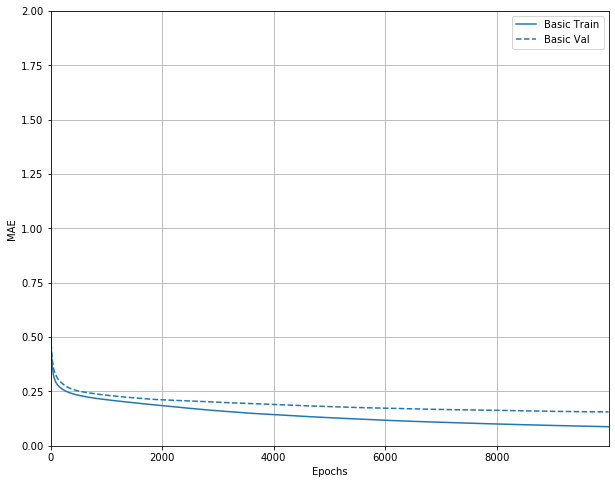

In [67]:
#Checking if is overfitting and how the mean absolute error decrease 

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plt.figure(figsize=(10,8))
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('MAE')



In [68]:
#Doing the predictions:
predictions_NN = model.predict(normed_test_data).flatten()

#Dif between the real and the predicted values: 
error = predictions_NN - test_labels

print(np.mean(np.abs(error)),np.std(np.abs(error)), 'Mean absolute error and std MAE')

rms = sqrt(mean(square(error)))
print(rms, 'RMS regression')



0.16344220398076836 0.1979530512882338 Mean absolute error and std MAE
0.2567075467461235 RMS regression


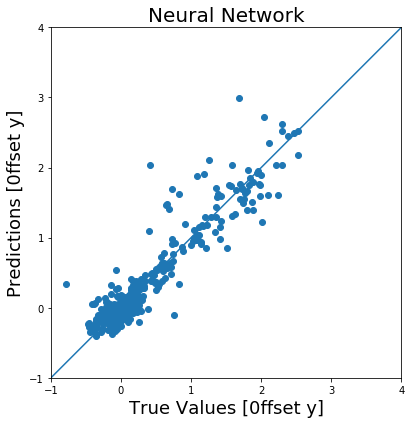

In [69]:
#plot the predicted vs real values 

plt.figure(figsize=(10,6))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, predictions_NN)
plt.xlabel('True Values [0ffset y]',fontsize=18)
plt.title('Neural Network', fontsize=20)
plt.ylabel('Predictions [0ffset y]',fontsize=18)
lims = [-1, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.tight_layout()
 
 

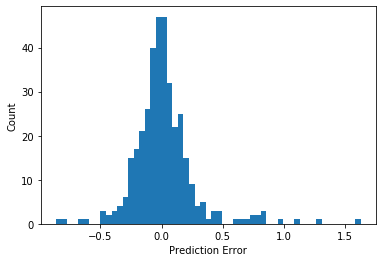

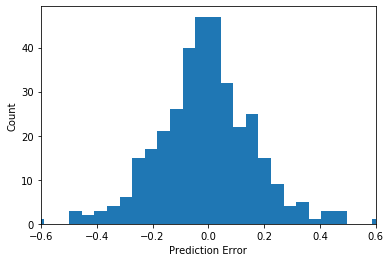

In [70]:
#Error histogram
plt.hist(error, bins = 55)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

plt.figure()
plt.hist(error, bins = 55)
plt.xlim(-0.6,0.6)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

